# Image Fusion

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
import os

In [2]:
def crop_image_to_mask(img, box):
    new_img = img[box[1]:box[1]+box[3],box[0]:box[0]+box[2]]
    
    return new_img

In [3]:
# cv2 resize to keep aspect ratio
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [34]:
def bounding_box_s(img, save_path='',show_binary=False, 
                 can1=10, can2=150, can3=1, 
                 dilate0=0, erode1=0, 
                 dilate1=0, erode2=0, 
                 dilate2=0, choose=0):
    '''image preprocessing and find bounding box '''
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #_, binary = cv2.threshold(gray_img, 90, 255,cv2.THRESH_BINARY)
    binary = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11,25)
    edges = cv2.Canny(img, can1, can2, can3)
    bin_edge = cv2.add(binary, edges)
    edge_0 = cv2.dilate(bin_edge, np.ones((3,3)), iterations=dilate0)
    edge_1 = cv2.erode(edge_0, np.ones((3,3)), iterations=erode1)
    edge_2 = cv2.dilate(edge_1, np.ones((3,3)), iterations=dilate1)
    edge_3 = cv2.erode(edge_2, np.ones((3,3)), iterations=erode2)
    edge_4 = cv2.dilate(edge_3, np.ones((3,3)), iterations=dilate2)
    img_list = [gray_img, binary, edges, bin_edge, edge_0, edge_1, edge_2, edge_3, edge_4] 

    if show_binary:
        '''
        cv2.imshow("Binary", binary)
        cv2.imshow("Edge", edges)
        cv2.imshow("Bin+Edge:", bin_edge)
        cv2.imshow('dilate0', edge_0)
        cv2.imshow('errode1', edge_1)
        cv2.imshow('dilate1', edge_2)
        cv2.imshow('errode2', edge_3)
        cv2.imshow('dilate2', edge_4)
        '''
        plt.figure(figsize=[5,5])
        plt.imshow(binary, cmap='gray'), plt.xticks([]), plt.yticks([]), plt.title('binary')
        plt.figure(figsize=[5,5])
        plt.imshow(edges, cmap='gray'), plt.xticks([]), plt.yticks([]), plt.title('edges')
        plt.figure(figsize=[5,5])
        plt.imshow(bin_edge, cmap='gray'), plt.xticks([]), plt.yticks([]), plt.title('bin_edge')
        plt.figure(figsize=[5,5])
        plt.imshow(edge_0, cmap='gray'), plt.xticks([]), plt.yticks([]), plt.title('dilate_0')
        plt.figure(figsize=[5,5])
        plt.imshow(edge_1, cmap='gray'), plt.xticks([]), plt.yticks([]), plt.title('erode_1')
        plt.figure(figsize=[5,5])
        plt.imshow(edge_2, cmap='gray'), plt.xticks([]), plt.yticks([]), plt.title('dilate_2')
        plt.figure(figsize=[5,5])
        plt.imshow(edge_3, cmap='gray'), plt.xticks([]), plt.yticks([]), plt.title('erode_3')
        plt.figure(figsize=[5,5])
        plt.imshow(edge_4, cmap='gray'), plt.xticks([]), plt.yticks([]), plt.title('dilate_4')
        
        
    _, cnts, _=cv2.findContours(edge_4, 1,2)
    box_list = []
    if len(cnts) > 0:
        for cnt in cnts:        
            x,y,w,h = cv2.boundingRect(cnt)
            box_list.append((x,y,w,h))

    return box_list, img_list

In [23]:
def image_fusion(image_path, bg_img_path,position_top_left=(10,10),bg_resize=False,name="object",
                 save_img="" ,log_enable=False):
    '''return fusion image and bounding box (xmin, ymin, xmax, ymax)'''
    f = cv2.imread(image_path)
    print('origin:', image_path)
    f0 = f.copy()
    boxs, mask = bounding_box_s(f0, save_path='', show_binary=True,
                     can1=250, can2=255, can3=1, 
                     dilate0=25, erode1=25, 
                     dilate1=0, erode2=1, 
                     dilate2=0, choose=0)
    box0 = (0,0,0,0)
    if len(boxs):
        if log_enable:
            print("found boxs:", boxs)
        for idx ,box in enumerate(boxs):
            if box[2] <50 or box[3]<50:
                print("1")
                continue
            elif box[3] > 350 and box[2]*box[3] > 50000:
                print("2")
                continue
            elif box[1] < 5 or box[0] > 600:
                print("3")
                continue
            else:
                box0 = box
                result = crop_image_to_mask(mask[-1], box)
                img_crop = crop_image_to_mask(f0, box)
                img_object = img_crop.copy()
                img_bk_ground = img_crop.copy()
                #mask image
                img_object[result==0] =(0,0,0)
                img_bk_ground[result!=0] =(255,0,0)
            if log_enable:
                #plot
                print(box)
                plt.figure(figsize=[15,10])
                plt.subplot(1,4,1)
                plt.imshow(result, cmap='gray')
                plt.xticks([]), plt.yticks([])
                plt.title('mask')
                plt.subplot(1,4,2)
                plt.imshow(cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB))
                plt.xticks([]), plt.yticks([])
                plt.title('corp_image')
                plt.subplot(1,4,3)
                plt.imshow(cv2.cvtColor(img_object, cv2.COLOR_BGR2RGB))
                plt.xticks([]), plt.yticks([])
                plt.title('mask show original object\n and make background black')
                plt.subplot(1,4,4)
                plt.imshow(img_bk_ground)
                plt.xticks([]), plt.yticks([])
                plt.title('mask show original background\n and make object red')
    else:
        print('no box found')
    #handling background
    back_ground_image_0 = cv2.imread(bg_img_path)
    if bg_resize:
        print('background_resize to 640*480')
        back_ground_image = image_resize(image=back_ground_image_0, width =640,height= 480)
        print('resize_shape:{}/{}'.format(back_ground_image.shape[0], back_ground_image.shape[1]))
    else:
        back_ground_image = back_ground_image_0
    if log_enable:
        plt.figure()
        plt.imshow(cv2.cvtColor(back_ground_image, cv2.COLOR_BGR2RGB)), plt.xticks([]), plt.yticks([]); 
        plt.title('BackGround')
    bg_mask = np.zeros((back_ground_image.shape[0], back_ground_image.shape[1]), dtype='uint8')
    #box0_size = (box0[2]//2, box0[3]//2)
    print('object_crop_img_size:', box0[2], box0[3])
    
    #record bounding box position /width/ height
    bounding_box = (position_top_left[0],position_top_left[1], position_top_left[0]+box0[2], position_top_left[1]+box0[3])
    bg_mask[position_top_left[1]:position_top_left[1]+result.shape[0],position_top_left[0]:position_top_left[0]+result.shape[1]] = result
    if log_enable:
        plt.figure()
        plt.imshow(bg_mask, cmap='gray'), plt.xticks([]), plt.yticks([]);
        plt.title('object_bg_mask')
    #handle background with mask
    bg_1 = back_ground_image.copy()
    bg_1[bg_mask==255] = (0,0,0)
    if log_enable:
        plt.figure(), plt.title('hollow object background')
        plt.imshow(cv2.cvtColor(bg_1, cv2.COLOR_BGR2RGB)), plt.xticks([]), plt.yticks([])
    # handle object on backgoround
    object_mask = np.zeros_like(back_ground_image)
    object_mask[position_top_left[1]:position_top_left[1]+result.shape[0],
                position_top_left[0]:position_top_left[0]+result.shape[1]] = img_object
    
    if log_enable:
        plt.figure(), plt.title('object only')
        plt.imshow(cv2.cvtColor(object_mask, cv2.COLOR_BGR2RGB)), plt.xticks([]), plt.yticks([]);
    final = cv2.add(bg_1, object_mask)
    if log_enable:
        plt.figure(), plt.title('Final Fusion'), plt.xticks([]), plt.yticks([]);
        plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB));
    if save_img != "":
        filename=(save_img+ name+"_"+str(bounding_box[0])+"_"+str(bounding_box[1])+
                    "_"+str(bounding_box[2])+"_"+str(bounding_box[3])+".jpg")
        cv2.imwrite(filename, final)
        print("save img:", filename)
    return final, bounding_box
    

origin: ./DataSet_190306/img_110/Puff/Puff_64_1.jpg
found boxs: [(243, 127, 154, 227)]
(243, 127, 154, 227)
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 154 227
save img: ./result/Oolong_table1_280_190_434_417.jpg
fusion img bounding box: (280, 190, 434, 417)


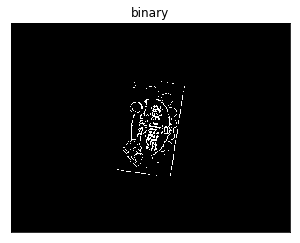

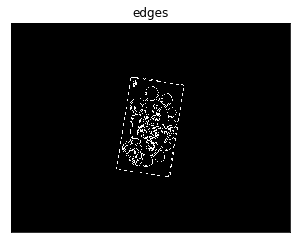

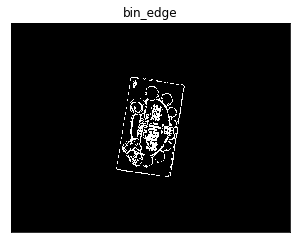

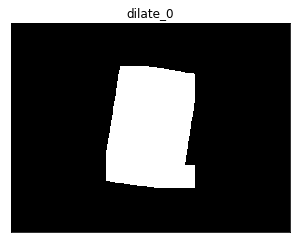

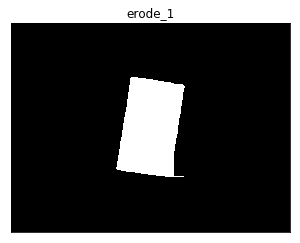

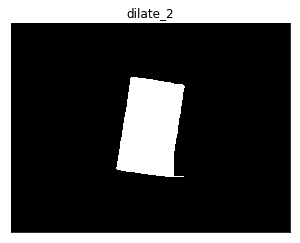

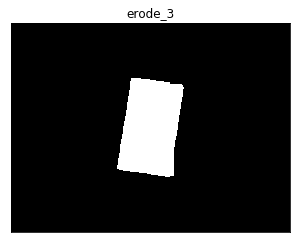

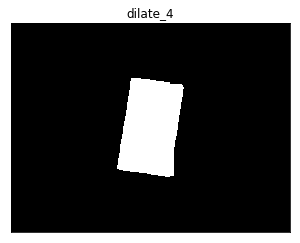

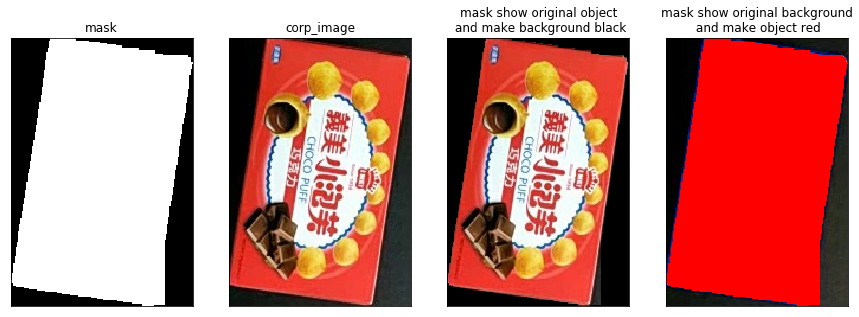

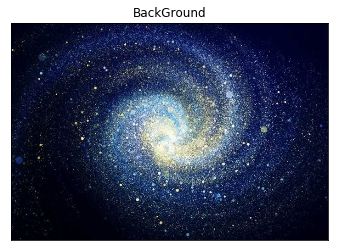

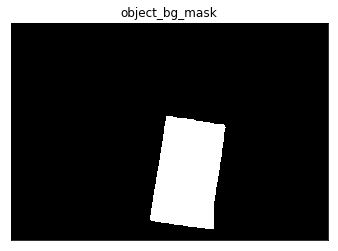

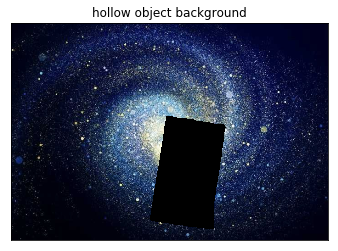

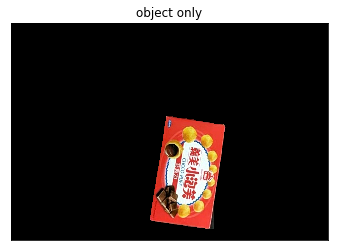

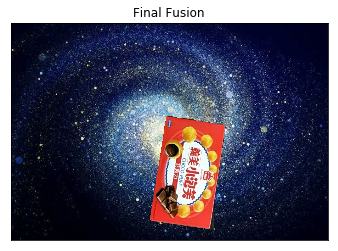

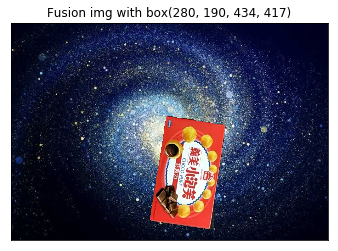

In [35]:
#test
#image_path = './DataSet_0129/img/Puff_0/Puff_1001_1.jpg'
#bg_img_path = './galaxy.jpg'
bg_img_path = './bg_database/table0.jpg'
#image_path = './DataSet_0129/img/Oolong_Tea_0/Oolong_Tea_1001_1.jpg'
image_path = './DataSet_190306/img_110/Puff/Puff_64_1.jpg'
#image_path = './13/results__9.jpg'
#image_path = './DataSet_0129/'
save_path = './result/'
fusion, bounding_box = image_fusion(image_path, bg_img_path, save_img=save_path, bg_resize=True,name="Oolong_table1",
                                    position_top_left=(280, 190) ,log_enable=True)
print("fusion img bounding box:", bounding_box)
plt.figure(), plt.imshow(cv2.cvtColor(fusion, cv2.COLOR_BGR2RGB)), plt.xticks([]), plt.yticks([])
plt.title('Fusion img with box'+str(bounding_box));

# xml processing

In [69]:
target = 'Family-Water'
table_name = 'table0'
one_dataset = './DataSet_190318/img_120/'+target+"/"
bg = './bg_database/'+ table_name+'.jpg'
save_path = './DataSet_190318/image/'+target +"/"
label = target+'_'+ table_name

for img in os.listdir(one_dataset):
    #print(one_dataset+img)
    flag = 0
    while(flag==0):
        try:
            x = random.randint(10, 450)
            y = random.randint(10,350)
            image_fusion(one_dataset+img, bg, position_top_left=(x, y), bg_resize=True,
                         name=label, save_img=save_path)
            flag = 1
        except ValueError:
            print('out of box')


origin: ./DataSet_190318/img_120/Family-Water/001_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 84 262
save img: ./DataSet_190318/image/Family-Water/Family-Water_table0_298_112_382_374.jpg
origin: ./DataSet_190318/img_120/Family-Water/002_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 91 262
save img: ./DataSet_190318/image/Family-Water/Family-Water_table0_325_33_416_295.jpg
origin: ./DataSet_190318/img_120/Family-Water/003_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 99 261
save img: ./DataSet_190318/image/Family-Water/Family-Water_table0_91_117_190_378.jpg
origin: ./DataSet_190318/img_120/Family-Water/004_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 108 260
out of box
origin: ./DataSet_190318/img_120/Family-Water/004_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 108 260
o

origin: ./DataSet_190318/img_120/Family-Water/029_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 262 81
save img: ./DataSet_190318/image/Family-Water/Family-Water_table0_238_52_500_133.jpg
origin: ./DataSet_190318/img_120/Family-Water/030_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 261 77
save img: ./DataSet_190318/image/Family-Water/Family-Water_table0_175_12_436_89.jpg
origin: ./DataSet_190318/img_120/Family-Water/031_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 262 84
save img: ./DataSet_190318/image/Family-Water/Family-Water_table0_173_79_435_163.jpg
origin: ./DataSet_190318/img_120/Family-Water/032_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 262 91
out of box
origin: ./DataSet_190318/img_120/Family-Water/032_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 262 91
save 

background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 165 241
save img: ./DataSet_190318/image/Family-Water/Family-Water_table0_224_72_389_313.jpg
origin: ./DataSet_190318/img_120/Family-Water/051_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 155 247
out of box
origin: ./DataSet_190318/img_120/Family-Water/051_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 155 247
save img: ./DataSet_190318/image/Family-Water/Family-Water_table0_422_57_577_304.jpg
origin: ./DataSet_190318/img_120/Family-Water/052_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 144 249
save img: ./DataSet_190318/image/Family-Water/Family-Water_table0_141_71_285_320.jpg
origin: ./DataSet_190318/img_120/Family-Water/053_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 134 253
save img: ./DataSet_190318/image/Family-Water/Family-Water_table0_

save img: ./DataSet_190318/image/Family-Water/Family-Water_table0_68_106_254_337.jpg
origin: ./DataSet_190318/img_120/Family-Water/073_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 194 224
save img: ./DataSet_190318/image/Family-Water/Family-Water_table0_95_204_289_428.jpg
origin: ./DataSet_190318/img_120/Family-Water/074_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 204 217
save img: ./DataSet_190318/image/Family-Water/Family-Water_table0_325_121_529_338.jpg
origin: ./DataSet_190318/img_120/Family-Water/075_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 211 210
save img: ./DataSet_190318/image/Family-Water/Family-Water_table0_403_227_614_437.jpg
origin: ./DataSet_190318/img_120/Family-Water/076_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 218 202
out of box
origin: ./DataSet_190318/img_120/Family-Water/076_Family-Wa

origin: ./DataSet_190318/img_120/Family-Water/104_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 217 204
out of box
origin: ./DataSet_190318/img_120/Family-Water/104_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 217 204
save img: ./DataSet_190318/image/Family-Water/Family-Water_table0_382_175_599_379.jpg
origin: ./DataSet_190318/img_120/Family-Water/105_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 210 210
save img: ./DataSet_190318/image/Family-Water/Family-Water_table0_239_100_449_310.jpg
origin: ./DataSet_190318/img_120/Family-Water/106_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 202 218
out of box
origin: ./DataSet_190318/img_120/Family-Water/106_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 202 218
out of box
origin: ./DataSet_190318/img_120/Family-Water/106_Family-Wat

In [95]:
targetPath = './DataSet_190318/img_120/'
tablePath = './bg_database/5/'
savePath = './DataSet_190318/image2/'

for target in os.listdir(targetPath):
    if not os.path.exists(savePath+target):
        os.mkdir(savePath+target)
    one_dataset = targetPath+target+"/"
    save_path = savePath + target+"/"
    for table in os.listdir(tablePath):
        bg = tablePath + table
        label = target+'_'+ table[:-4]
        #print('bg:', bg)
        for img in os.listdir(one_dataset):
            flag = 0
            while(flag==0):
                try:
                    x = random.randint(10, 450)
                    y = random.randint(10,350)
                    image_fusion(one_dataset+img, bg, position_top_left=(x, y), bg_resize=True,
                                 name=label, save_img=save_path)
                    flag = 1
                except ValueError:
                    print('out of box')


origin: ./DataSet_190318/img_120/Black-Tea/001_Black-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 94 166
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table0_442_216_536_382.jpg
origin: ./DataSet_190318/img_120/Black-Tea/002_Black-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 101 169
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table0_41_184_142_353.jpg
origin: ./DataSet_190318/img_120/Black-Tea/003_Black-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 109 171
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table0_61_24_170_195.jpg
origin: ./DataSet_190318/img_120/Black-Tea/004_Black-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 115 173
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table0_275_87_390_260.jpg
origin: ./DataSet_190318/img_120/Black-Tea/005_Black-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object

resize_shape:439/640
object_crop_img_size: 175 128
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table0_405_189_580_317.jpg
origin: ./DataSet_190318/img_120/Black-Tea/037_Black-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 176 134
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table0_44_270_220_404.jpg
origin: ./DataSet_190318/img_120/Black-Tea/038_Black-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 176 140
out of box
origin: ./DataSet_190318/img_120/Black-Tea/038_Black-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 176 140
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table0_136_17_312_157.jpg
origin: ./DataSet_190318/img_120/Black-Tea/039_Black-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 175 144
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table0_124_178_299_322.jpg
origin: ./DataSet_190318/img_120/Black-Tea/040_Black

resize_shape:439/640
object_crop_img_size: 128 175
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table0_240_236_368_411.jpg
origin: ./DataSet_190318/img_120/Black-Tea/067_Black-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 134 176
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table0_236_56_370_232.jpg
origin: ./DataSet_190318/img_120/Black-Tea/068_Black-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 140 176
out of box
origin: ./DataSet_190318/img_120/Black-Tea/068_Black-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 140 176
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table0_352_93_492_269.jpg
origin: ./DataSet_190318/img_120/Black-Tea/069_Black-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 144 176
out of box
origin: ./DataSet_190318/img_120/Black-Tea/069_Black-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop

origin: ./DataSet_190318/img_120/Black-Tea/099_Black-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 176 144
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table0_155_139_331_283.jpg
origin: ./DataSet_190318/img_120/Black-Tea/100_Black-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 174 150
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table0_285_259_459_409.jpg
origin: ./DataSet_190318/img_120/Black-Tea/101_Black-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 173 154
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table0_104_146_277_300.jpg
origin: ./DataSet_190318/img_120/Black-Tea/102_Black-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 172 158
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table0_338_126_510_284.jpg
origin: ./DataSet_190318/img_120/Black-Tea/103_Black-Tea.jpg
background_resize to 640*480
resize_shape:439/640
o

origin: ./DataSet_190318/img_120/Black-Tea/012_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 158 172
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table1_45_57_203_229.jpg
origin: ./DataSet_190318/img_120/Black-Tea/013_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 162 170
out of box
origin: ./DataSet_190318/img_120/Black-Tea/013_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 162 170
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table1_159_155_321_325.jpg
origin: ./DataSet_190318/img_120/Black-Tea/014_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 165 167
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table1_334_223_499_390.jpg
origin: ./DataSet_190318/img_120/Black-Tea/015_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 168 164
save img: ./DataSet_190318/image2/Black-Tea

resize_shape:426/640
object_crop_img_size: 170 162
out of box
origin: ./DataSet_190318/img_120/Black-Tea/043_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 170 162
out of box
origin: ./DataSet_190318/img_120/Black-Tea/043_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 170 162
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table1_377_105_547_267.jpg
origin: ./DataSet_190318/img_120/Black-Tea/044_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 167 165
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table1_390_260_557_425.jpg
origin: ./DataSet_190318/img_120/Black-Tea/045_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 164 169
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table1_226_49_390_218.jpg
origin: ./DataSet_190318/img_120/Black-Tea/046_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_cro

origin: ./DataSet_190318/img_120/Black-Tea/077_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 173 157
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table1_374_116_547_273.jpg
origin: ./DataSet_190318/img_120/Black-Tea/078_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 175 153
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table1_358_242_533_395.jpg
origin: ./DataSet_190318/img_120/Black-Tea/079_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 175 148
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table1_206_37_381_185.jpg
origin: ./DataSet_190318/img_120/Black-Tea/080_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 177 143
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table1_127_123_304_266.jpg
origin: ./DataSet_190318/img_120/Black-Tea/081_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
ob

origin: ./DataSet_190318/img_120/Black-Tea/111_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 137 177
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table1_311_185_448_362.jpg
origin: ./DataSet_190318/img_120/Black-Tea/112_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 131 175
out of box
origin: ./DataSet_190318/img_120/Black-Tea/112_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 131 175
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table1_186_47_317_222.jpg
origin: ./DataSet_190318/img_120/Black-Tea/113_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 125 175
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table1_59_178_184_353.jpg
origin: ./DataSet_190318/img_120/Black-Tea/114_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 120 175
save img: ./DataSet_190318/image2/Black-Tea

origin: ./DataSet_190318/img_120/Black-Tea/026_Black-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 171 106
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table2_16_64_187_170.jpg
origin: ./DataSet_190318/img_120/Black-Tea/027_Black-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 169 99
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table2_190_262_359_361.jpg
origin: ./DataSet_190318/img_120/Black-Tea/028_Black-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 165 93
out of box
origin: ./DataSet_190318/img_120/Black-Tea/028_Black-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 165 93
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table2_211_273_376_366.jpg
origin: ./DataSet_190318/img_120/Black-Tea/029_Black-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 163 87
save img: ./DataSet_190318/image2/Black-Tea/Bla

origin: ./DataSet_190318/img_120/Black-Tea/061_Black-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 94 166
out of box
origin: ./DataSet_190318/img_120/Black-Tea/061_Black-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 94 166
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table2_267_37_361_203.jpg
origin: ./DataSet_190318/img_120/Black-Tea/062_Black-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 101 169
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table2_216_225_317_394.jpg
origin: ./DataSet_190318/img_120/Black-Tea/063_Black-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 108 171
out of box
origin: ./DataSet_190318/img_120/Black-Tea/063_Black-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 108 171
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table2_85_192_193_363.jpg
origin: ./DataSet_190318/img_120/B

resize_shape:422/640
object_crop_img_size: 173 115
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table2_450_162_623_277.jpg
origin: ./DataSet_190318/img_120/Black-Tea/095_Black-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 175 122
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table2_284_102_459_224.jpg
origin: ./DataSet_190318/img_120/Black-Tea/096_Black-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 175 128
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table2_142_290_317_418.jpg
origin: ./DataSet_190318/img_120/Black-Tea/097_Black-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 176 134
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table2_353_184_529_318.jpg
origin: ./DataSet_190318/img_120/Black-Tea/098_Black-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 176 140
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table2_

resize_shape:426/640
object_crop_img_size: 121 175
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table3_219_79_340_254.jpg
origin: ./DataSet_190318/img_120/Black-Tea/006_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 128 175
out of box
origin: ./DataSet_190318/img_120/Black-Tea/006_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 128 175
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table3_288_228_416_403.jpg
origin: ./DataSet_190318/img_120/Black-Tea/007_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 134 176
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table3_328_193_462_369.jpg
origin: ./DataSet_190318/img_120/Black-Tea/008_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 140 176
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table3_180_17_320_193.jpg
origin: ./DataSet_190318/img_120/Black-Tea/009_Black

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 175 144
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table3_209_260_384_404.jpg
origin: ./DataSet_190318/img_120/Black-Tea/040_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 174 150
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table3_247_43_421_193.jpg
origin: ./DataSet_190318/img_120/Black-Tea/041_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 173 154
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table3_280_188_453_342.jpg
origin: ./DataSet_190318/img_120/Black-Tea/042_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 172 158
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table3_123_71_295_229.jpg
origin: ./DataSet_190318/img_120/Black-Tea/043_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 170 162
save img: ./DataSet_190318/image2/

resize_shape:426/640
object_crop_img_size: 140 176
out of box
origin: ./DataSet_190318/img_120/Black-Tea/068_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 140 176
out of box
origin: ./DataSet_190318/img_120/Black-Tea/068_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 140 176
out of box
origin: ./DataSet_190318/img_120/Black-Tea/068_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 140 176
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table3_362_12_502_188.jpg
origin: ./DataSet_190318/img_120/Black-Tea/069_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 144 176
out of box
origin: ./DataSet_190318/img_120/Black-Tea/069_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 144 176
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table3_269_89_413_265.jpg
origin: ./DataSet_190318/img_120/Black-T

origin: ./DataSet_190318/img_120/Black-Tea/103_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 170 162
out of box
origin: ./DataSet_190318/img_120/Black-Tea/103_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 170 162
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table3_31_127_201_289.jpg
origin: ./DataSet_190318/img_120/Black-Tea/104_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 167 165
out of box
origin: ./DataSet_190318/img_120/Black-Tea/104_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 167 165
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table3_28_140_195_305.jpg
origin: ./DataSet_190318/img_120/Black-Tea/105_Black-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 164 168
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table3_147_213_311_381.jpg
origin: ./DataSet_190318/img_120

origin: ./DataSet_190318/img_120/Black-Tea/015_Black-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 168 164
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table4_202_25_370_189.jpg
origin: ./DataSet_190318/img_120/Black-Tea/016_Black-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 171 160
out of box
origin: ./DataSet_190318/img_120/Black-Tea/016_Black-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 171 160
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table4_197_213_368_373.jpg
origin: ./DataSet_190318/img_120/Black-Tea/017_Black-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 173 157
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table4_176_191_349_348.jpg
origin: ./DataSet_190318/img_120/Black-Tea/018_Black-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 175 153
save img: ./DataSet_190318/image2/Black-Te

origin: ./DataSet_190318/img_120/Black-Tea/051_Black-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 137 177
out of box
origin: ./DataSet_190318/img_120/Black-Tea/051_Black-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 137 177
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table4_101_190_238_367.jpg
origin: ./DataSet_190318/img_120/Black-Tea/052_Black-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 131 175
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table4_116_244_247_419.jpg
origin: ./DataSet_190318/img_120/Black-Tea/053_Black-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 126 175
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table4_84_206_210_381.jpg
origin: ./DataSet_190318/img_120/Black-Tea/054_Black-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 120 175
out of box
origin: ./DataSet_190318/img_12

origin: ./DataSet_190318/img_120/Black-Tea/087_Black-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 169 99
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table4_323_233_492_332.jpg
origin: ./DataSet_190318/img_120/Black-Tea/088_Black-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 165 93
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table4_427_224_592_317.jpg
origin: ./DataSet_190318/img_120/Black-Tea/089_Black-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 163 87
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table4_162_136_325_223.jpg
origin: ./DataSet_190318/img_120/Black-Tea/090_Black-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 163 88
save img: ./DataSet_190318/image2/Black-Tea/Black-Tea_table4_89_54_252_142.jpg
origin: ./DataSet_190318/img_120/Black-Tea/091_Black-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_

save img: ./DataSet_190318/image2/Cheers/Cheers_table0_106_137_188_373.jpg
origin: ./DataSet_190318/img_120/Cheers/002_Cheers.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 87 235
save img: ./DataSet_190318/image2/Cheers/Cheers_table0_21_14_108_249.jpg
origin: ./DataSet_190318/img_120/Cheers/003_Cheers.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 92 235
save img: ./DataSet_190318/image2/Cheers/Cheers_table0_352_153_444_388.jpg
origin: ./DataSet_190318/img_120/Cheers/004_Cheers.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 99 234
save img: ./DataSet_190318/image2/Cheers/Cheers_table0_71_149_170_383.jpg
origin: ./DataSet_190318/img_120/Cheers/005_Cheers.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 104 233
out of box
origin: ./DataSet_190318/img_120/Cheers/005_Cheers.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 104 233
out of box
origin: .

object_crop_img_size: 236 81
save img: ./DataSet_190318/image2/Cheers/Cheers_table0_345_143_581_224.jpg
origin: ./DataSet_190318/img_120/Cheers/030_Cheers.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 236 77
save img: ./DataSet_190318/image2/Cheers/Cheers_table0_356_242_592_319.jpg
origin: ./DataSet_190318/img_120/Cheers/031_Cheers.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 235 81
save img: ./DataSet_190318/image2/Cheers/Cheers_table0_393_38_628_119.jpg
origin: ./DataSet_190318/img_120/Cheers/032_Cheers.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 235 87
save img: ./DataSet_190318/image2/Cheers/Cheers_table0_277_291_512_378.jpg
origin: ./DataSet_190318/img_120/Cheers/033_Cheers.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 235 92
save img: ./DataSet_190318/image2/Cheers/Cheers_table0_140_73_375_165.jpg
origin: ./DataSet_190318/img_120/Cheers/034_Cheers.jpg
backgro

object_crop_img_size: 99 233
out of box
origin: ./DataSet_190318/img_120/Cheers/064_Cheers.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 99 233
out of box
origin: ./DataSet_190318/img_120/Cheers/064_Cheers.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 99 233
save img: ./DataSet_190318/image2/Cheers/Cheers_table0_339_183_438_416.jpg
origin: ./DataSet_190318/img_120/Cheers/065_Cheers.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 104 231
save img: ./DataSet_190318/image2/Cheers/Cheers_table0_95_204_199_435.jpg
origin: ./DataSet_190318/img_120/Cheers/066_Cheers.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 112 230
save img: ./DataSet_190318/image2/Cheers/Cheers_table0_123_166_235_396.jpg
origin: ./DataSet_190318/img_120/Cheers/067_Cheers.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 123 228
save img: ./DataSet_190318/image2/Cheers/Cheers_tabl

resize_shape:439/640
object_crop_img_size: 233 99
save img: ./DataSet_190318/image2/Cheers/Cheers_table0_75_256_308_355.jpg
origin: ./DataSet_190318/img_120/Cheers/095_Cheers.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 231 104
save img: ./DataSet_190318/image2/Cheers/Cheers_table0_94_145_325_249.jpg
origin: ./DataSet_190318/img_120/Cheers/096_Cheers.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 230 113
out of box
origin: ./DataSet_190318/img_120/Cheers/096_Cheers.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 230 113
out of box
origin: ./DataSet_190318/img_120/Cheers/096_Cheers.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 230 113
save img: ./DataSet_190318/image2/Cheers/Cheers_table0_406_167_636_280.jpg
origin: ./DataSet_190318/img_120/Cheers/097_Cheers.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 228 123
out of box
origin: ./DataSet_1

origin: ./DataSet_190318/img_120/Cheers/004_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 99 234
save img: ./DataSet_190318/image2/Cheers/Cheers_table1_436_77_535_311.jpg
origin: ./DataSet_190318/img_120/Cheers/005_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 104 233
save img: ./DataSet_190318/image2/Cheers/Cheers_table1_178_101_282_334.jpg
origin: ./DataSet_190318/img_120/Cheers/006_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 113 230
save img: ./DataSet_190318/image2/Cheers/Cheers_table1_345_66_458_296.jpg
origin: ./DataSet_190318/img_120/Cheers/007_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 123 228
save img: ./DataSet_190318/image2/Cheers/Cheers_table1_23_59_146_287.jpg
origin: ./DataSet_190318/img_120/Cheers/008_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 132 224
save img: ./DataSet_190318/ima

origin: ./DataSet_190318/img_120/Cheers/040_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 218 150
out of box
origin: ./DataSet_190318/img_120/Cheers/040_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 218 150
save img: ./DataSet_190318/image2/Cheers/Cheers_table1_331_274_549_424.jpg
origin: ./DataSet_190318/img_120/Cheers/041_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 212 159
out of box
origin: ./DataSet_190318/img_120/Cheers/041_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 212 159
out of box
origin: ./DataSet_190318/img_120/Cheers/041_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 212 159
out of box
origin: ./DataSet_190318/img_120/Cheers/041_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 212 159
save img: ./DataSet_190318/image2/Cheers/Cheers_table1_29_201_241_360.j

object_crop_img_size: 141 221
save img: ./DataSet_190318/image2/Cheers/Cheers_table1_59_65_200_286.jpg
origin: ./DataSet_190318/img_120/Cheers/070_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 150 216
out of box
origin: ./DataSet_190318/img_120/Cheers/070_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 150 216
save img: ./DataSet_190318/image2/Cheers/Cheers_table1_311_189_461_405.jpg
origin: ./DataSet_190318/img_120/Cheers/071_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 159 212
save img: ./DataSet_190318/image2/Cheers/Cheers_table1_266_98_425_310.jpg
origin: ./DataSet_190318/img_120/Cheers/072_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 166 208
save img: ./DataSet_190318/image2/Cheers/Cheers_table1_327_39_493_247.jpg
origin: ./DataSet_190318/img_120/Cheers/073_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_si

resize_shape:426/640
object_crop_img_size: 190 188
save img: ./DataSet_190318/image2/Cheers/Cheers_table1_443_24_633_212.jpg
origin: ./DataSet_190318/img_120/Cheers/106_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 183 195
save img: ./DataSet_190318/image2/Cheers/Cheers_table1_237_109_420_304.jpg
origin: ./DataSet_190318/img_120/Cheers/107_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 176 201
out of box
origin: ./DataSet_190318/img_120/Cheers/107_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 176 201
out of box
origin: ./DataSet_190318/img_120/Cheers/107_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 176 201
save img: ./DataSet_190318/image2/Cheers/Cheers_table1_280_158_456_359.jpg
origin: ./DataSet_190318/img_120/Cheers/108_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 169 207
save img: ./DataSet_190318/i

origin: ./DataSet_190318/img_120/Cheers/012_Cheers.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 167 207
out of box
origin: ./DataSet_190318/img_120/Cheers/012_Cheers.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 167 207
out of box
origin: ./DataSet_190318/img_120/Cheers/012_Cheers.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 167 207
out of box
origin: ./DataSet_190318/img_120/Cheers/012_Cheers.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 167 207
save img: ./DataSet_190318/image2/Cheers/Cheers_table2_345_181_512_388.jpg
origin: ./DataSet_190318/img_120/Cheers/013_Cheers.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 174 202
save img: ./DataSet_190318/image2/Cheers/Cheers_table2_154_119_328_321.jpg
origin: ./DataSet_190318/img_120/Cheers/014_Cheers.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 181 196
out of 

resize_shape:422/640
object_crop_img_size: 183 195
out of box
origin: ./DataSet_190318/img_120/Cheers/046_Cheers.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 183 195
out of box
origin: ./DataSet_190318/img_120/Cheers/046_Cheers.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 183 195
out of box
origin: ./DataSet_190318/img_120/Cheers/046_Cheers.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 183 195
save img: ./DataSet_190318/image2/Cheers/Cheers_table2_305_58_488_253.jpg
origin: ./DataSet_190318/img_120/Cheers/047_Cheers.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 176 201
save img: ./DataSet_190318/image2/Cheers/Cheers_table2_121_134_297_335.jpg
origin: ./DataSet_190318/img_120/Cheers/048_Cheers.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 169 207
out of box
origin: ./DataSet_190318/img_120/Cheers/048_Cheers.jpg
background_resize to 640*4

resize_shape:422/640
object_crop_img_size: 181 197
out of box
origin: ./DataSet_190318/img_120/Cheers/074_Cheers.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 181 197
out of box
origin: ./DataSet_190318/img_120/Cheers/074_Cheers.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 181 197
save img: ./DataSet_190318/image2/Cheers/Cheers_table2_399_30_580_227.jpg
origin: ./DataSet_190318/img_120/Cheers/075_Cheers.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 188 190
out of box
origin: ./DataSet_190318/img_120/Cheers/075_Cheers.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 188 190
save img: ./DataSet_190318/image2/Cheers/Cheers_table2_222_181_410_371.jpg
origin: ./DataSet_190318/img_120/Cheers/076_Cheers.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 195 183
out of box
origin: ./DataSet_190318/img_120/Cheers/076_Cheers.jpg
background_resize to 640*4

resize_shape:422/640
object_crop_img_size: 207 167
save img: ./DataSet_190318/image2/Cheers/Cheers_table2_313_74_520_241.jpg
origin: ./DataSet_190318/img_120/Cheers/103_Cheers.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 203 174
save img: ./DataSet_190318/image2/Cheers/Cheers_table2_173_242_376_416.jpg
origin: ./DataSet_190318/img_120/Cheers/104_Cheers.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 196 181
save img: ./DataSet_190318/image2/Cheers/Cheers_table2_421_70_617_251.jpg
origin: ./DataSet_190318/img_120/Cheers/105_Cheers.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 190 188
save img: ./DataSet_190318/image2/Cheers/Cheers_table2_428_150_618_338.jpg
origin: ./DataSet_190318/img_120/Cheers/106_Cheers.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 183 195
save img: ./DataSet_190318/image2/Cheers/Cheers_table2_416_173_599_368.jpg
origin: ./DataSet_190318/img_120/Che

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 141 221
save img: ./DataSet_190318/image2/Cheers/Cheers_table3_85_141_226_362.jpg
origin: ./DataSet_190318/img_120/Cheers/010_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 150 216
save img: ./DataSet_190318/image2/Cheers/Cheers_table3_354_148_504_364.jpg
origin: ./DataSet_190318/img_120/Cheers/011_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 159 213
out of box
origin: ./DataSet_190318/img_120/Cheers/011_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 159 213
save img: ./DataSet_190318/image2/Cheers/Cheers_table3_437_168_596_381.jpg
origin: ./DataSet_190318/img_120/Cheers/012_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 167 207
out of box
origin: ./DataSet_190318/img_120/Cheers/012_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 167 207

resize_shape:426/640
object_crop_img_size: 212 159
save img: ./DataSet_190318/image2/Cheers/Cheers_table3_194_112_406_271.jpg
origin: ./DataSet_190318/img_120/Cheers/042_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 207 166
save img: ./DataSet_190318/image2/Cheers/Cheers_table3_419_244_626_410.jpg
origin: ./DataSet_190318/img_120/Cheers/043_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 202 174
save img: ./DataSet_190318/image2/Cheers/Cheers_table3_386_53_588_227.jpg
origin: ./DataSet_190318/img_120/Cheers/044_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 196 181
out of box
origin: ./DataSet_190318/img_120/Cheers/044_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 196 181
save img: ./DataSet_190318/image2/Cheers/Cheers_table3_184_68_380_249.jpg
origin: ./DataSet_190318/img_120/Cheers/045_Cheers.jpg
background_resize to 640*480
resize_shape:426

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 132 224
save img: ./DataSet_190318/image2/Cheers/Cheers_table3_55_198_187_422.jpg
origin: ./DataSet_190318/img_120/Cheers/069_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 141 221
save img: ./DataSet_190318/image2/Cheers/Cheers_table3_322_198_463_419.jpg
origin: ./DataSet_190318/img_120/Cheers/070_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 150 216
save img: ./DataSet_190318/image2/Cheers/Cheers_table3_33_99_183_315.jpg
origin: ./DataSet_190318/img_120/Cheers/071_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 159 212
save img: ./DataSet_190318/image2/Cheers/Cheers_table3_170_28_329_240.jpg
origin: ./DataSet_190318/img_120/Cheers/072_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 166 208
save img: ./DataSet_190318/image2/Cheers/Cheers_table3_237_169_403_377.jpg
origin: .

save img: ./DataSet_190318/image2/Cheers/Cheers_table3_314_157_517_331.jpg
origin: ./DataSet_190318/img_120/Cheers/104_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 196 181
save img: ./DataSet_190318/image2/Cheers/Cheers_table3_273_79_469_260.jpg
origin: ./DataSet_190318/img_120/Cheers/105_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 190 188
save img: ./DataSet_190318/image2/Cheers/Cheers_table3_140_185_330_373.jpg
origin: ./DataSet_190318/img_120/Cheers/106_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 183 195
save img: ./DataSet_190318/image2/Cheers/Cheers_table3_394_54_577_249.jpg
origin: ./DataSet_190318/img_120/Cheers/107_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 176 201
out of box
origin: ./DataSet_190318/img_120/Cheers/107_Cheers.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 176 201
save img: ./Data

origin: ./DataSet_190318/img_120/Cheers/014_Cheers.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 181 196
save img: ./DataSet_190318/image2/Cheers/Cheers_table4_318_193_499_389.jpg
origin: ./DataSet_190318/img_120/Cheers/015_Cheers.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 188 190
save img: ./DataSet_190318/image2/Cheers/Cheers_table4_374_145_562_335.jpg
origin: ./DataSet_190318/img_120/Cheers/016_Cheers.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 195 183
out of box
origin: ./DataSet_190318/img_120/Cheers/016_Cheers.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 195 183
save img: ./DataSet_190318/image2/Cheers/Cheers_table4_430_59_625_242.jpg
origin: ./DataSet_190318/img_120/Cheers/017_Cheers.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 201 178
save img: ./DataSet_190318/image2/Cheers/Cheers_table4_418_111_619_289.jpg
origin: ./DataS

background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 189 188
save img: ./DataSet_190318/image2/Cheers/Cheers_table4_139_78_328_266.jpg
origin: ./DataSet_190318/img_120/Cheers/046_Cheers.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 183 195
save img: ./DataSet_190318/image2/Cheers/Cheers_table4_295_46_478_241.jpg
origin: ./DataSet_190318/img_120/Cheers/047_Cheers.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 176 201
save img: ./DataSet_190318/image2/Cheers/Cheers_table4_411_84_587_285.jpg
origin: ./DataSet_190318/img_120/Cheers/048_Cheers.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 169 207
out of box
origin: ./DataSet_190318/img_120/Cheers/048_Cheers.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 169 207
out of box
origin: ./DataSet_190318/img_120/Cheers/048_Cheers.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 169 207
s

origin: ./DataSet_190318/img_120/Cheers/068_Cheers.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 132 224
save img: ./DataSet_190318/image2/Cheers/Cheers_table4_80_36_212_260.jpg
origin: ./DataSet_190318/img_120/Cheers/069_Cheers.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 141 221
out of box
origin: ./DataSet_190318/img_120/Cheers/069_Cheers.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 141 221
save img: ./DataSet_190318/image2/Cheers/Cheers_table4_81_91_222_312.jpg
origin: ./DataSet_190318/img_120/Cheers/070_Cheers.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 150 216
save img: ./DataSet_190318/image2/Cheers/Cheers_table4_308_31_458_247.jpg
origin: ./DataSet_190318/img_120/Cheers/071_Cheers.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 159 212
out of box
origin: ./DataSet_190318/img_120/Cheers/071_Cheers.jpg
background_resize to 640*480

origin: ./DataSet_190318/img_120/Cheers/100_Cheers.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 216 150
save img: ./DataSet_190318/image2/Cheers/Cheers_table4_33_168_249_318.jpg
origin: ./DataSet_190318/img_120/Cheers/101_Cheers.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 213 159
save img: ./DataSet_190318/image2/Cheers/Cheers_table4_317_12_530_171.jpg
origin: ./DataSet_190318/img_120/Cheers/102_Cheers.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 207 167
save img: ./DataSet_190318/image2/Cheers/Cheers_table4_305_147_512_314.jpg
origin: ./DataSet_190318/img_120/Cheers/103_Cheers.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 203 174
save img: ./DataSet_190318/image2/Cheers/Cheers_table4_379_178_582_352.jpg
origin: ./DataSet_190318/img_120/Cheers/104_Cheers.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 196 181
save img: ./DataSet_190318/

save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table0_50_77_188_249.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/005_Chrunchoco.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 144 174
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table0_34_92_178_266.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/006_Chrunchoco.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 150 178
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table0_121_136_271_314.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/007_Chrunchoco.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 155 180
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/007_Chrunchoco.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 155 180
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/007_Chrunchoco.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 155 180
save img: ./DataSe

object_crop_img_size: 164 125
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table0_361_215_525_340.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/033_Chrunchoco.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 168 132
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table0_110_41_278_173.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/034_Chrunchoco.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 172 138
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/034_Chrunchoco.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 172 138
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table0_231_263_403_401.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/035_Chrunchoco.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 174 144
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table0_194_27_368_171.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/036_Chrunchoc

save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table0_130_144_249_304.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/062_Chrunchoco.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 125 164
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table0_220_44_345_208.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/063_Chrunchoco.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 132 168
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table0_397_255_529_423.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/064_Chrunchoco.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 138 171
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table0_310_45_448_216.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/065_Chrunchoco.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 144 174
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table0_275_93_419_267.jpg
origin: ./DataSe

resize_shape:439/640
object_crop_img_size: 171 138
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/094_Chrunchoco.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 171 138
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/094_Chrunchoco.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 171 138
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table0_42_185_213_323.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/095_Chrunchoco.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 174 144
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/095_Chrunchoco.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 174 144
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table0_49_18_223_162.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/096_Chrunchoco.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 178 150
save img: ./DataSet_190318/image2/Chru

resize_shape:426/640
object_crop_img_size: 119 160
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table1_305_263_424_423.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/002_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 125 164
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/002_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 125 164
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table1_206_240_331_404.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/003_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 132 168
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table1_414_48_546_216.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/004_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 138 172
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table1_357_78_495_250.jpg
origin: ./DataSet_190318/img_120/Chr

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 160 119
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/031_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 160 119
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table1_183_249_343_368.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/032_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 164 125
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table1_96_232_260_357.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/033_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 168 132
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table1_150_238_318_370.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/034_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 172 138
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/034_Chrunchoco.jpg
background_resi

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 119 160
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table1_195_132_314_292.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/062_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 125 164
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table1_46_241_171_405.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/063_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 132 168
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table1_408_254_540_422.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/064_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 138 171
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/064_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 138 171
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/064_Chrunchoco.jpg
background_resi

origin: ./DataSet_190318/img_120/Chrunchoco/090_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 155 114
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table1_121_71_276_185.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/091_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 160 119
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table1_346_142_506_261.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/092_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 164 125
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table1_398_110_562_235.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/093_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 168 132
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table1_395_232_563_364.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/094_Chrunchoco.jpg
background_resize to 640*480
resiz

origin: ./DataSet_190318/img_120/Chrunchoco/001_Chrunchoco.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 119 160
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table2_256_121_375_281.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/002_Chrunchoco.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 125 164
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/002_Chrunchoco.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 125 164
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/002_Chrunchoco.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 125 164
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table2_154_127_279_291.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/003_Chrunchoco.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 132 168
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table2_96_63_228_231.jpg
origin: ./DataSe

background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 160 119
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table2_443_276_603_395.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/032_Chrunchoco.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 164 125
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table2_192_282_356_407.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/033_Chrunchoco.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 168 132
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table2_408_255_576_387.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/034_Chrunchoco.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 172 138
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table2_212_172_384_310.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/035_Chrunchoco.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 174 144
save img: ./Data

background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 119 160
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table2_408_50_527_210.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/062_Chrunchoco.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 125 164
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/062_Chrunchoco.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 125 164
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/062_Chrunchoco.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 125 164
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/062_Chrunchoco.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 125 164
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table2_29_94_154_258.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/063_Chrunchoco.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 132 168
save img:

origin: ./DataSet_190318/img_120/Chrunchoco/096_Chrunchoco.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 178 150
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table2_235_59_413_209.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/097_Chrunchoco.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 180 155
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table2_435_197_615_352.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/098_Chrunchoco.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 182 160
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table2_10_252_192_412.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/099_Chrunchoco.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 183 165
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/099_Chrunchoco.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 183 165
out of box
origin: ./DataSe

origin: ./DataSet_190318/img_120/Chrunchoco/001_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 119 160
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table3_310_205_429_365.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/002_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 125 164
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table3_396_21_521_185.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/003_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 132 168
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/003_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 132 168
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table3_97_208_229_376.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/004_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 138 172
out of box
origin: ./DataSe

origin: ./DataSet_190318/img_120/Chrunchoco/032_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 164 125
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table3_178_177_342_302.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/033_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 168 132
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table3_428_266_596_398.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/034_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 172 138
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table3_105_166_277_304.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/035_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 174 144
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table3_304_114_478_258.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/036_Chrunchoco.jpg
background_resize to 640*480
resi

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 114 155
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/060_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 114 155
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table3_22_251_136_406.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/061_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 119 160
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/061_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 119 160
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table3_69_90_188_250.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/062_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 125 164
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table3_270_158_395_322.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/063_Chrunchoco.jpg
background_resize

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 160 119
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/091_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 160 119
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table3_387_282_547_401.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/092_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 164 125
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table3_17_44_181_169.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/093_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 168 132
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table3_42_273_210_405.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/094_Chrunchoco.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 171 138
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table3_128_245_299_383.jpg
origin: 

resize_shape:426/640
object_crop_img_size: 114 155
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table3_120_77_234_232.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/001_Chrunchoco.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 119 160
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table4_437_178_556_338.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/002_Chrunchoco.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 125 164
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/002_Chrunchoco.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 125 164
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/002_Chrunchoco.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 125 164
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table4_253_135_378_299.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/003_Chrunchoco.jpg
background_resize to 640*480
resize_shape:42

resize_shape:425/640
object_crop_img_size: 168 132
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/033_Chrunchoco.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 168 132
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table4_219_155_387_287.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/034_Chrunchoco.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 172 138
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table4_402_131_574_269.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/035_Chrunchoco.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 174 144
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/035_Chrunchoco.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 174 144
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table4_337_241_511_385.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/036_Chrunchoco.jpg
background_resize to 640*480
resize_shape:4

resize_shape:425/640
object_crop_img_size: 144 174
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table4_342_193_486_367.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/066_Chrunchoco.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 150 178
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table4_384_38_534_216.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/067_Chrunchoco.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 155 180
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/067_Chrunchoco.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 155 180
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table4_58_185_213_365.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/068_Chrunchoco.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 160 182
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table4_294_138_454_320.jpg
origin: ./DataSet_190318/img_120/Chr

resize_shape:425/640
object_crop_img_size: 180 155
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table4_71_263_251_418.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/098_Chrunchoco.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 182 160
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table4_37_88_219_248.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/099_Chrunchoco.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 183 165
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table4_56_124_239_289.jpg
origin: ./DataSet_190318/img_120/Chrunchoco/100_Chrunchoco.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 184 169
out of box
origin: ./DataSet_190318/img_120/Chrunchoco/100_Chrunchoco.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 184 169
save img: ./DataSet_190318/image2/Chrunchoco/Chrunchoco_table4_300_240_484_409.jpg
origin: ./DataSet_190318/img_120/Chrun

object_crop_img_size: 116 170
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table0_215_267_331_437.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/006_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 121 171
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table0_345_150_466_321.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/007_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 128 172
out of box
origin: ./DataSet_190318/img_120/Coffee-Milk/007_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 128 172
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table0_339_125_467_297.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/008_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 133 172
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table0_425_78_558_250.jpg
origin: ./DataSet_190318/img_120/Coffee-

resize_shape:439/640
object_crop_img_size: 172 133
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table0_168_33_340_166.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/039_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 173 139
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table0_287_131_460_270.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/040_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 172 144
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table0_223_88_395_232.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/041_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 171 149
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table0_315_110_486_259.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/042_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 170 153
save img: ./DataSet_190318/imag

background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 153 170
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table0_245_61_398_231.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/073_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 157 168
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table0_199_23_356_191.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/074_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 160 167
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table0_55_22_215_189.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/075_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 164 164
out of box
origin: ./DataSet_190318/img_120/Coffee-Milk/075_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 164 164
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table0_83_109_247_27

background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 158 168
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table0_379_155_537_323.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/108_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 154 170
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table0_70_163_224_333.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/109_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 150 172
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table0_255_210_405_382.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/110_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 146 173
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table0_120_37_266_210.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/111_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 141 174
ou

save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table1_80_261_250_415.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/019_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 172 150
out of box
origin: ./DataSet_190318/img_120/Coffee-Milk/019_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 172 150
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table1_74_124_246_274.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/020_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 173 146
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table1_286_160_459_306.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/021_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 174 141
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table1_123_43_297_184.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/022_Coffee-Milk.jpg
backgro

resize_shape:426/640
object_crop_img_size: 146 173
out of box
origin: ./DataSet_190318/img_120/Coffee-Milk/050_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 146 173
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table1_320_218_466_391.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/051_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 141 174
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table1_202_55_343_229.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/052_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 136 174
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table1_56_177_192_351.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/053_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 129 173
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table1_358_42_487_215.jpg
origin: ./DataSet_190

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 173 124
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table1_288_243_461_367.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/085_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 172 118
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table1_370_103_542_221.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/086_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 170 112
out of box
origin: ./DataSet_190318/img_120/Coffee-Milk/086_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 170 112
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table1_437_25_607_137.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/087_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 168 105
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table1_78_141_246

resize_shape:426/640
object_crop_img_size: 100 166
out of box
origin: ./DataSet_190318/img_120/Coffee-Milk/118_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 100 166
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table1_283_257_383_423.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/119_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 93 163
out of box
origin: ./DataSet_190318/img_120/Coffee-Milk/119_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 93 163
out of box
origin: ./DataSet_190318/img_120/Coffee-Milk/119_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 93 163
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table1_39_119_132_282.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/120_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 88 160
save img: ./DataSet_190318

background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 168 109
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table2_95_275_263_384.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/035_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 170 116
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table2_79_86_249_202.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/036_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 171 121
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table2_126_128_297_249.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/037_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 172 128
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table2_51_152_223_280.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/038_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 172 133
out 

resize_shape:422/640
object_crop_img_size: 102 165
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table2_438_225_540_390.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/064_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 109 168
out of box
origin: ./DataSet_190318/img_120/Coffee-Milk/064_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 109 168
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table2_178_27_287_195.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/065_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 116 169
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table2_307_130_423_299.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/066_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 121 171
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table2_184_66_305_237.jpg
origin: ./DataSet_19

origin: ./DataSet_190318/img_120/Coffee-Milk/097_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 172 128
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table2_365_276_537_404.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/098_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 172 133
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table2_332_170_504_303.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/099_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 173 139
out of box
origin: ./DataSet_190318/img_120/Coffee-Milk/099_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 173 139
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table2_216_82_389_221.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/100_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 172 144
save img: 

object_crop_img_size: 109 168
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table3_387_56_496_224.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/005_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 116 170
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table3_205_110_321_280.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/006_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 121 171
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table3_311_223_432_394.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/007_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 128 172
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table3_138_188_266_360.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/008_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 133 172
save img: ./DataSet_190318/image2/Coffee-Milk/Coffe

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 172 128
out of box
origin: ./DataSet_190318/img_120/Coffee-Milk/037_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 172 128
out of box
origin: ./DataSet_190318/img_120/Coffee-Milk/037_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 172 128
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table3_357_262_529_390.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/038_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 172 133
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table3_283_184_455_317.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/039_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 173 139
out of box
origin: ./DataSet_190318/img_120/Coffee-Milk/039_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 

origin: ./DataSet_190318/img_120/Coffee-Milk/067_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 128 172
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table3_166_29_294_201.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/068_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 133 172
out of box
origin: ./DataSet_190318/img_120/Coffee-Milk/068_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 133 172
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table3_102_241_235_413.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/069_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 139 173
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table3_431_225_570_398.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/070_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 144 172
save img: 

resize_shape:426/640
object_crop_img_size: 172 144
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table3_385_88_557_232.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/101_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 171 149
out of box
origin: ./DataSet_190318/img_120/Coffee-Milk/101_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 171 149
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table3_91_196_262_345.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/102_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 170 153
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table3_433_198_603_351.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/103_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 168 157
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table3_201_153_369_310.jpg
origin: ./DataSet_19

resize_shape:425/640
object_crop_img_size: 149 171
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table4_272_25_421_196.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/012_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 153 170
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table4_222_93_375_263.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/013_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 157 168
out of box
origin: ./DataSet_190318/img_120/Coffee-Milk/013_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 157 168
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table4_294_133_451_301.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/014_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 160 167
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table4_97_188_257_355.jpg
origin: ./DataSet_190

resize_shape:425/640
object_crop_img_size: 168 157
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table4_338_163_506_320.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/044_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 167 160
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table4_424_244_591_404.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/045_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 164 164
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table4_157_97_321_261.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/046_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 161 167
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table4_364_19_525_186.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/047_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 158 168
save img: ./DataSet_190318/imag

background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 160 167
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table4_364_111_524_278.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/075_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 164 164
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table4_46_170_210_334.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/076_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 167 161
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table4_280_32_447_193.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/077_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 168 158
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table4_105_255_273_413.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/078_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 170 155
sa

object_crop_img_size: 154 170
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table4_384_25_538_195.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/109_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 150 172
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table4_274_124_424_296.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/110_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 146 173
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table4_192_50_338_223.jpg
origin: ./DataSet_190318/img_120/Coffee-Milk/111_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 141 174
out of box
origin: ./DataSet_190318/img_120/Coffee-Milk/111_Coffee-Milk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 141 174
save img: ./DataSet_190318/image2/Coffee-Milk/Coffee-Milk_table4_388_41_529_215.jpg
origin: ./DataSet_190318/img_120/Coffee-Mi

background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 204 217
out of box
origin: ./DataSet_190318/img_120/Family-Water/014_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 204 217
out of box
origin: ./DataSet_190318/img_120/Family-Water/014_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 204 217
out of box
origin: ./DataSet_190318/img_120/Family-Water/014_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 204 217
out of box
origin: ./DataSet_190318/img_120/Family-Water/014_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 204 217
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table0_63_74_267_291.jpg
origin: ./DataSet_190318/img_120/Family-Water/015_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 210 210
out of box
origin: ./DataSet_190318/img_120/Family-Water

origin: ./DataSet_190318/img_120/Family-Water/043_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 224 194
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table0_45_12_269_206.jpg
origin: ./DataSet_190318/img_120/Family-Water/044_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 217 203
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table0_246_199_463_402.jpg
origin: ./DataSet_190318/img_120/Family-Water/045_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 210 210
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table0_160_161_370_371.jpg
origin: ./DataSet_190318/img_120/Family-Water/046_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 202 218
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table0_156_41_358_259.jpg
origin: ./DataSet_190318/img_120/Family-Water/047_Family-Water.jpg


origin: ./DataSet_190318/img_120/Family-Water/066_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 126 257
out of box
origin: ./DataSet_190318/img_120/Family-Water/066_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 126 257
out of box
origin: ./DataSet_190318/img_120/Family-Water/066_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 126 257
out of box
origin: ./DataSet_190318/img_120/Family-Water/066_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 126 257
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table0_34_142_160_399.jpg
origin: ./DataSet_190318/img_120/Family-Water/067_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 137 254
out of box
origin: ./DataSet_190318/img_120/Family-Water/067_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_si

resize_shape:439/640
object_crop_img_size: 262 91
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table0_324_339_586_430.jpg
origin: ./DataSet_190318/img_120/Family-Water/093_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 261 100
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table0_175_28_436_128.jpg
origin: ./DataSet_190318/img_120/Family-Water/094_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 260 108
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table0_266_217_526_325.jpg
origin: ./DataSet_190318/img_120/Family-Water/095_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 258 115
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table0_307_130_565_245.jpg
origin: ./DataSet_190318/img_120/Family-Water/096_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 257 126
save img: ./Dat

save img: ./DataSet_190318/image2/Family-Water/Family-Water_table0_422_104_503_366.jpg
origin: ./DataSet_190318/img_120/Family-Water/120_Family-Water.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 77 261
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table0_177_123_254_384.jpg
origin: ./DataSet_190318/img_120/Family-Water/001_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 84 262
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table1_253_134_337_396.jpg
origin: ./DataSet_190318/img_120/Family-Water/002_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 91 262
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table1_410_94_501_356.jpg
origin: ./DataSet_190318/img_120/Family-Water/003_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 99 261
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table1_57

save img: ./DataSet_190318/image2/Family-Water/Family-Water_table1_197_161_443_317.jpg
origin: ./DataSet_190318/img_120/Family-Water/022_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 249 144
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table1_14_77_263_221.jpg
origin: ./DataSet_190318/img_120/Family-Water/023_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 253 134
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table1_33_290_286_424.jpg
origin: ./DataSet_190318/img_120/Family-Water/024_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 255 122
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table1_235_71_490_193.jpg
origin: ./DataSet_190318/img_120/Family-Water/025_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 257 112
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table1_1

origin: ./DataSet_190318/img_120/Family-Water/053_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 134 253
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table1_137_67_271_320.jpg
origin: ./DataSet_190318/img_120/Family-Water/054_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 122 255
out of box
origin: ./DataSet_190318/img_120/Family-Water/054_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 122 255
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table1_392_28_514_283.jpg
origin: ./DataSet_190318/img_120/Family-Water/055_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 113 257
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table1_308_56_421_313.jpg
origin: ./DataSet_190318/img_120/Family-Water/056_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 105 

origin: ./DataSet_190318/img_120/Family-Water/071_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 177 237
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table1_163_16_340_253.jpg
origin: ./DataSet_190318/img_120/Family-Water/072_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 186 231
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table1_301_37_487_268.jpg
origin: ./DataSet_190318/img_120/Family-Water/073_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 194 224
out of box
origin: ./DataSet_190318/img_120/Family-Water/073_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 194 224
out of box
origin: ./DataSet_190318/img_120/Family-Water/073_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 194 224
out of box
origin: ./DataSet_190318/img_120/Family-Water/073_Family-Wat

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 253 136
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table1_361_277_614_413.jpg
origin: ./DataSet_190318/img_120/Family-Water/098_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 251 147
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table1_204_211_455_358.jpg
origin: ./DataSet_190318/img_120/Family-Water/099_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 246 157
out of box
origin: ./DataSet_190318/img_120/Family-Water/099_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 246 157
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table1_382_209_628_366.jpg
origin: ./DataSet_190318/img_120/Family-Water/100_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 242 167
out of box
origin: ./DataSet_190318/img_120/Family-Water/100

resize_shape:426/640
object_crop_img_size: 105 259
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table1_216_71_321_330.jpg
origin: ./DataSet_190318/img_120/Family-Water/117_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 97 261
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table1_295_158_392_419.jpg
origin: ./DataSet_190318/img_120/Family-Water/118_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 89 261
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table1_85_23_174_284.jpg
origin: ./DataSet_190318/img_120/Family-Water/119_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 81 262
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table1_295_67_376_329.jpg
origin: ./DataSet_190318/img_120/Family-Water/120_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 77 261
out of box
origin: ./

origin: ./DataSet_190318/img_120/Family-Water/025_Family-Water.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 257 112
out of box
origin: ./DataSet_190318/img_120/Family-Water/025_Family-Water.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 257 112
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table2_317_245_574_357.jpg
origin: ./DataSet_190318/img_120/Family-Water/026_Family-Water.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 259 105
out of box
origin: ./DataSet_190318/img_120/Family-Water/026_Family-Water.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 259 105
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table2_130_95_389_200.jpg
origin: ./DataSet_190318/img_120/Family-Water/027_Family-Water.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 261 97
out of box
origin: ./DataSet_190318/img_120/Family-Water/027_Family-Wat

origin: ./DataSet_190318/img_120/Family-Water/051_Family-Water.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 155 247
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table2_231_162_386_409.jpg
origin: ./DataSet_190318/img_120/Family-Water/052_Family-Water.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 144 249
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table2_299_90_443_339.jpg
origin: ./DataSet_190318/img_120/Family-Water/053_Family-Water.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 134 253
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table2_248_138_382_391.jpg
origin: ./DataSet_190318/img_120/Family-Water/054_Family-Water.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 122 255
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table2_171_141_293_396.jpg
origin: ./DataSet_190318/img_120/Family-Water/055_Family-Water.jp

origin: ./DataSet_190318/img_120/Family-Water/076_Family-Water.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 218 202
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table2_16_213_234_415.jpg
origin: ./DataSet_190318/img_120/Family-Water/077_Family-Water.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 225 194
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table2_157_204_382_398.jpg
origin: ./DataSet_190318/img_120/Family-Water/078_Family-Water.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 231 184
out of box
origin: ./DataSet_190318/img_120/Family-Water/078_Family-Water.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 231 184
out of box
origin: ./DataSet_190318/img_120/Family-Water/078_Family-Water.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 231 184
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table2_61_

origin: ./DataSet_190318/img_120/Family-Water/102_Family-Water.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 231 186
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table2_72_181_303_367.jpg
origin: ./DataSet_190318/img_120/Family-Water/103_Family-Water.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 224 195
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table2_218_25_442_220.jpg
origin: ./DataSet_190318/img_120/Family-Water/104_Family-Water.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 217 204
out of box
origin: ./DataSet_190318/img_120/Family-Water/104_Family-Water.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 217 204
out of box
origin: ./DataSet_190318/img_120/Family-Water/104_Family-Water.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 217 204
out of box
origin: ./DataSet_190318/img_120/Family-Water/104_Family-Wat

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 99 261
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table3_98_98_197_359.jpg
origin: ./DataSet_190318/img_120/Family-Water/004_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 108 260
out of box
origin: ./DataSet_190318/img_120/Family-Water/004_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 108 260
out of box
origin: ./DataSet_190318/img_120/Family-Water/004_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 108 260
out of box
origin: ./DataSet_190318/img_120/Family-Water/004_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 108 260
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table3_201_72_309_332.jpg
origin: ./DataSet_190318/img_120/Family-Water/005_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 261 97
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table3_276_117_537_214.jpg
origin: ./DataSet_190318/img_120/Family-Water/028_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 261 88
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table3_59_109_320_197.jpg
origin: ./DataSet_190318/img_120/Family-Water/029_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 262 81
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table3_178_120_440_201.jpg
origin: ./DataSet_190318/img_120/Family-Water/030_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 261 77
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table3_262_248_523_325.jpg
origin: ./DataSet_190318/img_120/Family-Water/031_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_siz

resize_shape:426/640
object_crop_img_size: 122 255
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table3_308_107_430_362.jpg
origin: ./DataSet_190318/img_120/Family-Water/055_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 113 257
out of box
origin: ./DataSet_190318/img_120/Family-Water/055_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 113 257
out of box
origin: ./DataSet_190318/img_120/Family-Water/055_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 113 257
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table3_334_81_447_338.jpg
origin: ./DataSet_190318/img_120/Family-Water/056_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 105 259
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table3_73_91_178_350.jpg
origin: ./DataSet_190318/img_120/Family-Water/057_Family-Water.jpg
background_res

origin: ./DataSet_190318/img_120/Family-Water/075_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 211 210
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table3_124_24_335_234.jpg
origin: ./DataSet_190318/img_120/Family-Water/076_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 218 202
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table3_183_109_401_311.jpg
origin: ./DataSet_190318/img_120/Family-Water/077_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 225 194
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table3_87_122_312_316.jpg
origin: ./DataSet_190318/img_120/Family-Water/078_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 231 184
out of box
origin: ./DataSet_190318/img_120/Family-Water/078_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 231

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 224 195
out of box
origin: ./DataSet_190318/img_120/Family-Water/103_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 224 195
out of box
origin: ./DataSet_190318/img_120/Family-Water/103_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 224 195
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table3_214_136_438_331.jpg
origin: ./DataSet_190318/img_120/Family-Water/104_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 217 204
out of box
origin: ./DataSet_190318/img_120/Family-Water/104_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 217 204
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table3_267_198_484_402.jpg
origin: ./DataSet_190318/img_120/Family-Water/105_Family-Water.jpg
background_resize to 640*480
resize_shape:426/640
object_c

origin: ./DataSet_190318/img_120/Family-Water/003_Family-Water.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 99 261
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table4_28_35_127_296.jpg
origin: ./DataSet_190318/img_120/Family-Water/004_Family-Water.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 108 260
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table4_227_121_335_381.jpg
origin: ./DataSet_190318/img_120/Family-Water/005_Family-Water.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 115 258
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table4_287_121_402_379.jpg
origin: ./DataSet_190318/img_120/Family-Water/006_Family-Water.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 126 257
out of box
origin: ./DataSet_190318/img_120/Family-Water/006_Family-Water.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 126 

resize_shape:425/640
object_crop_img_size: 262 81
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table4_249_63_511_144.jpg
origin: ./DataSet_190318/img_120/Family-Water/030_Family-Water.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 261 77
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table4_350_279_611_356.jpg
origin: ./DataSet_190318/img_120/Family-Water/031_Family-Water.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 262 84
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table4_134_154_396_238.jpg
origin: ./DataSet_190318/img_120/Family-Water/032_Family-Water.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 262 91
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table4_122_146_384_237.jpg
origin: ./DataSet_190318/img_120/Family-Water/033_Family-Water.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 261 100
save img: ./DataSe

resize_shape:425/640
object_crop_img_size: 88 261
out of box
origin: ./DataSet_190318/img_120/Family-Water/058_Family-Water.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 88 261
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table4_383_19_471_280.jpg
origin: ./DataSet_190318/img_120/Family-Water/059_Family-Water.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 81 262
out of box
origin: ./DataSet_190318/img_120/Family-Water/059_Family-Water.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 81 262
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table4_192_91_273_353.jpg
origin: ./DataSet_190318/img_120/Family-Water/060_Family-Water.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 77 261
out of box
origin: ./DataSet_190318/img_120/Family-Water/060_Family-Water.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 77 261
out of box
orig

origin: ./DataSet_190318/img_120/Family-Water/085_Family-Water.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 257 112
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table4_101_14_358_126.jpg
origin: ./DataSet_190318/img_120/Family-Water/086_Family-Water.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 259 105
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table4_329_159_588_264.jpg
origin: ./DataSet_190318/img_120/Family-Water/087_Family-Water.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 261 97
out of box
origin: ./DataSet_190318/img_120/Family-Water/087_Family-Water.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 261 97
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table4_172_180_433_277.jpg
origin: ./DataSet_190318/img_120/Family-Water/088_Family-Water.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 261 

resize_shape:425/640
object_crop_img_size: 165 241
save img: ./DataSet_190318/image2/Family-Water/Family-Water_table4_313_18_478_259.jpg
origin: ./DataSet_190318/img_120/Family-Water/111_Family-Water.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 155 245
out of box
origin: ./DataSet_190318/img_120/Family-Water/111_Family-Water.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 155 245
out of box
origin: ./DataSet_190318/img_120/Family-Water/111_Family-Water.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 155 245
out of box
origin: ./DataSet_190318/img_120/Family-Water/111_Family-Water.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 155 245
out of box
origin: ./DataSet_190318/img_120/Family-Water/111_Family-Water.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 155 245
out of box
origin: ./DataSet_190318/img_120/Family-Water/111_Family-Water.jpg
backgr

save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table0_10_175_167_349.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/013_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 161 173
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table0_432_81_593_254.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/014_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 164 170
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table0_267_51_431_221.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/015_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 168 167
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table0_192_246_360_413.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/016_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 170 164
save img: ./DataSet_190318/image2/G

origin: ./DataSet_190318/img_120/Green-Milk-Tea/042_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 174 157
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table0_214_24_388_181.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/043_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 173 161
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table0_175_54_348_215.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/044_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 170 164
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table0_252_177_422_341.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/045_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 167 168
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table0_139_248_306_416.jpg
origin: ./DataSet_190318/img_120/G

origin: ./DataSet_190318/img_120/Green-Milk-Tea/074_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 164 170
out of box
origin: ./DataSet_190318/img_120/Green-Milk-Tea/074_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 164 170
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table0_69_212_233_382.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/075_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 168 167
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table0_110_140_278_307.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/076_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 170 164
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table0_432_237_602_401.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/077_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:

origin: ./DataSet_190318/img_120/Green-Milk-Tea/104_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 170 164
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table0_422_47_592_211.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/105_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 167 168
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table0_200_215_367_383.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/106_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 164 170
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table0_109_51_273_221.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/107_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 160 172
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table0_433_135_593_307.jpg
origin: ./DataSet_190318/img_120/G

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 157 174
out of box
origin: ./DataSet_190318/img_120/Green-Milk-Tea/012_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 157 174
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table1_272_222_429_396.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/013_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 161 173
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table1_358_28_519_201.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/014_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 164 170
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table1_187_152_351_322.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/015_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 168 167
save img: ./DataSet_190318/image2

resize_shape:426/640
object_crop_img_size: 167 168
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table1_418_144_585_312.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/046_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 164 170
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table1_174_141_338_311.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/047_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 160 172
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table1_69_57_229_229.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/048_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 157 175
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table1_408_197_565_372.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/049_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_i

resize_shape:426/640
object_crop_img_size: 175 156
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table1_363_94_538_250.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/079_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 175 152
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table1_54_152_229_304.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/080_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 177 147
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table1_246_96_423_243.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/081_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 177 141
out of box
origin: ./DataSet_190318/img_120/Green-Milk-Tea/081_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 177 141
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_

resize_shape:426/640
object_crop_img_size: 156 174
out of box
origin: ./DataSet_190318/img_120/Green-Milk-Tea/108_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 156 174
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table1_103_233_259_407.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/109_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 152 176
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table1_176_162_328_338.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/110_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 147 177
out of box
origin: ./DataSet_190318/img_120/Green-Milk-Tea/110_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 147 177
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table1_27_173_174_350.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/111

background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 170 164
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table2_346_115_516_279.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/017_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 172 160
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table2_306_99_478_259.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/018_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 174 157
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table2_54_194_228_351.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/019_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 176 152
out of box
origin: ./DataSet_190318/img_120/Green-Milk-Tea/019_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 176 152
save img: ./DataSet_190318/image2/

origin: ./DataSet_190318/img_120/Green-Milk-Tea/048_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 157 175
out of box
origin: ./DataSet_190318/img_120/Green-Milk-Tea/048_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 157 175
out of box
origin: ./DataSet_190318/img_120/Green-Milk-Tea/048_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 157 175
out of box
origin: ./DataSet_190318/img_120/Green-Milk-Tea/048_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 157 175
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table2_234_109_391_284.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/049_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 152 176
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table2_65_127_217_303.jpg
origin: ./DataSet_190318/img_12

save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table2_408_70_572_240.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/075_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 168 167
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table2_154_39_322_206.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/076_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 170 164
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table2_294_246_464_410.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/077_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 172 160
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table2_267_250_439_410.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/078_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 175 156
save img: ./DataSet_190318/image2/

resize_shape:422/640
object_crop_img_size: 164 170
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table2_60_31_224_201.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/107_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 160 172
out of box
origin: ./DataSet_190318/img_120/Green-Milk-Tea/107_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 160 172
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table2_200_35_360_207.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/108_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 156 174
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table2_55_113_211_287.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/109_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 152 176
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_t

object_crop_img_size: 170 164
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table3_445_69_615_233.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/017_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 172 160
out of box
origin: ./DataSet_190318/img_120/Green-Milk-Tea/017_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 172 160
out of box
origin: ./DataSet_190318/img_120/Green-Milk-Tea/017_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 172 160
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table3_172_175_344_335.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/018_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 174 157
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table3_41_265_215_422.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/019_Green-Milk-Tea.jpg
ba

save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table3_349_109_509_281.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/048_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 157 175
out of box
origin: ./DataSet_190318/img_120/Green-Milk-Tea/048_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 157 175
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table3_198_57_355_232.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/049_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 152 176
out of box
origin: ./DataSet_190318/img_120/Green-Milk-Tea/049_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 152 176
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table3_372_57_524_233.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/050_Green-Milk-Tea.jpg
background_resize to 640*480
res

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 168 167
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table3_25_76_193_243.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/076_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 170 164
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table3_37_43_207_207.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/077_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 172 160
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table3_206_15_378_175.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/078_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 175 156
out of box
origin: ./DataSet_190318/img_120/Green-Milk-Tea/078_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 175 156
out of box
origin: ./DataSet_190318/i

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 160 172
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table3_287_116_447_288.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/108_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 156 174
out of box
origin: ./DataSet_190318/img_120/Green-Milk-Tea/108_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 156 174
out of box
origin: ./DataSet_190318/img_120/Green-Milk-Tea/108_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 156 174
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table3_257_43_413_217.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/109_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 152 176
out of box
origin: ./DataSet_190318/img_120/Green-Milk-Tea/109_Green-Milk-Tea.jpg
background_resize to 640*480
re

origin: ./DataSet_190318/img_120/Green-Milk-Tea/015_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 168 167
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table4_331_210_499_377.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/016_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 170 164
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table4_113_252_283_416.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/017_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 172 160
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table4_211_191_383_351.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/018_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 174 157
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table4_150_92_324_249.jpg
origin: ./DataSet_190318/img_120/

origin: ./DataSet_190318/img_120/Green-Milk-Tea/048_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 157 175
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table4_394_121_551_296.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/049_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 152 176
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table4_370_175_522_351.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/050_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 146 177
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table4_19_27_165_204.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/051_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 141 177
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table4_69_187_210_364.jpg
origin: ./DataSet_190318/img_120/Gr

origin: ./DataSet_190318/img_120/Green-Milk-Tea/077_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 172 160
out of box
origin: ./DataSet_190318/img_120/Green-Milk-Tea/077_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 172 160
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table4_247_191_419_351.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/078_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 175 156
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table4_254_48_429_204.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/079_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 175 152
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table4_270_213_445_365.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/080_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:

background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 152 176
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table4_440_37_592_213.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/110_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 147 177
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table4_409_216_556_393.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/111_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 141 177
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table4_277_131_418_308.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/112_Green-Milk-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 136 177
save img: ./DataSet_190318/image2/Green-Milk-Tea/Green-Milk-Tea_table4_78_130_214_307.jpg
origin: ./DataSet_190318/img_120/Green-Milk-Tea/113_Green-Milk-Tea.jpg
background_resize to 640*480
resiz

object_crop_img_size: 97 150
save img: ./DataSet_190318/image2/LP33/LP33_table0_307_187_404_337.jpg
origin: ./DataSet_190318/img_120/LP33/028_LP33.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 92 152
save img: ./DataSet_190318/image2/LP33/LP33_table0_342_200_434_352.jpg
origin: ./DataSet_190318/img_120/LP33/029_LP33.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 85 152
save img: ./DataSet_190318/image2/LP33/LP33_table0_179_129_264_281.jpg
origin: ./DataSet_190318/img_120/LP33/030_LP33.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 78 153
save img: ./DataSet_190318/image2/LP33/LP33_table0_385_73_463_226.jpg
origin: ./DataSet_190318/img_120/LP33/031_LP33.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 73 153
out of box
origin: ./DataSet_190318/img_120/LP33/031_LP33.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 73 153
save img: ./DataSet_190318/

origin: ./DataSet_190318/img_120/LP33/065_LP33.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 153 59
save img: ./DataSet_190318/image2/LP33/LP33_table0_75_227_228_286.jpg
origin: ./DataSet_190318/img_120/LP33/066_LP33.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 153 61
save img: ./DataSet_190318/image2/LP33/LP33_table0_142_287_295_348.jpg
origin: ./DataSet_190318/img_120/LP33/067_LP33.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 153 65
save img: ./DataSet_190318/image2/LP33/LP33_table0_20_99_173_164.jpg
origin: ./DataSet_190318/img_120/LP33/068_LP33.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 153 69
save img: ./DataSet_190318/image2/LP33/LP33_table0_436_150_589_219.jpg
origin: ./DataSet_190318/img_120/LP33/069_LP33.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 153 75
save img: ./DataSet_190318/image2/LP33/LP33_table0_160_89_313_164.jpg

object_crop_img_size: 94 151
save img: ./DataSet_190318/image2/LP33/LP33_table0_36_278_130_429.jpg
origin: ./DataSet_190318/img_120/LP33/103_LP33.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 99 150
save img: ./DataSet_190318/image2/LP33/LP33_table0_134_138_233_288.jpg
origin: ./DataSet_190318/img_120/LP33/104_LP33.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 105 148
save img: ./DataSet_190318/image2/LP33/LP33_table0_142_53_247_201.jpg
origin: ./DataSet_190318/img_120/LP33/105_LP33.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 110 147
out of box
origin: ./DataSet_190318/img_120/LP33/105_LP33.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 110 147
save img: ./DataSet_190318/image2/LP33/LP33_table0_367_231_477_378.jpg
origin: ./DataSet_190318/img_120/LP33/106_LP33.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 115 144
save img: ./DataSet_1903

save img: ./DataSet_190318/image2/LP33/LP33_table1_188_31_306_173.jpg
origin: ./DataSet_190318/img_120/LP33/024_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 113 144
out of box
origin: ./DataSet_190318/img_120/LP33/024_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 113 144
save img: ./DataSet_190318/image2/LP33/LP33_table1_376_94_489_238.jpg
origin: ./DataSet_190318/img_120/LP33/025_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 108 148
save img: ./DataSet_190318/image2/LP33/LP33_table1_59_277_167_425.jpg
origin: ./DataSet_190318/img_120/LP33/026_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 103 149
save img: ./DataSet_190318/image2/LP33/LP33_table1_264_52_367_201.jpg
origin: ./DataSet_190318/img_120/LP33/027_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 97 150
save img: ./DataSet_190318/image2/LP33/LP33_table1_93_4

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 152 85
save img: ./DataSet_190318/image2/LP33/LP33_table1_258_247_410_332.jpg
origin: ./DataSet_190318/img_120/LP33/060_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 153 78
save img: ./DataSet_190318/image2/LP33/LP33_table1_313_343_466_421.jpg
origin: ./DataSet_190318/img_120/LP33/061_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 153 73
save img: ./DataSet_190318/image2/LP33/LP33_table1_304_184_457_257.jpg
origin: ./DataSet_190318/img_120/LP33/062_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 153 66
save img: ./DataSet_190318/image2/LP33/LP33_table1_185_189_338_255.jpg
origin: ./DataSet_190318/img_120/LP33/063_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 153 63
save img: ./DataSet_190318/image2/LP33/LP33_table1_106_149_259_212.jpg
origin: ./DataSet_190318/img_120/LP33/064_LP33

resize_shape:426/640
object_crop_img_size: 61 153
save img: ./DataSet_190318/image2/LP33/LP33_table1_159_164_220_317.jpg
origin: ./DataSet_190318/img_120/LP33/097_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 65 153
save img: ./DataSet_190318/image2/LP33/LP33_table1_377_238_442_391.jpg
origin: ./DataSet_190318/img_120/LP33/098_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 69 153
save img: ./DataSet_190318/image2/LP33/LP33_table1_340_269_409_422.jpg
origin: ./DataSet_190318/img_120/LP33/099_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 75 153
save img: ./DataSet_190318/image2/LP33/LP33_table1_403_206_478_359.jpg
origin: ./DataSet_190318/img_120/LP33/100_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 82 153
out of box
origin: ./DataSet_190318/img_120/LP33/100_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 82 153
save 

background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 150 99
save img: ./DataSet_190318/image2/LP33/LP33_table2_81_26_231_125.jpg
origin: ./DataSet_190318/img_120/LP33/014_LP33.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 148 105
save img: ./DataSet_190318/image2/LP33/LP33_table2_286_70_434_175.jpg
origin: ./DataSet_190318/img_120/LP33/015_LP33.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 147 110
save img: ./DataSet_190318/image2/LP33/LP33_table2_274_307_421_417.jpg
origin: ./DataSet_190318/img_120/LP33/016_LP33.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 144 115
save img: ./DataSet_190318/image2/LP33/LP33_table2_124_177_268_292.jpg
origin: ./DataSet_190318/img_120/LP33/017_LP33.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 141 121
out of box
origin: ./DataSet_190318/img_120/LP33/017_LP33.jpg
background_resize to 640*480
resize_shape:422/640
obje

resize_shape:422/640
object_crop_img_size: 136 127
out of box
origin: ./DataSet_190318/img_120/LP33/051_LP33.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 136 127
save img: ./DataSet_190318/image2/LP33/LP33_table2_87_76_223_203.jpg
origin: ./DataSet_190318/img_120/LP33/052_LP33.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 140 123
save img: ./DataSet_190318/image2/LP33/LP33_table2_19_15_159_138.jpg
origin: ./DataSet_190318/img_120/LP33/053_LP33.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 142 118
save img: ./DataSet_190318/image2/LP33/LP33_table2_274_198_416_316.jpg
origin: ./DataSet_190318/img_120/LP33/054_LP33.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 144 113
save img: ./DataSet_190318/image2/LP33/LP33_table2_174_10_318_123.jpg
origin: ./DataSet_190318/img_120/LP33/055_LP33.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 147 108
save

resize_shape:422/640
object_crop_img_size: 85 152
save img: ./DataSet_190318/image2/LP33/LP33_table2_104_247_189_399.jpg
origin: ./DataSet_190318/img_120/LP33/090_LP33.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 78 153
save img: ./DataSet_190318/image2/LP33/LP33_table2_269_93_347_246.jpg
origin: ./DataSet_190318/img_120/LP33/091_LP33.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 73 153
out of box
origin: ./DataSet_190318/img_120/LP33/091_LP33.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 73 153
save img: ./DataSet_190318/image2/LP33/LP33_table2_99_190_172_343.jpg
origin: ./DataSet_190318/img_120/LP33/092_LP33.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 66 153
save img: ./DataSet_190318/image2/LP33/LP33_table2_123_211_189_364.jpg
origin: ./DataSet_190318/img_120/LP33/093_LP33.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 63 153
save im

save img: ./DataSet_190318/image2/LP33/LP33_table3_308_219_461_278.jpg
origin: ./DataSet_190318/img_120/LP33/006_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 153 61
save img: ./DataSet_190318/image2/LP33/LP33_table3_33_271_186_332.jpg
origin: ./DataSet_190318/img_120/LP33/007_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 153 65
save img: ./DataSet_190318/image2/LP33/LP33_table3_116_45_269_110.jpg
origin: ./DataSet_190318/img_120/LP33/008_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 153 69
save img: ./DataSet_190318/image2/LP33/LP33_table3_105_107_258_176.jpg
origin: ./DataSet_190318/img_120/LP33/009_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 153 75
save img: ./DataSet_190318/image2/LP33/LP33_table3_308_243_461_318.jpg
origin: ./DataSet_190318/img_120/LP33/010_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 153 

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 110 147
save img: ./DataSet_190318/image2/LP33/LP33_table3_330_164_440_311.jpg
origin: ./DataSet_190318/img_120/LP33/046_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 115 144
save img: ./DataSet_190318/image2/LP33/LP33_table3_195_249_310_393.jpg
origin: ./DataSet_190318/img_120/LP33/047_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 121 141
save img: ./DataSet_190318/image2/LP33/LP33_table3_334_240_455_381.jpg
origin: ./DataSet_190318/img_120/LP33/048_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 125 138
save img: ./DataSet_190318/image2/LP33/LP33_table3_392_243_517_381.jpg
origin: ./DataSet_190318/img_120/LP33/049_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 129 135
save img: ./DataSet_190318/image2/LP33/LP33_table3_247_38_376_173.jpg
origin: ./DataSet_190318/img_120/LP33/050_

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 118 142
save img: ./DataSet_190318/image2/LP33/LP33_table3_314_112_432_254.jpg
origin: ./DataSet_190318/img_120/LP33/084_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 113 144
save img: ./DataSet_190318/image2/LP33/LP33_table3_84_192_197_336.jpg
origin: ./DataSet_190318/img_120/LP33/085_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 108 147
save img: ./DataSet_190318/image2/LP33/LP33_table3_379_168_487_315.jpg
origin: ./DataSet_190318/img_120/LP33/086_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 103 148
out of box
origin: ./DataSet_190318/img_120/LP33/086_LP33.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 103 148
save img: ./DataSet_190318/image2/LP33/LP33_table3_293_167_396_315.jpg
origin: ./DataSet_190318/img_120/LP33/087_LP33.jpg
background_resize to 640*480
resize_shape:426/640
o

object_crop_img_size: 153 78
save img: ./DataSet_190318/image2/LP33/LP33_table3_117_46_270_124.jpg
origin: ./DataSet_190318/img_120/LP33/001_LP33.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 153 73
save img: ./DataSet_190318/image2/LP33/LP33_table4_144_332_297_405.jpg
origin: ./DataSet_190318/img_120/LP33/002_LP33.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 153 66
save img: ./DataSet_190318/image2/LP33/LP33_table4_208_310_361_376.jpg
origin: ./DataSet_190318/img_120/LP33/003_LP33.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 153 63
save img: ./DataSet_190318/image2/LP33/LP33_table4_235_246_388_309.jpg
origin: ./DataSet_190318/img_120/LP33/004_LP33.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 153 59
save img: ./DataSet_190318/image2/LP33/LP33_table4_104_214_257_273.jpg
origin: ./DataSet_190318/img_120/LP33/005_LP33.jpg
background_resize to 640*480
resize_shape:425/

resize_shape:425/640
object_crop_img_size: 69 153
save img: ./DataSet_190318/image2/LP33/LP33_table4_288_106_357_259.jpg
origin: ./DataSet_190318/img_120/LP33/039_LP33.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 75 153
out of box
origin: ./DataSet_190318/img_120/LP33/039_LP33.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 75 153
out of box
origin: ./DataSet_190318/img_120/LP33/039_LP33.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 75 153
save img: ./DataSet_190318/image2/LP33/LP33_table4_449_272_524_425.jpg
origin: ./DataSet_190318/img_120/LP33/040_LP33.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 82 153
save img: ./DataSet_190318/image2/LP33/LP33_table4_111_214_193_367.jpg
origin: ./DataSet_190318/img_120/LP33/041_LP33.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 88 152
save img: ./DataSet_190318/image2/LP33/LP33_table4_238_271_326_42

background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 144 115
save img: ./DataSet_190318/image2/LP33/LP33_table4_250_100_394_215.jpg
origin: ./DataSet_190318/img_120/LP33/077_LP33.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 141 121
save img: ./DataSet_190318/image2/LP33/LP33_table4_122_126_263_247.jpg
origin: ./DataSet_190318/img_120/LP33/078_LP33.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 138 125
save img: ./DataSet_190318/image2/LP33/LP33_table4_401_164_539_289.jpg
origin: ./DataSet_190318/img_120/LP33/079_LP33.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 135 129
save img: ./DataSet_190318/image2/LP33/LP33_table4_370_72_505_201.jpg
origin: ./DataSet_190318/img_120/LP33/080_LP33.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 131 133
save img: ./DataSet_190318/image2/LP33/LP33_table4_396_136_527_269.jpg
origin: ./DataSet_190318/img_120/LP33/081_

background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 142 118
save img: ./DataSet_190318/image2/LP33/LP33_table4_196_89_338_207.jpg
origin: ./DataSet_190318/img_120/LP33/114_LP33.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 144 113
save img: ./DataSet_190318/image2/LP33/LP33_table4_58_36_202_149.jpg
origin: ./DataSet_190318/img_120/LP33/115_LP33.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 147 108
save img: ./DataSet_190318/image2/LP33/LP33_table4_77_220_224_328.jpg
origin: ./DataSet_190318/img_120/LP33/116_LP33.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 148 103
save img: ./DataSet_190318/image2/LP33/LP33_table4_422_198_570_301.jpg
origin: ./DataSet_190318/img_120/LP33/117_LP33.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 150 97
save img: ./DataSet_190318/image2/LP33/LP33_table4_407_183_557_280.jpg
origin: ./DataSet_190318/img_120/LP33/118_LP33

save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table0_199_146_375_279.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/023_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 176 128
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table0_64_142_240_270.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/024_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 175 121
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table0_163_92_338_213.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/025_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 174 116
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table0_216_33_390_149.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/026_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 173 109
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table0_131_214_304_323.jpg
origin: ./DataSe

resize_shape:439/640
object_crop_img_size: 115 174
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table0_119_122_234_296.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/056_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 109 173
out of box
origin: ./DataSet_190318/img_120/LS-SoyMilk/056_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 109 173
out of box
origin: ./DataSet_190318/img_120/LS-SoyMilk/056_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 109 173
out of box
origin: ./DataSet_190318/img_120/LS-SoyMilk/056_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 109 173
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table0_318_254_427_427.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/057_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 101 170
save img: ./DataSet_190318/image2/L

origin: ./DataSet_190318/img_120/LS-SoyMilk/087_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 170 102
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table0_206_125_376_227.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/088_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 167 96
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table0_280_201_447_297.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/089_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 165 91
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table0_293_267_458_358.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/090_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 161 87
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table0_217_220_378_307.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/091_LS-SoyMilk.jpg
background_resize to 640*480
resize_

object_crop_img_size: 91 165
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table0_113_194_204_359.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/120_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 87 161
out of box
origin: ./DataSet_190318/img_120/LS-SoyMilk/120_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 87 161
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table0_318_129_405_290.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/001_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 91 163
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table1_66_50_157_213.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/002_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 99 165
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table1_366_221_465_386.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/003_LS-SoyMilk.jpg

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 165 99
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table1_396_250_561_349.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/033_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 168 106
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table1_315_18_483_124.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/034_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 169 113
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table1_229_25_398_138.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/035_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 172 119
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table1_130_58_302_177.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/036_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 172 125
out of box
origin: .

save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table1_169_117_281_286.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/065_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 119 172
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table1_184_212_303_384.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/066_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 125 173
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table1_212_232_337_405.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/067_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 131 173
out of box
origin: ./DataSet_190318/img_120/LS-SoyMilk/067_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 131 173
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table1_25_59_156_232.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/068_LS-SoyMilk.jpg
background_resize to 640

resize_shape:426/640
object_crop_img_size: 172 125
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table1_368_250_540_375.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/097_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 173 131
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table1_330_244_503_375.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/098_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 174 137
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table1_158_37_332_174.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/099_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 173 143
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table1_252_246_425_389.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/100_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 173 147
save img: ./DataSet_190318/image2/LS-SoyMilk/L

origin: ./DataSet_190318/img_120/LS-SoyMilk/011_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 152 172
out of box
origin: ./DataSet_190318/img_120/LS-SoyMilk/011_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 152 172
out of box
origin: ./DataSet_190318/img_120/LS-SoyMilk/011_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 152 172
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table2_218_64_370_236.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/012_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 157 171
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table2_294_244_451_415.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/013_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 160 169
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table2_47_123_207_292.jpg
origin: ./DataSe

origin: ./DataSet_190318/img_120/LS-SoyMilk/043_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 169 160
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table2_278_135_447_295.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/044_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 167 164
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table2_351_258_518_422.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/045_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 164 167
out of box
origin: ./DataSet_190318/img_120/LS-SoyMilk/045_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 164 167
out of box
origin: ./DataSet_190318/img_120/LS-SoyMilk/045_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 164 167
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table2_232_220_396_387.jpg
origin: ./Data

resize_shape:422/640
object_crop_img_size: 157 171
out of box
origin: ./DataSet_190318/img_120/LS-SoyMilk/072_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 157 171
out of box
origin: ./DataSet_190318/img_120/LS-SoyMilk/072_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 157 171
out of box
origin: ./DataSet_190318/img_120/LS-SoyMilk/072_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 157 171
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table2_241_40_398_211.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/073_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 160 169
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table2_316_116_476_285.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/074_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 164 167
save img: ./DataSet_190318/image2/LS

origin: ./DataSet_190318/img_120/LS-SoyMilk/105_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 164 167
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table2_395_168_559_335.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/106_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 161 170
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table2_94_210_255_380.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/107_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 158 172
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table2_164_54_322_226.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/108_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 153 174
out of box
origin: ./DataSet_190318/img_120/LS-SoyMilk/108_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 153 174
save img: ./DataSet_190318/

save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table3_151_235_315_402.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/015_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 167 164
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table3_42_256_209_420.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/016_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 170 161
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table3_278_243_448_404.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/017_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 172 158
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table3_268_104_440_262.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/018_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 174 153
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table3_34_24_208_177.jpg
origin: ./DataSe

resize_shape:426/640
object_crop_img_size: 148 175
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table3_252_23_400_198.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/050_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 145 176
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table3_336_85_481_261.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/051_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 140 177
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table3_154_38_294_215.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/052_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 133 176
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table3_227_204_360_380.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/053_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 128 176
out of box
origin: ./DataSet_190318/img_120/LS-S

origin: ./DataSet_190318/img_120/LS-SoyMilk/081_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 177 140
out of box
origin: ./DataSet_190318/img_120/LS-SoyMilk/081_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 177 140
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table3_383_262_560_402.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/082_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 176 133
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table3_10_248_186_381.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/083_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 176 128
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table3_240_93_416_221.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/084_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 175 121
save img: ./DataSet_190318/

resize_shape:426/640
object_crop_img_size: 128 176
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table3_216_78_344_254.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/114_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 121 175
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table3_61_34_182_209.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/115_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 115 173
out of box
origin: ./DataSet_190318/img_120/LS-SoyMilk/115_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 115 173
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table3_302_91_417_264.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/116_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 109 173
out of box
origin: ./DataSet_190318/img_120/LS-SoyMilk/116_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:426/6

origin: ./DataSet_190318/img_120/LS-SoyMilk/021_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 177 140
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table4_195_284_372_424.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/022_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 176 133
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table4_106_136_282_269.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/023_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 176 128
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table4_219_244_395_372.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/024_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 175 121
out of box
origin: ./DataSet_190318/img_120/LS-SoyMilk/024_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 175 121
save img: ./DataSet_19031

resize_shape:425/640
object_crop_img_size: 115 174
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table4_166_144_281_318.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/056_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 109 173
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table4_77_64_186_237.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/057_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 101 170
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table4_182_193_283_363.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/058_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 96 167
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table4_215_178_311_345.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/059_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 91 165
out of box
origin: ./DataSet_190318/img_120/LS-So

resize_shape:425/640
object_crop_img_size: 173 109
out of box
origin: ./DataSet_190318/img_120/LS-SoyMilk/086_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 173 109
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table4_191_126_364_235.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/087_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 170 102
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table4_308_124_478_226.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/088_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 167 96
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table4_407_67_574_163.jpg
origin: ./DataSet_190318/img_120/LS-SoyMilk/089_LS-SoyMilk.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 165 91
save img: ./DataSet_190318/image2/LS-SoyMilk/LS-SoyMilk_table4_108_44_273_135.jpg
origin: ./DataSet_190318/img_120/LS-So

background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 162 143
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table0_328_26_490_169.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/002_Oats-Drink.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 166 138
out of box
origin: ./DataSet_190318/img_120/Oats-Drink/002_Oats-Drink.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 166 138
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table0_49_55_215_193.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/003_Oats-Drink.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 168 132
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table0_190_164_358_296.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/004_Oats-Drink.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 171 126
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table0_352_71_523_197.jpg
origin: .

resize_shape:439/640
object_crop_img_size: 113 176
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table0_63_65_176_241.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/037_Oats-Drink.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 106 177
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table0_130_159_236_336.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/038_Oats-Drink.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 99 178
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table0_448_138_547_316.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/039_Oats-Drink.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 91 180
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table0_140_22_231_202.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/040_Oats-Drink.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 83 180
save img: ./DataSet_190318/image2/Oats-Drink/Oats-D

object_crop_img_size: 180 91
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table0_447_267_627_358.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/070_Oats-Drink.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 180 83
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table0_145_182_325_265.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/071_Oats-Drink.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 180 78
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table0_172_95_352_173.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/072_Oats-Drink.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 180 71
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table0_248_157_428_228.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/073_Oats-Drink.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 180 66
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table0_263_175_4

background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 71 180
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table0_431_192_502_372.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/103_Oats-Drink.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 66 180
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table0_13_27_79_207.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/104_Oats-Drink.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 60 180
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table0_129_65_189_245.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/105_Oats-Drink.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 66 180
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table0_270_226_336_406.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/106_Oats-Drink.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 71 180
save img: ./DataSet_19031

resize_shape:426/640
object_crop_img_size: 180 84
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table1_35_217_215_301.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/019_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 180 91
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table1_444_301_624_392.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/020_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 179 99
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table1_253_115_432_214.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/021_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 177 106
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table1_344_259_521_365.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/022_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 176 113
out of box
origin: ./DataSet_190318/img_120/Oats-

origin: ./DataSet_190318/img_120/Oats-Drink/049_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 91 180
out of box
origin: ./DataSet_190318/img_120/Oats-Drink/049_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 91 180
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table1_411_131_502_311.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/050_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 99 179
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table1_95_224_194_403.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/051_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 106 177
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table1_410_32_516_209.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/052_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 113 176
out of box
origin: ./DataSet_1

origin: ./DataSet_190318/img_120/Oats-Drink/080_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 179 99
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table1_56_31_235_130.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/081_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 177 106
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table1_365_171_542_277.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/082_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 176 113
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table1_196_18_372_131.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/083_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 173 120
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table1_388_220_561_340.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/084_Oats-Drink.jpg
background_resize to 640*480
resize_s

resize_shape:426/640
object_crop_img_size: 106 177
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table1_223_157_329_334.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/112_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 113 176
out of box
origin: ./DataSet_190318/img_120/Oats-Drink/112_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 113 176
out of box
origin: ./DataSet_190318/img_120/Oats-Drink/112_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 113 176
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table1_74_54_187_230.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/113_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 120 173
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table1_442_85_562_258.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/114_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/

origin: ./DataSet_190318/img_120/Oats-Drink/050_Oats-Drink.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 99 179
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table2_282_220_381_399.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/051_Oats-Drink.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 106 177
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table2_208_67_314_244.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/052_Oats-Drink.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 113 176
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table2_97_104_210_280.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/053_Oats-Drink.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 120 173
out of box
origin: ./DataSet_190318/img_120/Oats-Drink/053_Oats-Drink.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 120 173
save img: ./DataSet_190318/i

resize_shape:422/640
object_crop_img_size: 172 125
out of box
origin: ./DataSet_190318/img_120/Oats-Drink/084_Oats-Drink.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 172 125
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table2_87_205_259_330.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/085_Oats-Drink.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 169 132
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table2_173_36_342_168.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/086_Oats-Drink.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 166 138
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table2_201_231_367_369.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/087_Oats-Drink.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 161 143
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table2_79_40_240_183.jpg
origin: ./DataSet_190318/img_120/Oats-

origin: ./DataSet_190318/img_120/Oats-Drink/118_Oats-Drink.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 148 158
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table2_226_197_374_355.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/119_Oats-Drink.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 153 153
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table2_20_105_173_258.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/120_Oats-Drink.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 157 148
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table2_146_260_303_408.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/001_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 162 143
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table3_445_48_607_191.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/002_Oats-Drink.jpg
background_resize to 640*480
resize

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 138 166
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table3_144_102_282_268.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/033_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 132 168
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table3_174_221_306_389.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/034_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 126 171
out of box
origin: ./DataSet_190318/img_120/Oats-Drink/034_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 126 171
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table3_119_132_245_303.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/035_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 119 173
out of box
origin: ./DataSet_190318/img_120/Oats-Drink/035_Oats-Drink.jpg
background_res

origin: ./DataSet_190318/img_120/Oats-Drink/061_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 161 143
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table3_249_147_410_290.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/062_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 166 138
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table3_171_199_337_337.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/063_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 168 132
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table3_138_117_306_249.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/064_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 171 126
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table3_95_228_266_354.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/065_Oats-Drink.jpg
background_resize to 640*480
resiz

origin: ./DataSet_190318/img_120/Oats-Drink/094_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 126 171
out of box
origin: ./DataSet_190318/img_120/Oats-Drink/094_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 126 171
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table3_256_154_382_325.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/095_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 119 173
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table3_29_251_148_424.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/096_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 113 176
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table3_224_81_337_257.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/097_Oats-Drink.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 106 177
out of box
origin: ./DataSe

origin: ./DataSet_190318/img_120/Oats-Drink/006_Oats-Drink.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 176 113
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table4_140_235_316_348.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/007_Oats-Drink.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 177 106
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table4_433_205_610_311.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/008_Oats-Drink.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 178 99
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table4_382_311_560_410.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/009_Oats-Drink.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 180 91
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table4_66_275_246_366.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/010_Oats-Drink.jpg
background_resize to 640*480
resize_

origin: ./DataSet_190318/img_120/Oats-Drink/041_Oats-Drink.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 78 180
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table4_193_205_271_385.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/042_Oats-Drink.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 71 180
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table4_306_187_377_367.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/043_Oats-Drink.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 66 180
out of box
origin: ./DataSet_190318/img_120/Oats-Drink/043_Oats-Drink.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 66 180
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table4_222_25_288_205.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/044_Oats-Drink.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 60 180
out of box
origin: ./DataSet_19

object_crop_img_size: 180 71
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table4_78_310_258_381.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/077_Oats-Drink.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 180 78
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table4_188_103_368_181.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/078_Oats-Drink.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 180 84
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table4_168_326_348_410.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/079_Oats-Drink.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 180 91
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table4_68_140_248_231.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/080_Oats-Drink.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 179 99
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table4_129_325_30

background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 91 180
out of box
origin: ./DataSet_190318/img_120/Oats-Drink/109_Oats-Drink.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 91 180
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table4_215_221_306_401.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/110_Oats-Drink.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 99 179
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table4_333_199_432_378.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/111_Oats-Drink.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 106 177
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table4_57_201_163_378.jpg
origin: ./DataSet_190318/img_120/Oats-Drink/112_Oats-Drink.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 113 176
save img: ./DataSet_190318/image2/Oats-Drink/Oats-Drink_table4_129_20_242_196.jpg
origin: ./

resize_shape:439/640
object_crop_img_size: 172 163
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table0_170_165_342_328.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/019_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 174 159
out of box
origin: ./DataSet_190318/img_120/Oolong-Tea/019_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 174 159
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table0_356_131_530_290.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/020_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 176 155
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table0_392_66_568_221.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/021_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 178 151
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table0_274_71_452_222.jpg
origin: ./DataSet_190318/img_120/Ool

background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 141 179
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table0_302_246_443_425.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/054_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 135 179
out of box
origin: ./DataSet_190318/img_120/Oolong-Tea/054_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 135 179
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table0_148_243_283_422.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/055_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 130 179
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table0_210_119_340_298.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/056_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 124 178
out of box
origin: ./DataSet_190318/img_120/Oolong-Tea/056_Oolong-Tea.jpg
background_res

origin: ./DataSet_190318/img_120/Oolong-Tea/085_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 179 130
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table0_157_60_336_190.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/086_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 178 124
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table0_201_80_379_204.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/087_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 177 117
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table0_201_113_378_230.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/088_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 175 111
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table0_104_323_279_434.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/089_Oolong-Tea.jpg
background_resize to 640*480
resize

resize_shape:439/640
object_crop_img_size: 104 173
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table0_294_45_398_218.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/120_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 99 171
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table0_445_32_544_203.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/001_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 93 168
out of box
origin: ./DataSet_190318/img_120/Oolong-Tea/001_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 93 168
out of box
origin: ./DataSet_190318/img_120/Oolong-Tea/001_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 93 168
out of box
origin: ./DataSet_190318/img_120/Oolong-Tea/001_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 93 168
save img: ./DataSet_190318/image2/Oolong-T

resize_shape:426/640
object_crop_img_size: 175 111
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table1_397_85_572_196.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/029_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 173 104
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table1_226_261_399_365.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/030_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 171 99
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table1_407_17_578_116.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/031_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 168 93
out of box
origin: ./DataSet_190318/img_120/Oolong-Tea/031_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 168 93
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table1_83_26_251_119.jpg
origin: ./DataSet_190318/img_120/Oolong-T

resize_shape:426/640
object_crop_img_size: 111 175
out of box
origin: ./DataSet_190318/img_120/Oolong-Tea/058_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 111 175
out of box
origin: ./DataSet_190318/img_120/Oolong-Tea/058_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 111 175
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table1_27_74_138_249.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/059_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 104 173
out of box
origin: ./DataSet_190318/img_120/Oolong-Tea/059_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 104 173
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table1_108_196_212_369.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/060_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 99 171
save img: ./DataSet_190318/image2/Oolo

origin: ./DataSet_190318/img_120/Oolong-Tea/090_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 171 99
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table1_433_160_604_259.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/091_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 168 93
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table1_407_128_575_221.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/092_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 166 88
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table1_324_233_490_321.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/093_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 164 90
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table1_298_60_462_150.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/094_Oolong-Tea.jpg
background_resize to 640*480
resize_sh

origin: ./DataSet_190318/img_120/Oolong-Tea/003_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 90 164
out of box
origin: ./DataSet_190318/img_120/Oolong-Tea/003_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 90 164
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table2_220_257_310_421.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/004_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 98 166
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table2_379_159_477_325.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/005_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 104 168
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table2_433_191_537_359.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/006_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 112 171
save img: ./DataSet_190318/i

origin: ./DataSet_190318/img_120/Oolong-Tea/033_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 164 90
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table2_243_47_407_137.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/034_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 166 98
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table2_235_110_401_208.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/035_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 168 104
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table2_238_257_406_361.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/036_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 171 112
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table2_167_70_338_182.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/037_Oolong-Tea.jpg
background_resize to 640*480
resize_s

origin: ./DataSet_190318/img_120/Oolong-Tea/064_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 98 166
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table2_442_19_540_185.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/065_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 104 168
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table2_381_178_485_346.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/066_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 112 171
out of box
origin: ./DataSet_190318/img_120/Oolong-Tea/066_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 112 171
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table2_331_174_443_345.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/067_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 119 172
save img: ./DataSet_190318/

background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 171 112
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table2_160_128_331_240.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/097_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 172 119
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table2_448_24_620_143.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/098_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 174 125
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table2_410_200_584_325.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/099_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 175 131
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table2_308_54_483_185.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/100_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 174 138
save img: ./DataSe

resize_shape:426/640
object_crop_img_size: 125 173
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table3_293_230_418_403.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/009_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 131 175
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table3_82_134_213_309.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/010_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 138 174
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table3_139_220_277_394.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/011_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 143 175
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table3_69_31_212_206.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/012_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 148 175
out of box
origin: ./DataSet_190318/img_120/Oolo

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 173 125
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table3_56_227_229_352.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/039_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 175 131
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table3_411_25_586_156.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/040_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 174 138
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table3_376_215_550_353.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/041_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 175 143
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table3_276_134_451_277.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/042_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 175 148
save img: ./DataSe

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 112 171
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table3_424_243_536_414.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/067_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 119 172
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table3_150_41_269_213.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/068_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 125 173
out of box
origin: ./DataSet_190318/img_120/Oolong-Tea/068_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 125 173
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table3_231_239_356_412.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/069_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 131 175
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table3_40_111_171_286.jpg
origin:

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 174 125
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table3_312_250_486_375.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/099_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 175 131
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table3_159_241_334_372.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/100_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 174 138
out of box
origin: ./DataSet_190318/img_120/Oolong-Tea/100_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 174 138
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table3_226_143_400_281.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/101_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 175 143
out of box
origin: ./DataSet_190318/img_120/Oolong-Tea/101_Oolong-Tea.jpg
background_res

resize_shape:425/640
object_crop_img_size: 138 174
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table4_342_65_480_239.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/011_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 143 175
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table4_336_219_479_394.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/012_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 148 175
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table4_40_162_188_337.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/013_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 153 174
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table4_42_82_195_256.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/014_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 157 172
save img: ./DataSet_190318/image2/Oolong-Tea/Oolo

resize_shape:425/640
object_crop_img_size: 175 148
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table4_154_214_329_362.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/043_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 174 153
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table4_319_36_493_189.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/044_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 172 157
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table4_335_56_507_213.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/045_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 171 161
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table4_277_170_448_331.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/046_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 168 165
save img: ./DataSet_190318/image2/Oolong-Tea/Oo

origin: ./DataSet_190318/img_120/Oolong-Tea/072_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 148 175
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table4_224_224_372_399.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/073_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 153 174
out of box
origin: ./DataSet_190318/img_120/Oolong-Tea/073_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 153 174
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table4_190_251_343_425.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/074_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 157 172
out of box
origin: ./DataSet_190318/img_120/Oolong-Tea/074_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 157 172
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table4_215_100_372_272.jpg
origin: ./Data

resize_shape:425/640
object_crop_img_size: 175 131
out of box
origin: ./DataSet_190318/img_120/Oolong-Tea/099_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 175 131
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table4_344_182_519_313.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/100_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 174 138
save img: ./DataSet_190318/image2/Oolong-Tea/Oolong-Tea_table4_337_53_511_191.jpg
origin: ./DataSet_190318/img_120/Oolong-Tea/101_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 175 143
out of box
origin: ./DataSet_190318/img_120/Oolong-Tea/101_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 175 143
out of box
origin: ./DataSet_190318/img_120/Oolong-Tea/101_Oolong-Tea.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 175 143
save img: ./DataSet_190318/image2/Oo

background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 235 123
save img: ./DataSet_190318/image2/Oreo/Oreo_table0_32_65_267_188.jpg
origin: ./DataSet_190318/img_120/Oreo/009_Oreo.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 236 113
out of box
origin: ./DataSet_190318/img_120/Oreo/009_Oreo.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 236 113
save img: ./DataSet_190318/image2/Oreo/Oreo_table0_287_266_523_379.jpg
origin: ./DataSet_190318/img_120/Oreo/010_Oreo.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 236 103
save img: ./DataSet_190318/image2/Oreo/Oreo_table0_220_280_456_383.jpg
origin: ./DataSet_190318/img_120/Oreo/011_Oreo.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 236 92
out of box
origin: ./DataSet_190318/img_120/Oreo/011_Oreo.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 236 92
save img: ./DataSet_190318/image2/

resize_shape:439/640
object_crop_img_size: 92 236
out of box
origin: ./DataSet_190318/img_120/Oreo/041_Oreo.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 92 236
save img: ./DataSet_190318/image2/Oreo/Oreo_table0_272_183_364_419.jpg
origin: ./DataSet_190318/img_120/Oreo/042_Oreo.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 80 236
save img: ./DataSet_190318/image2/Oreo/Oreo_table0_216_49_296_285.jpg
origin: ./DataSet_190318/img_120/Oreo/043_Oreo.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 69 234
save img: ./DataSet_190318/image2/Oreo/Oreo_table0_162_10_231_244.jpg
origin: ./DataSet_190318/img_120/Oreo/044_Oreo.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 59 232
save img: ./DataSet_190318/image2/Oreo/Oreo_table0_164_72_223_304.jpg
origin: ./DataSet_190318/img_120/Oreo/045_Oreo.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 68 234
save img

origin: ./DataSet_190318/img_120/Oreo/071_Oreo.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 236 92
out of box
origin: ./DataSet_190318/img_120/Oreo/071_Oreo.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 236 92
save img: ./DataSet_190318/image2/Oreo/Oreo_table0_196_191_432_283.jpg
origin: ./DataSet_190318/img_120/Oreo/072_Oreo.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 236 80
save img: ./DataSet_190318/image2/Oreo/Oreo_table0_145_280_381_360.jpg
origin: ./DataSet_190318/img_120/Oreo/073_Oreo.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 234 69
save img: ./DataSet_190318/image2/Oreo/Oreo_table0_239_79_473_148.jpg
origin: ./DataSet_190318/img_120/Oreo/074_Oreo.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 232 59
save img: ./DataSet_190318/image2/Oreo/Oreo_table0_287_234_519_293.jpg
origin: ./DataSet_190318/img_120/Oreo/075_Oreo.jpg
backg

save img: ./DataSet_190318/image2/Oreo/Oreo_table0_156_37_259_273.jpg
origin: ./DataSet_190318/img_120/Oreo/101_Oreo.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 92 236
save img: ./DataSet_190318/image2/Oreo/Oreo_table0_248_150_340_386.jpg
origin: ./DataSet_190318/img_120/Oreo/102_Oreo.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 80 236
out of box
origin: ./DataSet_190318/img_120/Oreo/102_Oreo.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 80 236
out of box
origin: ./DataSet_190318/img_120/Oreo/102_Oreo.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 80 236
out of box
origin: ./DataSet_190318/img_120/Oreo/102_Oreo.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 80 236
out of box
origin: ./DataSet_190318/img_120/Oreo/102_Oreo.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 80 236
save img: ./DataSet_190318/image2/O

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 236 103
save img: ./DataSet_190318/image2/Oreo/Oreo_table1_348_58_584_161.jpg
origin: ./DataSet_190318/img_120/Oreo/011_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 236 92
save img: ./DataSet_190318/image2/Oreo/Oreo_table1_376_16_612_108.jpg
origin: ./DataSet_190318/img_120/Oreo/012_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 236 80
save img: ./DataSet_190318/image2/Oreo/Oreo_table1_366_143_602_223.jpg
origin: ./DataSet_190318/img_120/Oreo/013_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 234 69
out of box
origin: ./DataSet_190318/img_120/Oreo/013_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 234 69
save img: ./DataSet_190318/image2/Oreo/Oreo_table1_260_136_494_205.jpg
origin: ./DataSet_190318/img_120/Oreo/014_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object

resize_shape:426/640
object_crop_img_size: 69 234
save img: ./DataSet_190318/image2/Oreo/Oreo_table1_224_119_293_353.jpg
origin: ./DataSet_190318/img_120/Oreo/044_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 59 232
out of box
origin: ./DataSet_190318/img_120/Oreo/044_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 59 232
save img: ./DataSet_190318/image2/Oreo/Oreo_table1_85_26_144_258.jpg
origin: ./DataSet_190318/img_120/Oreo/045_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 68 234
out of box
origin: ./DataSet_190318/img_120/Oreo/045_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 68 234
out of box
origin: ./DataSet_190318/img_120/Oreo/045_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 68 234
save img: ./DataSet_190318/image2/Oreo/Oreo_table1_362_91_430_325.jpg
origin: ./DataSet_190318/img_120/Oreo/046_Oreo.jpg
backgr

resize_shape:426/640
object_crop_img_size: 236 103
save img: ./DataSet_190318/image2/Oreo/Oreo_table1_367_273_603_376.jpg
origin: ./DataSet_190318/img_120/Oreo/071_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 236 92
out of box
origin: ./DataSet_190318/img_120/Oreo/071_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 236 92
save img: ./DataSet_190318/image2/Oreo/Oreo_table1_359_90_595_182.jpg
origin: ./DataSet_190318/img_120/Oreo/072_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 236 80
save img: ./DataSet_190318/image2/Oreo/Oreo_table1_290_153_526_233.jpg
origin: ./DataSet_190318/img_120/Oreo/073_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 234 69
save img: ./DataSet_190318/image2/Oreo/Oreo_table1_57_94_291_163.jpg
origin: ./DataSet_190318/img_120/Oreo/074_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 232 59
save im

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 113 236
save img: ./DataSet_190318/image2/Oreo/Oreo_table1_17_123_130_359.jpg
origin: ./DataSet_190318/img_120/Oreo/100_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 103 236
out of box
origin: ./DataSet_190318/img_120/Oreo/100_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 103 236
save img: ./DataSet_190318/image2/Oreo/Oreo_table1_31_50_134_286.jpg
origin: ./DataSet_190318/img_120/Oreo/101_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 92 236
save img: ./DataSet_190318/image2/Oreo/Oreo_table1_34_162_126_398.jpg
origin: ./DataSet_190318/img_120/Oreo/102_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 80 236
save img: ./DataSet_190318/image2/Oreo/Oreo_table1_196_32_276_268.jpg
origin: ./DataSet_190318/img_120/Oreo/103_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_

origin: ./DataSet_190318/img_120/Oreo/015_Oreo.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 234 68
out of box
origin: ./DataSet_190318/img_120/Oreo/015_Oreo.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 234 68
save img: ./DataSet_190318/image2/Oreo/Oreo_table2_170_124_404_192.jpg
origin: ./DataSet_190318/img_120/Oreo/016_Oreo.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 236 79
save img: ./DataSet_190318/image2/Oreo/Oreo_table2_213_102_449_181.jpg
origin: ./DataSet_190318/img_120/Oreo/017_Oreo.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 236 90
save img: ./DataSet_190318/image2/Oreo/Oreo_table2_95_252_331_342.jpg
origin: ./DataSet_190318/img_120/Oreo/018_Oreo.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 236 102
save img: ./DataSet_190318/image2/Oreo/Oreo_table2_78_233_314_335.jpg
origin: ./DataSet_190318/img_120/Oreo/019_Oreo.jpg
backg

resize_shape:422/640
object_crop_img_size: 69 234
save img: ./DataSet_190318/image2/Oreo/Oreo_table2_433_167_502_401.jpg
origin: ./DataSet_190318/img_120/Oreo/044_Oreo.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 59 232
out of box
origin: ./DataSet_190318/img_120/Oreo/044_Oreo.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 59 232
out of box
origin: ./DataSet_190318/img_120/Oreo/044_Oreo.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 59 232
out of box
origin: ./DataSet_190318/img_120/Oreo/044_Oreo.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 59 232
save img: ./DataSet_190318/image2/Oreo/Oreo_table2_390_60_449_292.jpg
origin: ./DataSet_190318/img_120/Oreo/045_Oreo.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 68 234
save img: ./DataSet_190318/image2/Oreo/Oreo_table2_280_111_348_345.jpg
origin: ./DataSet_190318/img_120/Oreo/046_Oreo.jpg
back

resize_shape:422/640
object_crop_img_size: 236 92
save img: ./DataSet_190318/image2/Oreo/Oreo_table2_385_246_621_338.jpg
origin: ./DataSet_190318/img_120/Oreo/072_Oreo.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 236 80
save img: ./DataSet_190318/image2/Oreo/Oreo_table2_101_84_337_164.jpg
origin: ./DataSet_190318/img_120/Oreo/073_Oreo.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 234 69
save img: ./DataSet_190318/image2/Oreo/Oreo_table2_43_254_277_323.jpg
origin: ./DataSet_190318/img_120/Oreo/074_Oreo.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 232 59
out of box
origin: ./DataSet_190318/img_120/Oreo/074_Oreo.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 232 59
save img: ./DataSet_190318/image2/Oreo/Oreo_table2_149_70_381_129.jpg
origin: ./DataSet_190318/img_120/Oreo/075_Oreo.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 234 68
save img

origin: ./DataSet_190318/img_120/Oreo/097_Oreo.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 134 234
save img: ./DataSet_190318/image2/Oreo/Oreo_table2_383_160_517_394.jpg
origin: ./DataSet_190318/img_120/Oreo/098_Oreo.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 123 234
out of box
origin: ./DataSet_190318/img_120/Oreo/098_Oreo.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 123 234
save img: ./DataSet_190318/image2/Oreo/Oreo_table2_158_52_281_286.jpg
origin: ./DataSet_190318/img_120/Oreo/099_Oreo.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 113 236
out of box
origin: ./DataSet_190318/img_120/Oreo/099_Oreo.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 113 236
save img: ./DataSet_190318/image2/Oreo/Oreo_table2_148_74_261_310.jpg
origin: ./DataSet_190318/img_120/Oreo/100_Oreo.jpg
background_resize to 640*480
resize_shape:422/640
object_crop

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 235 123
save img: ./DataSet_190318/image2/Oreo/Oreo_table3_185_137_420_260.jpg
origin: ./DataSet_190318/img_120/Oreo/009_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 236 113
save img: ./DataSet_190318/image2/Oreo/Oreo_table3_288_276_524_389.jpg
origin: ./DataSet_190318/img_120/Oreo/010_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 236 103
save img: ./DataSet_190318/image2/Oreo/Oreo_table3_374_286_610_389.jpg
origin: ./DataSet_190318/img_120/Oreo/011_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 236 92
save img: ./DataSet_190318/image2/Oreo/Oreo_table3_214_258_450_350.jpg
origin: ./DataSet_190318/img_120/Oreo/012_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 236 80
out of box
origin: ./DataSet_190318/img_120/Oreo/012_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
ob

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 103 236
out of box
origin: ./DataSet_190318/img_120/Oreo/040_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 103 236
save img: ./DataSet_190318/image2/Oreo/Oreo_table3_371_112_474_348.jpg
origin: ./DataSet_190318/img_120/Oreo/041_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 92 236
out of box
origin: ./DataSet_190318/img_120/Oreo/041_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 92 236
save img: ./DataSet_190318/image2/Oreo/Oreo_table3_446_126_538_362.jpg
origin: ./DataSet_190318/img_120/Oreo/042_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 80 236
out of box
origin: ./DataSet_190318/img_120/Oreo/042_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 80 236
out of box
origin: ./DataSet_190318/img_120/Oreo/042_Oreo.jpg
background_resize to 640*480
res

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 228 153
save img: ./DataSet_190318/image2/Oreo/Oreo_table3_141_225_369_378.jpg
origin: ./DataSet_190318/img_120/Oreo/066_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 231 143
save img: ./DataSet_190318/image2/Oreo/Oreo_table3_356_70_587_213.jpg
origin: ./DataSet_190318/img_120/Oreo/067_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 234 134
save img: ./DataSet_190318/image2/Oreo/Oreo_table3_272_256_506_390.jpg
origin: ./DataSet_190318/img_120/Oreo/068_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 235 123
save img: ./DataSet_190318/image2/Oreo/Oreo_table3_280_289_515_412.jpg
origin: ./DataSet_190318/img_120/Oreo/069_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 236 113
save img: ./DataSet_190318/image2/Oreo/Oreo_table3_139_244_375_357.jpg
origin: ./DataSet_190318/img_120/Oreo/070_

resize_shape:426/640
object_crop_img_size: 143 232
out of box
origin: ./DataSet_190318/img_120/Oreo/096_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 143 232
save img: ./DataSet_190318/image2/Oreo/Oreo_table3_287_93_430_325.jpg
origin: ./DataSet_190318/img_120/Oreo/097_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 134 234
save img: ./DataSet_190318/image2/Oreo/Oreo_table3_92_117_226_351.jpg
origin: ./DataSet_190318/img_120/Oreo/098_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 123 234
out of box
origin: ./DataSet_190318/img_120/Oreo/098_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 123 234
save img: ./DataSet_190318/image2/Oreo/Oreo_table3_198_48_321_282.jpg
origin: ./DataSet_190318/img_120/Oreo/099_Oreo.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 113 236
out of box
origin: ./DataSet_190318/img_120/Oreo/099_Oreo.jpg


background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 232 144
save img: ./DataSet_190318/image2/Oreo/Oreo_table4_140_47_372_191.jpg
origin: ./DataSet_190318/img_120/Oreo/007_Oreo.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 234 133
out of box
origin: ./DataSet_190318/img_120/Oreo/007_Oreo.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 234 133
save img: ./DataSet_190318/image2/Oreo/Oreo_table4_320_97_554_230.jpg
origin: ./DataSet_190318/img_120/Oreo/008_Oreo.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 235 123
out of box
origin: ./DataSet_190318/img_120/Oreo/008_Oreo.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 235 123
save img: ./DataSet_190318/image2/Oreo/Oreo_table4_34_211_269_334.jpg
origin: ./DataSet_190318/img_120/Oreo/009_Oreo.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 236 113
save img: ./DataSet_190318/image2

resize_shape:425/640
object_crop_img_size: 133 234
out of box
origin: ./DataSet_190318/img_120/Oreo/037_Oreo.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 133 234
save img: ./DataSet_190318/image2/Oreo/Oreo_table4_55_128_188_362.jpg
origin: ./DataSet_190318/img_120/Oreo/038_Oreo.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 123 234
save img: ./DataSet_190318/image2/Oreo/Oreo_table4_225_154_348_388.jpg
origin: ./DataSet_190318/img_120/Oreo/039_Oreo.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 113 236
save img: ./DataSet_190318/image2/Oreo/Oreo_table4_169_115_282_351.jpg
origin: ./DataSet_190318/img_120/Oreo/040_Oreo.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 103 236
out of box
origin: ./DataSet_190318/img_120/Oreo/040_Oreo.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 103 236
save img: ./DataSet_190318/image2/Oreo/Oreo_table4_93_122_19

background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 235 123
out of box
origin: ./DataSet_190318/img_120/Oreo/068_Oreo.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 235 123
save img: ./DataSet_190318/image2/Oreo/Oreo_table4_349_62_584_185.jpg
origin: ./DataSet_190318/img_120/Oreo/069_Oreo.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 236 113
save img: ./DataSet_190318/image2/Oreo/Oreo_table4_42_195_278_308.jpg
origin: ./DataSet_190318/img_120/Oreo/070_Oreo.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 236 103
save img: ./DataSet_190318/image2/Oreo/Oreo_table4_256_295_492_398.jpg
origin: ./DataSet_190318/img_120/Oreo/071_Oreo.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 236 92
out of box
origin: ./DataSet_190318/img_120/Oreo/071_Oreo.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 236 92
out of box
origin: ./DataSet_19031

background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 134 234
out of box
origin: ./DataSet_190318/img_120/Oreo/097_Oreo.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 134 234
out of box
origin: ./DataSet_190318/img_120/Oreo/097_Oreo.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 134 234
out of box
origin: ./DataSet_190318/img_120/Oreo/097_Oreo.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 134 234
save img: ./DataSet_190318/image2/Oreo/Oreo_table4_317_158_451_392.jpg
origin: ./DataSet_190318/img_120/Oreo/098_Oreo.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 123 234
save img: ./DataSet_190318/image2/Oreo/Oreo_table4_382_164_505_398.jpg
origin: ./DataSet_190318/img_120/Oreo/099_Oreo.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 113 236
save img: ./DataSet_190318/image2/Oreo/Oreo_table4_345_170_458_406.jpg
origin: ./DataSet_1

resize_shape:439/640
object_crop_img_size: 176 238
save img: ./DataSet_190318/image2/Puff/Puff_table0_237_186_413_424.jpg
origin: ./DataSet_190318/img_120/Puff/007_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 185 240
save img: ./DataSet_190318/image2/Puff/Puff_table0_259_56_444_296.jpg
origin: ./DataSet_190318/img_120/Puff/008_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 192 242
out of box
origin: ./DataSet_190318/img_120/Puff/008_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 192 242
out of box
origin: ./DataSet_190318/img_120/Puff/008_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 192 242
out of box
origin: ./DataSet_190318/img_120/Puff/008_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 192 242
out of box
origin: ./DataSet_190318/img_120/Puff/008_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_c

origin: ./DataSet_190318/img_120/Puff/033_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 227 149
save img: ./DataSet_190318/image2/Puff/Puff_table0_338_36_565_185.jpg
origin: ./DataSet_190318/img_120/Puff/034_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 231 158
out of box
origin: ./DataSet_190318/img_120/Puff/034_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 231 158
out of box
origin: ./DataSet_190318/img_120/Puff/034_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 231 158
out of box
origin: ./DataSet_190318/img_120/Puff/034_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 231 158
save img: ./DataSet_190318/image2/Puff/Puff_table0_347_76_578_234.jpg
origin: ./DataSet_190318/img_120/Puff/035_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 235 168
save img: ./DataSet_190318/image2/Puff/Pu

object_crop_img_size: 192 240
save img: ./DataSet_190318/image2/Puff/Puff_table0_267_175_459_415.jpg
origin: ./DataSet_190318/img_120/Puff/054_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 184 239
out of box
origin: ./DataSet_190318/img_120/Puff/054_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 184 239
out of box
origin: ./DataSet_190318/img_120/Puff/054_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 184 239
save img: ./DataSet_190318/image2/Puff/Puff_table0_339_43_523_282.jpg
origin: ./DataSet_190318/img_120/Puff/055_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 176 236
out of box
origin: ./DataSet_190318/img_120/Puff/055_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 176 236
save img: ./DataSet_190318/image2/Puff/Puff_table0_106_136_282_372.jpg
origin: ./DataSet_190318/img_120/Puff/056_Puff.jpg
background_resize t

resize_shape:439/640
object_crop_img_size: 242 207
out of box
origin: ./DataSet_190318/img_120/Puff/081_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 242 207
save img: ./DataSet_190318/image2/Puff/Puff_table0_96_152_338_359.jpg
origin: ./DataSet_190318/img_120/Puff/082_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 242 199
save img: ./DataSet_190318/image2/Puff/Puff_table0_142_191_384_390.jpg
origin: ./DataSet_190318/img_120/Puff/083_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 240 192
save img: ./DataSet_190318/image2/Puff/Puff_table0_166_210_406_402.jpg
origin: ./DataSet_190318/img_120/Puff/084_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 239 184
save img: ./DataSet_190318/image2/Puff/Puff_table0_79_81_318_265.jpg
origin: ./DataSet_190318/img_120/Puff/085_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 236 176
ou

resize_shape:439/640
object_crop_img_size: 212 242
out of box
origin: ./DataSet_190318/img_120/Puff/110_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 212 242
out of box
origin: ./DataSet_190318/img_120/Puff/110_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 212 242
save img: ./DataSet_190318/image2/Puff/Puff_table0_112_12_324_254.jpg
origin: ./DataSet_190318/img_120/Puff/111_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 207 242
out of box
origin: ./DataSet_190318/img_120/Puff/111_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 207 242
save img: ./DataSet_190318/image2/Puff/Puff_table0_131_181_338_423.jpg
origin: ./DataSet_190318/img_120/Puff/112_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 200 242
out of box
origin: ./DataSet_190318/img_120/Puff/112_Puff.jpg
background_resize to 640*480
resize_shape:439/640
object_c

resize_shape:426/640
object_crop_img_size: 233 236
save img: ./DataSet_190318/image2/Puff/Puff_table1_374_132_607_368.jpg
origin: ./DataSet_190318/img_120/Puff/016_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 235 232
out of box
origin: ./DataSet_190318/img_120/Puff/016_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 235 232
save img: ./DataSet_190318/image2/Puff/Puff_table1_248_175_483_407.jpg
origin: ./DataSet_190318/img_120/Puff/017_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 238 228
out of box
origin: ./DataSet_190318/img_120/Puff/017_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 238 228
save img: ./DataSet_190318/image2/Puff/Puff_table1_40_68_278_296.jpg
origin: ./DataSet_190318/img_120/Puff/018_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 240 223
save img: ./DataSet_190318/image2/Puff/Puff_table1_108_136_34

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 241 224
out of box
origin: ./DataSet_190318/img_120/Puff/043_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 241 224
out of box
origin: ./DataSet_190318/img_120/Puff/043_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 241 224
out of box
origin: ./DataSet_190318/img_120/Puff/043_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 241 224
out of box
origin: ./DataSet_190318/img_120/Puff/043_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 241 224
out of box
origin: ./DataSet_190318/img_120/Puff/043_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 241 224
save img: ./DataSet_190318/image2/Puff/Puff_table1_172_201_413_425.jpg
origin: ./DataSet_190318/img_120/Puff/044_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 238 228
save img

origin: ./DataSet_190318/img_120/Puff/066_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 177 238
out of box
origin: ./DataSet_190318/img_120/Puff/066_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 177 238
out of box
origin: ./DataSet_190318/img_120/Puff/066_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 177 238
save img: ./DataSet_190318/image2/Puff/Puff_table1_265_130_442_368.jpg
origin: ./DataSet_190318/img_120/Puff/067_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 185 241
save img: ./DataSet_190318/image2/Puff/Puff_table1_139_95_324_336.jpg
origin: ./DataSet_190318/img_120/Puff/068_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 192 241
save img: ./DataSet_190318/image2/Puff/Puff_table1_362_173_554_414.jpg
origin: ./DataSet_190318/img_120/Puff/069_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_cro

resize_shape:426/640
object_crop_img_size: 225 148
save img: ./DataSet_190318/image2/Puff/Puff_table1_415_247_640_395.jpg
origin: ./DataSet_190318/img_120/Puff/089_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 220 139
save img: ./DataSet_190318/image2/Puff/Puff_table1_223_16_443_155.jpg
origin: ./DataSet_190318/img_120/Puff/090_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 215 129
save img: ./DataSet_190318/image2/Puff/Puff_table1_262_251_477_380.jpg
origin: ./DataSet_190318/img_120/Puff/091_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 218 130
save img: ./DataSet_190318/image2/Puff/Puff_table1_243_159_461_289.jpg
origin: ./DataSet_190318/img_120/Puff/092_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 222 139
save img: ./DataSet_190318/image2/Puff/Puff_table1_179_64_401_203.jpg
origin: ./DataSet_190318/img_120/Puff/093_Puff.jpg
background_resize to 

origin: ./DataSet_190318/img_120/Puff/119_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 139 220
save img: ./DataSet_190318/image2/Puff/Puff_table1_10_37_149_257.jpg
origin: ./DataSet_190318/img_120/Puff/120_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 129 215
save img: ./DataSet_190318/image2/Puff/Puff_table1_19_95_148_310.jpg
origin: ./DataSet_190318/img_120/Puff/001_Puff.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 129 218
save img: ./DataSet_190318/image2/Puff/Puff_table2_53_13_182_231.jpg
origin: ./DataSet_190318/img_120/Puff/002_Puff.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 139 222
save img: ./DataSet_190318/image2/Puff/Puff_table2_426_88_565_310.jpg
origin: ./DataSet_190318/img_120/Puff/003_Puff.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 149 227
save img: ./DataSet_190318/image2/Puff/Puff_table2_59_95_208_322.jpg

origin: ./DataSet_190318/img_120/Puff/025_Puff.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 236 176
save img: ./DataSet_190318/image2/Puff/Puff_table2_250_84_486_260.jpg
origin: ./DataSet_190318/img_120/Puff/026_Puff.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 232 167
save img: ./DataSet_190318/image2/Puff/Puff_table2_387_183_619_350.jpg
origin: ./DataSet_190318/img_120/Puff/027_Puff.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 229 158
save img: ./DataSet_190318/image2/Puff/Puff_table2_387_157_616_315.jpg
origin: ./DataSet_190318/img_120/Puff/028_Puff.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 225 148
save img: ./DataSet_190318/image2/Puff/Puff_table2_121_115_346_263.jpg
origin: ./DataSet_190318/img_120/Puff/029_Puff.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 220 139
save img: ./DataSet_190318/image2/Puff/Puff_table2_267_142_487

origin: ./DataSet_190318/img_120/Puff/057_Puff.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 158 229
save img: ./DataSet_190318/image2/Puff/Puff_table2_284_109_442_338.jpg
origin: ./DataSet_190318/img_120/Puff/058_Puff.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 148 225
save img: ./DataSet_190318/image2/Puff/Puff_table2_27_143_175_368.jpg
origin: ./DataSet_190318/img_120/Puff/059_Puff.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 139 220
save img: ./DataSet_190318/image2/Puff/Puff_table2_190_118_329_338.jpg
origin: ./DataSet_190318/img_120/Puff/060_Puff.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 129 215
save img: ./DataSet_190318/image2/Puff/Puff_table2_205_129_334_344.jpg
origin: ./DataSet_190318/img_120/Puff/061_Puff.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 130 217
out of box
origin: ./DataSet_190318/img_120/Puff/061_Puff.jpg


background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 242 212
save img: ./DataSet_190318/image2/Puff/Puff_table2_327_162_569_374.jpg
origin: ./DataSet_190318/img_120/Puff/081_Puff.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 242 207
save img: ./DataSet_190318/image2/Puff/Puff_table2_272_166_514_373.jpg
origin: ./DataSet_190318/img_120/Puff/082_Puff.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 242 199
save img: ./DataSet_190318/image2/Puff/Puff_table2_74_126_316_325.jpg
origin: ./DataSet_190318/img_120/Puff/083_Puff.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 240 192
save img: ./DataSet_190318/image2/Puff/Puff_table2_164_60_404_252.jpg
origin: ./DataSet_190318/img_120/Puff/084_Puff.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 239 184
out of box
origin: ./DataSet_190318/img_120/Puff/084_Puff.jpg
background_resize to 640*480
resize_shape:422/640
ob

resize_shape:422/640
object_crop_img_size: 227 238
save img: ./DataSet_190318/image2/Puff/Puff_table2_272_172_499_410.jpg
origin: ./DataSet_190318/img_120/Puff/108_Puff.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 223 240
out of box
origin: ./DataSet_190318/img_120/Puff/108_Puff.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 223 240
out of box
origin: ./DataSet_190318/img_120/Puff/108_Puff.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 223 240
save img: ./DataSet_190318/image2/Puff/Puff_table2_57_81_280_321.jpg
origin: ./DataSet_190318/img_120/Puff/109_Puff.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 218 241
out of box
origin: ./DataSet_190318/img_120/Puff/109_Puff.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 218 241
out of box
origin: ./DataSet_190318/img_120/Puff/109_Puff.jpg
background_resize to 640*480
resize_shape:422/640
object_cr

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 207 243
out of box
origin: ./DataSet_190318/img_120/Puff/010_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 207 243
out of box
origin: ./DataSet_190318/img_120/Puff/010_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 207 243
out of box
origin: ./DataSet_190318/img_120/Puff/010_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 207 243
out of box
origin: ./DataSet_190318/img_120/Puff/010_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 207 243
out of box
origin: ./DataSet_190318/img_120/Puff/010_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 207 243
out of box
origin: ./DataSet_190318/img_120/Puff/010_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 207 243
save img: ./DataSet_190318/image2/Puff/Puff_table3_146_32_353_275.jp

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 231 158
save img: ./DataSet_190318/image2/Puff/Puff_table3_299_69_530_227.jpg
origin: ./DataSet_190318/img_120/Puff/035_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 235 168
save img: ./DataSet_190318/image2/Puff/Puff_table3_58_229_293_397.jpg
origin: ./DataSet_190318/img_120/Puff/036_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 238 177
out of box
origin: ./DataSet_190318/img_120/Puff/036_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 238 177
save img: ./DataSet_190318/image2/Puff/Puff_table3_12_240_250_417.jpg
origin: ./DataSet_190318/img_120/Puff/037_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 240 185
save img: ./DataSet_190318/image2/Puff/Puff_table3_174_178_414_363.jpg
origin: ./DataSet_190318/img_120/Puff/038_Puff.jpg
background_resize to 640*480
resize_shape:426/640
obj

resize_shape:426/640
object_crop_img_size: 129 215
save img: ./DataSet_190318/image2/Puff/Puff_table3_262_120_391_335.jpg
origin: ./DataSet_190318/img_120/Puff/061_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 130 217
save img: ./DataSet_190318/image2/Puff/Puff_table3_49_124_179_341.jpg
origin: ./DataSet_190318/img_120/Puff/062_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 139 223
save img: ./DataSet_190318/image2/Puff/Puff_table3_19_127_158_350.jpg
origin: ./DataSet_190318/img_120/Puff/063_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 149 227
out of box
origin: ./DataSet_190318/img_120/Puff/063_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 149 227
out of box
origin: ./DataSet_190318/img_120/Puff/063_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 149 227
out of box
origin: ./DataSet_190318/img_120/Puff/063_Puff.jpg

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 229 158
save img: ./DataSet_190318/image2/Puff/Puff_table3_195_75_424_233.jpg
origin: ./DataSet_190318/img_120/Puff/088_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 225 148
out of box
origin: ./DataSet_190318/img_120/Puff/088_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 225 148
save img: ./DataSet_190318/image2/Puff/Puff_table3_228_183_453_331.jpg
origin: ./DataSet_190318/img_120/Puff/089_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 220 139
save img: ./DataSet_190318/image2/Puff/Puff_table3_55_185_275_324.jpg
origin: ./DataSet_190318/img_120/Puff/090_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 215 129
save img: ./DataSet_190318/image2/Puff/Puff_table3_400_216_615_345.jpg
origin: ./DataSet_190318/img_120/Puff/091_Puff.jpg
background_resize to 640*480
resize_shape:426/640
ob

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 167 232
save img: ./DataSet_190318/image2/Puff/Puff_table3_428_111_595_343.jpg
origin: ./DataSet_190318/img_120/Puff/117_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 158 229
out of box
origin: ./DataSet_190318/img_120/Puff/117_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 158 229
out of box
origin: ./DataSet_190318/img_120/Puff/117_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 158 229
save img: ./DataSet_190318/image2/Puff/Puff_table3_446_171_604_400.jpg
origin: ./DataSet_190318/img_120/Puff/118_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 148 225
save img: ./DataSet_190318/image2/Puff/Puff_table3_74_91_222_316.jpg
origin: ./DataSet_190318/img_120/Puff/119_Puff.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 139 220
save img: ./DataSet_190318/image

origin: ./DataSet_190318/img_120/Puff/026_Puff.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 232 167
out of box
origin: ./DataSet_190318/img_120/Puff/026_Puff.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 232 167
save img: ./DataSet_190318/image2/Puff/Puff_table4_371_45_603_212.jpg
origin: ./DataSet_190318/img_120/Puff/027_Puff.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 229 158
save img: ./DataSet_190318/image2/Puff/Puff_table4_34_227_263_385.jpg
origin: ./DataSet_190318/img_120/Puff/028_Puff.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 225 148
save img: ./DataSet_190318/image2/Puff/Puff_table4_91_70_316_218.jpg
origin: ./DataSet_190318/img_120/Puff/029_Puff.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 220 139
save img: ./DataSet_190318/image2/Puff/Puff_table4_275_54_495_193.jpg
origin: ./DataSet_190318/img_120/Puff/030_Puff.jpg
back

resize_shape:425/640
object_crop_img_size: 192 240
out of box
origin: ./DataSet_190318/img_120/Puff/053_Puff.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 192 240
out of box
origin: ./DataSet_190318/img_120/Puff/053_Puff.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 192 240
out of box
origin: ./DataSet_190318/img_120/Puff/053_Puff.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 192 240
out of box
origin: ./DataSet_190318/img_120/Puff/053_Puff.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 192 240
save img: ./DataSet_190318/image2/Puff/Puff_table4_335_53_527_293.jpg
origin: ./DataSet_190318/img_120/Puff/054_Puff.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 184 239
save img: ./DataSet_190318/image2/Puff/Puff_table4_345_60_529_299.jpg
origin: ./DataSet_190318/img_120/Puff/055_Puff.jpg
background_resize to 640*480
resize_shape:425/640
object_cr

background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 238 227
save img: ./DataSet_190318/image2/Puff/Puff_table4_83_62_321_289.jpg
origin: ./DataSet_190318/img_120/Puff/078_Puff.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 240 223
out of box
origin: ./DataSet_190318/img_120/Puff/078_Puff.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 240 223
out of box
origin: ./DataSet_190318/img_120/Puff/078_Puff.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 240 223
save img: ./DataSet_190318/image2/Puff/Puff_table4_328_60_568_283.jpg
origin: ./DataSet_190318/img_120/Puff/079_Puff.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 241 218
save img: ./DataSet_190318/image2/Puff/Puff_table4_14_110_255_328.jpg
origin: ./DataSet_190318/img_120/Puff/080_Puff.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 242 212
out of box
origin: ./DataSet_19031

resize_shape:425/640
object_crop_img_size: 236 232
save img: ./DataSet_190318/image2/Puff/Puff_table4_299_136_535_368.jpg
origin: ./DataSet_190318/img_120/Puff/106_Puff.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 232 235
save img: ./DataSet_190318/image2/Puff/Puff_table4_98_69_330_304.jpg
origin: ./DataSet_190318/img_120/Puff/107_Puff.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 227 238
out of box
origin: ./DataSet_190318/img_120/Puff/107_Puff.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 227 238
save img: ./DataSet_190318/image2/Puff/Puff_table4_220_88_447_326.jpg
origin: ./DataSet_190318/img_120/Puff/108_Puff.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 223 240
out of box
origin: ./DataSet_190318/img_120/Puff/108_Puff.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 223 240
save img: ./DataSet_190318/image2/Puff/Puff_table4_221_57_444_

background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 177 106
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table0_151_205_328_311.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/020_Soy-Oats.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 176 113
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table0_153_251_329_364.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/021_Soy-Oats.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 173 120
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table0_41_96_214_216.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/022_Soy-Oats.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 172 126
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table0_232_44_404_170.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/023_Soy-Oats.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 169 132
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats

background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 132 169
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table0_229_263_361_432.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/054_Soy-Oats.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 137 165
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table0_407_18_544_183.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/055_Soy-Oats.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 144 161
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table0_201_277_345_438.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/056_Soy-Oats.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 148 158
out of box
origin: ./DataSet_190318/img_120/Soy-Oats/056_Soy-Oats.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 148 158
out of box
origin: ./DataSet_190318/img_120/Soy-Oats/056_Soy-Oats.jpg
background_resize to 640*480
resize_shape:439/6

object_crop_img_size: 148 158
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table0_241_66_389_224.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/089_Soy-Oats.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 143 161
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table0_123_100_266_261.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/090_Soy-Oats.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 137 165
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table0_65_123_202_288.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/091_Soy-Oats.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 132 168
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table0_70_248_202_416.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/092_Soy-Oats.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 126 171
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table0_32_70_158_241.jpg
origin: ./DataSet_190318

origin: ./DataSet_190318/img_120/Soy-Oats/003_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 174 119
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table1_45_13_219_132.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/004_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 176 112
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table1_97_300_273_412.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/005_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 178 105
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table1_362_217_540_322.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/006_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 178 98
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table1_242_55_420_153.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/007_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 17

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 83 180
out of box
origin: ./DataSet_190318/img_120/Soy-Oats/038_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 83 180
out of box
origin: ./DataSet_190318/img_120/Soy-Oats/038_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 83 180
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table1_270_25_353_205.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/039_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 77 181
out of box
origin: ./DataSet_190318/img_120/Soy-Oats/039_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 77 181
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table1_129_69_206_250.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/040_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 72 181
out of box
origin: ./DataSet_190318/img_12

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 181 65
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table1_62_210_243_275.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/072_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 180 61
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table1_176_86_356_147.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/073_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 180 66
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table1_126_198_306_264.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/074_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 180 72
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table1_424_57_604_129.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/075_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 180 78
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_tabl

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 78 180
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table1_195_77_273_257.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/106_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 84 179
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table1_50_116_134_295.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/107_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 91 180
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table1_322_150_413_330.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/108_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 99 179
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table1_208_63_307_242.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/109_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 106 177
out of box
origin: ./DataSet_190318/img_120/Soy-Oats/10

origin: ./DataSet_190318/img_120/Soy-Oats/020_Soy-Oats.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 176 113
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table2_415_159_591_272.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/021_Soy-Oats.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 173 120
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table2_264_17_437_137.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/022_Soy-Oats.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 172 126
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table2_366_103_538_229.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/023_Soy-Oats.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 169 132
out of box
origin: ./DataSet_190318/img_120/Soy-Oats/023_Soy-Oats.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 169 132
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table2

origin: ./DataSet_190318/img_120/Soy-Oats/050_Soy-Oats.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 113 176
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table2_280_243_393_419.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/051_Soy-Oats.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 120 173
out of box
origin: ./DataSet_190318/img_120/Soy-Oats/051_Soy-Oats.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 120 173
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table2_264_83_384_256.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/052_Soy-Oats.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 125 172
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table2_104_44_229_216.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/053_Soy-Oats.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 132 169
out of box
origin: ./DataSet_190318/img_120/Soy-Oats/053_So

origin: ./DataSet_190318/img_120/Soy-Oats/085_Soy-Oats.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 161 144
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table2_392_203_553_347.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/086_Soy-Oats.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 158 149
out of box
origin: ./DataSet_190318/img_120/Soy-Oats/086_Soy-Oats.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 158 149
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table2_142_132_300_281.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/087_Soy-Oats.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 153 153
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table2_28_69_181_222.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/088_Soy-Oats.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 148 158
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table2_

origin: ./DataSet_190318/img_120/Soy-Oats/116_Soy-Oats.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 149 158
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table2_341_121_490_279.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/117_Soy-Oats.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 153 153
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table2_109_254_262_407.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/118_Soy-Oats.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 158 148
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table2_247_18_405_166.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/119_Soy-Oats.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 161 143
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table2_216_35_377_178.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/120_Soy-Oats.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size:

save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table3_40_119_172_287.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/032_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 125 171
out of box
origin: ./DataSet_190318/img_120/Soy-Oats/032_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 125 171
out of box
origin: ./DataSet_190318/img_120/Soy-Oats/032_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 125 171
out of box
origin: ./DataSet_190318/img_120/Soy-Oats/032_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 125 171
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table3_266_222_391_393.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/033_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 119 174
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table3_179_131_298_305.jpg
origin: ./DataSet_190318/img_120/Soy

resize_shape:426/640
object_crop_img_size: 171 125
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table3_225_214_396_339.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/063_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 174 119
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table3_210_19_384_138.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/064_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 176 112
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table3_196_29_372_141.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/065_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 178 105
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table3_278_249_456_354.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/066_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 178 98
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table3_252_66_430_164.jpg
or

origin: ./DataSet_190318/img_120/Soy-Oats/097_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 91 180
out of box
origin: ./DataSet_190318/img_120/Soy-Oats/097_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 91 180
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table3_144_209_235_389.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/098_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 83 180
out of box
origin: ./DataSet_190318/img_120/Soy-Oats/098_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 83 180
out of box
origin: ./DataSet_190318/img_120/Soy-Oats/098_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 83 180
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table3_128_186_211_366.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/099_Soy-Oats.jpg
background_resize to 640*480
resize_shape:426/640
object_cro

origin: ./DataSet_190318/img_120/Soy-Oats/011_Soy-Oats.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 181 65
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table4_379_126_560_191.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/012_Soy-Oats.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 180 61
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table4_371_332_551_393.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/013_Soy-Oats.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 180 66
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table4_138_251_318_317.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/014_Soy-Oats.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 180 72
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table4_434_115_614_187.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/015_Soy-Oats.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 1

origin: ./DataSet_190318/img_120/Soy-Oats/045_Soy-Oats.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 78 180
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table4_119_114_197_294.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/046_Soy-Oats.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 84 180
out of box
origin: ./DataSet_190318/img_120/Soy-Oats/046_Soy-Oats.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 84 180
out of box
origin: ./DataSet_190318/img_120/Soy-Oats/046_Soy-Oats.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 84 180
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table4_139_245_223_425.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/047_Soy-Oats.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 91 180
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table4_52_221_143_401.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/048_Soy-Oa

origin: ./DataSet_190318/img_120/Soy-Oats/081_Soy-Oats.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 173 120
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table4_188_243_361_363.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/082_Soy-Oats.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 172 126
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table4_217_255_389_381.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/083_Soy-Oats.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 169 132
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table4_202_287_371_419.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/084_Soy-Oats.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 166 137
out of box
origin: ./DataSet_190318/img_120/Soy-Oats/084_Soy-Oats.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 166 137
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table

resize_shape:425/640
object_crop_img_size: 120 173
out of box
origin: ./DataSet_190318/img_120/Soy-Oats/111_Soy-Oats.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 120 173
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table4_74_128_194_301.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/112_Soy-Oats.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 126 172
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table4_86_187_212_359.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/113_Soy-Oats.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 132 169
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table4_66_73_198_242.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/114_Soy-Oats.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 137 165
save img: ./DataSet_190318/image2/Soy-Oats/Soy-Oats_table4_292_145_429_310.jpg
origin: ./DataSet_190318/img_120/Soy-Oats/115_Soy-Oats.jpg
background_

origin: ./DataSet_190318/img_120/With-Kernel/026_With-Kernel.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 131 167
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table0_259_259_390_426.jpg
origin: ./DataSet_190318/img_120/With-Kernel/027_With-Kernel.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 124 170
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table0_15_146_139_316.jpg
origin: ./DataSet_190318/img_120/With-Kernel/028_With-Kernel.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 118 172
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table0_183_78_301_250.jpg
origin: ./DataSet_190318/img_120/With-Kernel/029_With-Kernel.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 112 174
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table0_367_32_479_206.jpg
origin: ./DataSet_190318/img_120/With-Kernel/030_With-Kernel.jpg
background_resize 

background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 178 98
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table0_127_57_305_155.jpg
origin: ./DataSet_190318/img_120/With-Kernel/062_With-Kernel.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 178 90
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table0_285_324_463_414.jpg
origin: ./DataSet_190318/img_120/With-Kernel/063_With-Kernel.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 179 83
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table0_386_125_565_208.jpg
origin: ./DataSet_190318/img_120/With-Kernel/064_With-Kernel.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 179 77
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table0_222_296_401_373.jpg
origin: ./DataSet_190318/img_120/With-Kernel/065_With-Kernel.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 179 71
save i

save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table0_243_40_340_218.jpg
origin: ./DataSet_190318/img_120/With-Kernel/092_With-Kernel.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 90 178
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table0_158_209_248_387.jpg
origin: ./DataSet_190318/img_120/With-Kernel/093_With-Kernel.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 83 179
out of box
origin: ./DataSet_190318/img_120/With-Kernel/093_With-Kernel.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 83 179
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table0_105_18_188_197.jpg
origin: ./DataSet_190318/img_120/With-Kernel/094_With-Kernel.jpg
background_resize to 640*480
resize_shape:439/640
object_crop_img_size: 78 179
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table0_250_59_328_238.jpg
origin: ./DataSet_190318/img_120/With-Kernel/095_With-Kernel.jpg
background_

origin: ./DataSet_190318/img_120/With-Kernel/005_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 179 71
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table1_191_340_370_411.jpg
origin: ./DataSet_190318/img_120/With-Kernel/006_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 179 65
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table1_72_160_251_225.jpg
origin: ./DataSet_190318/img_120/With-Kernel/007_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 179 60
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table1_296_215_475_275.jpg
origin: ./DataSet_190318/img_120/With-Kernel/008_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 179 64
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table1_79_111_258_175.jpg
origin: ./DataSet_190318/img_120/With-Kernel/009_With-Kernel.jpg
background_resize to 

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 64 179
out of box
origin: ./DataSet_190318/img_120/With-Kernel/038_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 64 179
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table1_44_246_108_425.jpg
origin: ./DataSet_190318/img_120/With-Kernel/039_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 71 179
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table1_80_125_151_304.jpg
origin: ./DataSet_190318/img_120/With-Kernel/040_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 76 179
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table1_258_27_334_206.jpg
origin: ./DataSet_190318/img_120/With-Kernel/041_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 82 179
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table1_303_134_385_313.j

origin: ./DataSet_190318/img_120/With-Kernel/072_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 178 90
out of box
origin: ./DataSet_190318/img_120/With-Kernel/072_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 178 90
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table1_383_335_561_425.jpg
origin: ./DataSet_190318/img_120/With-Kernel/073_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 177 97
out of box
origin: ./DataSet_190318/img_120/With-Kernel/073_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 177 97
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table1_374_146_551_243.jpg
origin: ./DataSet_190318/img_120/With-Kernel/074_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 176 104
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table1_112_264_288_368.jpg
or

origin: ./DataSet_190318/img_120/With-Kernel/099_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 71 179
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table1_220_176_291_355.jpg
origin: ./DataSet_190318/img_120/With-Kernel/100_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 76 179
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table1_292_173_368_352.jpg
origin: ./DataSet_190318/img_120/With-Kernel/101_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 82 179
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table1_136_119_218_298.jpg
origin: ./DataSet_190318/img_120/With-Kernel/102_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 90 178
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table1_391_76_481_254.jpg
origin: ./DataSet_190318/img_120/With-Kernel/103_With-Kernel.jpg
background_resize to

origin: ./DataSet_190318/img_120/With-Kernel/015_With-Kernel.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 174 110
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table2_352_62_526_172.jpg
origin: ./DataSet_190318/img_120/With-Kernel/016_With-Kernel.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 172 117
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table2_303_177_475_294.jpg
origin: ./DataSet_190318/img_120/With-Kernel/017_With-Kernel.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 169 124
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table2_170_191_339_315.jpg
origin: ./DataSet_190318/img_120/With-Kernel/018_With-Kernel.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 166 130
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table2_100_238_266_368.jpg
origin: ./DataSet_190318/img_120/With-Kernel/019_With-Kernel.jpg
background_resiz

background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 90 179
out of box
origin: ./DataSet_190318/img_120/With-Kernel/042_With-Kernel.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 90 179
out of box
origin: ./DataSet_190318/img_120/With-Kernel/042_With-Kernel.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 90 179
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table2_153_95_243_274.jpg
origin: ./DataSet_190318/img_120/With-Kernel/043_With-Kernel.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 97 177
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table2_396_114_493_291.jpg
origin: ./DataSet_190318/img_120/With-Kernel/044_With-Kernel.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 104 176
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table2_32_90_136_266.jpg
origin: ./DataSet_190318/img_120/With-Kernel/045_With-Kernel.jpg
backg

origin: ./DataSet_190318/img_120/With-Kernel/078_With-Kernel.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 167 130
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table2_158_25_325_155.jpg
origin: ./DataSet_190318/img_120/With-Kernel/079_With-Kernel.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 164 135
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table2_214_178_378_313.jpg
origin: ./DataSet_190318/img_120/With-Kernel/080_With-Kernel.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 159 141
out of box
origin: ./DataSet_190318/img_120/With-Kernel/080_With-Kernel.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 159 141
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table2_401_105_560_246.jpg
origin: ./DataSet_190318/img_120/With-Kernel/081_With-Kernel.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 156 146
save img: 

origin: ./DataSet_190318/img_120/With-Kernel/107_With-Kernel.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 124 169
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table2_42_27_166_196.jpg
origin: ./DataSet_190318/img_120/With-Kernel/108_With-Kernel.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 130 166
out of box
origin: ./DataSet_190318/img_120/With-Kernel/108_With-Kernel.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 130 166
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table2_77_83_207_249.jpg
origin: ./DataSet_190318/img_120/With-Kernel/109_With-Kernel.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 135 164
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table2_399_197_534_361.jpg
origin: ./DataSet_190318/img_120/With-Kernel/110_With-Kernel.jpg
background_resize to 640*480
resize_shape:422/640
object_crop_img_size: 141 159
save img: ./D

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 156 146
out of box
origin: ./DataSet_190318/img_120/With-Kernel/021_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 156 146
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table3_278_223_434_369.jpg
origin: ./DataSet_190318/img_120/With-Kernel/022_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 152 151
out of box
origin: ./DataSet_190318/img_120/With-Kernel/022_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 152 151
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table3_377_14_529_165.jpg
origin: ./DataSet_190318/img_120/With-Kernel/023_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 147 155
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table3_444_242_591_397.jpg
origin: ./DataSet_190318/img_120/With-Kernel/024_With-Kernel.jpg

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 135 164
out of box
origin: ./DataSet_190318/img_120/With-Kernel/049_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 135 164
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table3_88_153_223_317.jpg
origin: ./DataSet_190318/img_120/With-Kernel/050_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 141 159
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table3_111_204_252_363.jpg
origin: ./DataSet_190318/img_120/With-Kernel/051_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 146 156
out of box
origin: ./DataSet_190318/img_120/With-Kernel/051_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 146 156
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table3_155_206_301_362.jpg
origin: ./DataSet_190318/img_120/With-Kernel/052_With-Kernel.jpg

background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 152 151
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table3_405_148_557_299.jpg
origin: ./DataSet_190318/img_120/With-Kernel/083_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 147 155
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table3_143_38_290_193.jpg
origin: ./DataSet_190318/img_120/With-Kernel/084_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 141 159
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table3_261_117_402_276.jpg
origin: ./DataSet_190318/img_120/With-Kernel/085_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 136 163
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table3_159_113_295_276.jpg
origin: ./DataSet_190318/img_120/With-Kernel/086_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 131 166
s

origin: ./DataSet_190318/img_120/With-Kernel/111_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 146 156
out of box
origin: ./DataSet_190318/img_120/With-Kernel/111_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 146 156
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table3_435_34_581_190.jpg
origin: ./DataSet_190318/img_120/With-Kernel/112_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 151 151
out of box
origin: ./DataSet_190318/img_120/With-Kernel/112_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 151 151
out of box
origin: ./DataSet_190318/img_120/With-Kernel/112_With-Kernel.jpg
background_resize to 640*480
resize_shape:426/640
object_crop_img_size: 151 151
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table3_417_149_568_300.jpg
origin: ./DataSet_190318/img_120/With-Kernel/113_With-Kernel.jpg
backgrou

background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 141 159
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table4_312_36_453_195.jpg
origin: ./DataSet_190318/img_120/With-Kernel/025_With-Kernel.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 136 163
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table4_181_55_317_218.jpg
origin: ./DataSet_190318/img_120/With-Kernel/026_With-Kernel.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 131 167
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table4_422_243_553_410.jpg
origin: ./DataSet_190318/img_120/With-Kernel/027_With-Kernel.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 124 170
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table4_290_96_414_266.jpg
origin: ./DataSet_190318/img_120/With-Kernel/028_With-Kernel.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 118 172
sav

background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 146 156
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table4_41_252_187_408.jpg
origin: ./DataSet_190318/img_120/With-Kernel/052_With-Kernel.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 151 151
out of box
origin: ./DataSet_190318/img_120/With-Kernel/052_With-Kernel.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 151 151
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table4_152_51_303_202.jpg
origin: ./DataSet_190318/img_120/With-Kernel/053_With-Kernel.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 155 147
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table4_82_37_237_184.jpg
origin: ./DataSet_190318/img_120/With-Kernel/054_With-Kernel.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 159 141
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table4_89_127_248_26

resize_shape:425/640
object_crop_img_size: 136 163
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table4_208_46_344_209.jpg
origin: ./DataSet_190318/img_120/With-Kernel/086_With-Kernel.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 131 166
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table4_253_253_384_419.jpg
origin: ./DataSet_190318/img_120/With-Kernel/087_With-Kernel.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 124 170
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table4_378_34_502_204.jpg
origin: ./DataSet_190318/img_120/With-Kernel/088_With-Kernel.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 118 172
out of box
origin: ./DataSet_190318/img_120/With-Kernel/088_With-Kernel.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 118 172
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table4_284_241_402_413.jpg
origin: ./DataSet_19

origin: ./DataSet_190318/img_120/With-Kernel/117_With-Kernel.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 170 124
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table4_239_97_409_221.jpg
origin: ./DataSet_190318/img_120/With-Kernel/118_With-Kernel.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 172 118
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table4_263_122_435_240.jpg
origin: ./DataSet_190318/img_120/With-Kernel/119_With-Kernel.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 174 112
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table4_205_302_379_414.jpg
origin: ./DataSet_190318/img_120/With-Kernel/120_With-Kernel.jpg
background_resize to 640*480
resize_shape:425/640
object_crop_img_size: 176 105
save img: ./DataSet_190318/image2/With-Kernel/With-Kernel_table4_401_156_577_261.jpg


In [86]:
import xml.etree.ElementTree as ET
from os import getcwd
from shutil import copyfile
import os

In [84]:
def make_same_folder(ori_folder, target_folder):
    folders = os.listdir(ori_folder)
    for folder in folders:
        if not os.path.exists(target_folder+folder[:-4]):
            os.makedirs(target_folder+folder[:-4])
            print(target_folder+folder[:-4])
    print("done!")

In [85]:
make_same_folder('./DataSet_190318/OneShot/', './DataSet_190318/annotation/')

done!


In [98]:
# xml file rename
image_path = './DataSet_190318/image2/'
xml_path = './DataSet_190318/annotation/'

for image_folder, xml_folder in zip(os.listdir(image_path), os.listdir(xml_path)):
    for image in os.listdir(image_path+image_folder):
        #print(image_folder+image)
        if not os.path.exists(xml_path+xml_folder+image[:-4]+'.xml'):
            copyfile('./DataSet_190318/xml_template/Black_Tea_table1_111_126_198_287.xml',
                     xml_path+xml_folder+'/'+image[:-4]+'.xml')
            print(xml_path+xml_folder+'/'+image[:-4]+'.xml')
        #new_name =(image.split(".")[0]) + ".xml"
        #print(new_name)
        #os.rename(xml_path+xml, xml_path + new_name)

./DataSet_190318/annotation/Black-Tea/Black-Tea_table0_100_100_248_275.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table0_104_146_277_300.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table0_108_130_220_303.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table0_109_219_284_350.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table0_111_260_248_437.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table0_112_119_256_294.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table0_115_136_272_309.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table0_122_18_279_191.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table0_124_178_299_322.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table0_129_229_292_316.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table0_134_92_309_240.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table0_136_17_312_157.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table0_13_52_125_225.xml
./DataSet_190318/annotation/Bl

./DataSet_190318/annotation/Black-Tea/Black-Tea_table1_221_120_314_285.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table1_226_49_390_218.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table1_232_191_354_365.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table1_237_105_413_245.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table1_237_253_408_413.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table1_238_96_411_250.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table1_23_211_198_339.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table1_242_196_408_290.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table1_244_192_343_361.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table1_256_153_430_273.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table1_265_248_441_392.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table1_270_80_434_248.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table1_278_32_446_196.xml
./DataSet_190318/annotation/Bl

./DataSet_190318/annotation/Black-Tea/Black-Tea_table2_354_243_520_337.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table2_356_47_521_214.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table2_358_83_528_245.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table2_364_119_538_269.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table2_369_130_490_305.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table2_374_209_461_372.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table2_380_88_556_222.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table2_383_192_560_335.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table2_384_15_496_188.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table2_395_152_560_245.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table2_397_296_560_384.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table2_398_78_518_253.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table2_39_123_132_288.xml
./DataSet_190318/annotation/Bla

./DataSet_190318/annotation/Black-Tea/Black-Tea_table3_348_60_517_159.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table3_350_241_519_342.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table3_353_176_484_351.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table3_355_77_530_225.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table3_359_203_507_378.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table3_360_29_533_141.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table3_361_83_538_220.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table3_362_12_502_188.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table3_367_139_482_312.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table3_368_133_538_295.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table3_36_226_210_346.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table3_371_245_525_418.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table3_373_272_536_360.xml
./DataSet_190318/annotation/Bla

./DataSet_190318/annotation/Black-Tea/Black-Tea_table4_59_168_179_343.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table4_59_66_199_242.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table4_62_141_238_275.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table4_62_154_170_325.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table4_70_168_224_341.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table4_71_79_192_254.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table4_72_22_230_194.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table4_76_112_224_287.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table4_83_173_241_344.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table4_84_206_210_381.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table4_87_222_249_392.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table4_89_54_252_142.xml
./DataSet_190318/annotation/Black-Tea/Black-Tea_table4_91_159_264_316.xml
./DataSet_190318/annotation/Black-Tea/Blac

./DataSet_190318/annotation/Cheers/Cheers_table1_18_235_206_425.xml
./DataSet_190318/annotation/Cheers/Cheers_table1_200_88_324_317.xml
./DataSet_190318/annotation/Cheers/Cheers_table1_204_159_417_318.xml
./DataSet_190318/annotation/Cheers/Cheers_table1_204_198_439_288.xml
./DataSet_190318/annotation/Cheers/Cheers_table1_204_45_281_281.xml
./DataSet_190318/annotation/Cheers/Cheers_table1_20_225_249_349.xml
./DataSet_190318/annotation/Cheers/Cheers_table1_211_12_418_178.xml
./DataSet_190318/annotation/Cheers/Cheers_table1_213_135_354_356.xml
./DataSet_190318/annotation/Cheers/Cheers_table1_21_245_217_426.xml
./DataSet_190318/annotation/Cheers/Cheers_table1_224_138_356_362.xml
./DataSet_190318/annotation/Cheers/Cheers_table1_225_147_456_252.xml
./DataSet_190318/annotation/Cheers/Cheers_table1_228_83_313_319.xml
./DataSet_190318/annotation/Cheers/Cheers_table1_234_139_326_374.xml
./DataSet_190318/annotation/Cheers/Cheers_table1_235_20_385_236.xml
./DataSet_190318/annotation/Cheers/Cheers_

./DataSet_190318/annotation/Cheers/Cheers_table2_217_158_304_393.xml
./DataSet_190318/annotation/Cheers/Cheers_table2_219_138_316_373.xml
./DataSet_190318/annotation/Cheers/Cheers_table2_220_33_379_246.xml
./DataSet_190318/annotation/Cheers/Cheers_table2_221_48_416_231.xml
./DataSet_190318/annotation/Cheers/Cheers_table2_222_181_410_371.xml
./DataSet_190318/annotation/Cheers/Cheers_table2_222_265_451_389.xml
./DataSet_190318/annotation/Cheers/Cheers_table2_223_275_454_379.xml
./DataSet_190318/annotation/Cheers/Cheers_table2_22_148_240_298.xml
./DataSet_190318/annotation/Cheers/Cheers_table2_231_305_466_402.xml
./DataSet_190318/annotation/Cheers/Cheers_table2_240_101_354_333.xml
./DataSet_190318/annotation/Cheers/Cheers_table2_243_197_384_418.xml
./DataSet_190318/annotation/Cheers/Cheers_table2_243_86_375_310.xml
./DataSet_190318/annotation/Cheers/Cheers_table2_250_228_485_309.xml
./DataSet_190318/annotation/Cheers/Cheers_table2_261_104_412_322.xml
./DataSet_190318/annotation/Cheers/Che

./DataSet_190318/annotation/Cheers/Cheers_table3_349_69_441_304.xml
./DataSet_190318/annotation/Cheers/Cheers_table3_351_268_582_382.xml
./DataSet_190318/annotation/Cheers/Cheers_table3_352_72_587_153.xml
./DataSet_190318/annotation/Cheers/Cheers_table3_354_148_504_364.xml
./DataSet_190318/annotation/Cheers/Cheers_table3_35_177_120_413.xml
./DataSet_190318/annotation/Cheers/Cheers_table3_360_161_536_362.xml
./DataSet_190318/annotation/Cheers/Cheers_table3_361_32_556_215.xml
./DataSet_190318/annotation/Cheers/Cheers_table3_366_23_526_236.xml
./DataSet_190318/annotation/Cheers/Cheers_table3_366_30_480_262.xml
./DataSet_190318/annotation/Cheers/Cheers_table3_36_213_210_415.xml
./DataSet_190318/annotation/Cheers/Cheers_table3_374_48_581_215.xml
./DataSet_190318/annotation/Cheers/Cheers_table3_377_219_584_387.xml
./DataSet_190318/annotation/Cheers/Cheers_table3_386_48_490_279.xml
./DataSet_190318/annotation/Cheers/Cheers_table3_386_53_588_227.xml
./DataSet_190318/annotation/Cheers/Cheers_ta

./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table0_135_164_319_337.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table0_13_228_194_388.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table0_141_24_307_206.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table0_150_172_334_347.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table0_153_159_337_328.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table0_160_199_336_384.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table0_161_261_345_434.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table0_163_58_348_236.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table0_166_89_350_270.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table0_167_157_345_307.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table0_176_282_350_427.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table0_178_171_360_337.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table0_178_196_362_368.xml
./D

./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table1_270_194_454_364.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table1_276_202_455_358.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table1_282_152_464_335.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table1_283_174_441_293.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table1_287_157_471_329.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table1_287_237_472_413.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table1_290_34_466_185.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table1_293_168_438_341.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table1_297_226_441_400.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table1_301_16_485_191.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table1_305_263_424_423.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table1_306_28_487_188.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table1_312_128_470_247.xml
./

./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table2_382_27_562_210.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table2_384_180_540_359.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table2_384_199_535_375.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table2_385_208_560_392.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table2_389_172_508_330.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table2_392_200_552_381.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table2_39_120_203_245.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table2_401_180_573_364.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table2_408_255_576_387.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table2_408_50_527_210.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table2_409_216_574_399.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table2_409_75_587_259.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table2_425_226_580_340.xml
./D

./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table4_128_112_284_291.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table4_131_17_312_177.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table4_133_166_317_336.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table4_138_16_316_166.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table4_140_120_322_302.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table4_140_141_306_323.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table4_140_217_312_401.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table4_156_59_332_210.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table4_165_211_315_389.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table4_167_95_347_278.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table4_17_206_182_339.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table4_180_191_353_375.xml
./DataSet_190318/annotation/Chrunchoco/Chrunchoco_table4_187_87_371_256.xml
./Dat

./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table0_223_88_395_232.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table0_22_279_190_388.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table0_231_103_392_270.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table0_241_224_390_395.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table0_245_61_398_231.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table0_248_141_418_296.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table0_255_210_405_382.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table0_258_80_408_251.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table0_25_242_197_392.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table0_260_180_406_353.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table0_262_41_430_146.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table0_273_72_436_165.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table0_

./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table1_214_160_380_260.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table1_215_163_386_284.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table1_216_327_376_415.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table1_220_41_313_204.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table1_231_181_381_353.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table1_240_218_397_386.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table1_242_54_412_207.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table1_243_133_411_290.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table1_243_191_361_363.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table1_243_85_392_256.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table1_245_136_419_272.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table1_245_36_412_197.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_tabl

./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table2_181_89_309_261.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table2_182_48_353_197.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table2_184_66_305_237.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table2_188_111_348_200.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table2_189_81_294_249.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table2_18_49_176_217.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table2_197_156_367_309.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table2_19_175_165_348.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table2_19_217_158_390.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table2_204_65_350_238.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table2_208_189_358_360.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table2_216_21_311_184.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table2_216

./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table3_185_91_359_232.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table3_186_186_304_358.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table3_187_265_276_425.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table3_194_162_315_333.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table3_197_67_343_240.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table3_199_142_370_263.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table3_200_223_295_386.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table3_201_153_369_310.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table3_203_122_374_272.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table3_205_110_321_280.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table3_207_176_379_294.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table3_214_194_388_330.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_ta

./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table4_300_217_444_389.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table4_309_142_450_316.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table4_313_59_486_183.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table4_315_21_483_130.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table4_317_100_490_239.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table4_32_222_178_395.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table4_32_242_202_354.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table4_331_72_505_208.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table4_332_46_505_170.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table4_337_124_501_288.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table4_338_125_440_290.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table4_338_163_506_320.xml
./DataSet_190318/annotation/Coffee-Milk/Coffee-Milk_table4

./DataSet_190318/annotation/Family-Water/Family-Water_table0_250_126_509_231.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table0_258_209_511_345.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table0_266_217_526_325.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table0_270_89_531_186.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table0_273_108_457_339.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table0_277_154_400_409.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table0_279_81_510_266.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table0_282_126_493_336.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table0_291_128_456_369.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table0_291_145_553_236.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table0_296_306_554_421.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table0_300_67_559_172.xml
./DataSet_190318/annotation/Fam

./DataSet_190318/annotation/Family-Water/Family-Water_table1_211_16_413_234.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table1_211_22_386_259.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table1_213_282_475_366.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table1_216_71_321_330.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table1_218_208_479_308.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table1_21_23_158_277.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table1_223_268_480_380.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table1_226_63_334_323.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table1_22_147_283_247.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table1_232_124_478_281.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table1_234_174_471_349.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table1_235_71_490_193.xml
./DataSet_190318/annotation/Family-W

./DataSet_190318/annotation/Family-Water/Family-Water_table2_168_251_428_359.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table2_16_213_234_415.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table2_16_98_274_213.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table2_170_14_432_95.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table2_171_141_293_396.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table2_172_205_376_422.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table2_175_23_392_226.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table2_17_178_221_395.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table2_194_146_291_407.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table2_198_219_449_366.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table2_204_62_330_319.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table2_206_84_459_218.xml
./DataSet_190318/annotation/Family-Wa

./DataSet_190318/annotation/Family-Water/Family-Water_table3_149_92_226_353.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table3_151_201_406_324.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table3_158_224_416_339.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table3_159_193_418_298.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table3_159_24_306_275.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table3_159_91_405_247.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table3_15_70_219_287.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table3_163_191_420_317.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table3_163_237_405_404.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table3_168_150_345_386.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table3_16_121_273_233.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table3_174_45_279_304.xml
./DataSet_190318/annotation/Family-

./DataSet_190318/annotation/Family-Water/Family-Water_table4_114_88_338_283.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table4_116_46_357_211.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table4_122_142_230_402.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table4_122_146_384_237.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table4_122_173_326_390.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table4_123_154_365_321.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table4_124_112_355_298.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table4_128_256_370_423.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table4_133_97_230_358.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table4_134_154_396_238.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table4_135_53_300_294.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table4_136_38_396_146.xml
./DataSet_190318/annotation/Famil

./DataSet_190318/annotation/Family-Water/Family-Water_table4_70_222_301_408.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table4_71_149_326_272.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table4_78_126_315_303.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table4_80_122_326_279.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table4_80_234_331_381.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table4_83_36_250_278.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table4_83_96_258_333.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table4_88_131_274_362.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table4_90_217_343_353.xml
./DataSet_190318/annotation/Family-Water/Family-Water_table4_95_25_195_287.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table0_109_203_265_377.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table0_109_51_273_221.xml
./DataSet_190318/annotation/Green-

./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table1_163_22_294_199.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table1_166_83_327_256.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table1_171_121_269_289.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table1_174_141_338_311.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table1_176_162_328_338.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table1_182_137_359_278.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table1_184_326_351_417.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table1_185_151_348_238.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table1_186_154_354_321.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table1_187_152_351_322.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table1_189_81_353_251.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table1_192

./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table2_148_210_260_384.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table2_151_172_238_335.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table2_154_28_285_205.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table2_154_39_322_206.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table2_155_149_285_326.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table2_157_281_334_412.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table2_161_117_309_294.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table2_162_17_338_142.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table2_165_223_343_360.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table2_166_35_343_166.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table2_170_62_347_210.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table2_171_2

./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table3_113_93_277_263.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table3_125_164_223_332.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table3_125_93_288_180.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table3_131_75_218_238.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table3_13_167_111_335.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table3_142_109_319_245.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table3_142_26_317_145.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table3_146_186_322_311.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table3_146_197_323_344.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table3_148_146_301_322.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table3_148_164_321_274.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table3_148_1

./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table3_61_245_235_357.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table3_62_88_179_263.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table3_68_61_242_178.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table3_69_211_186_386.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table3_75_61_253_198.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table3_77_45_253_198.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table3_80_159_228_336.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table3_80_52_255_208.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table3_88_138_180_303.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table3_93_133_269_257.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table3_93_182_267_294.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table3_96_117_244_294.x

./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table4_384_102_501_277.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table4_384_185_471_348.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table4_389_281_566_417.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table4_392_54_562_218.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table4_394_121_551_296.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table4_401_27_578_157.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table4_404_212_576_318.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table4_409_216_556_393.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table4_410_229_587_375.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table4_410_91_587_238.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table4_413_176_588_295.xml
./DataSet_190318/annotation/Green-Milk-Tea/Green-Milk-Tea_table4_419

./DataSet_190318/annotation/LP33/LP33_table0_415_102_563_205.xml
./DataSet_190318/annotation/LP33/LP33_table0_425_140_522_290.xml
./DataSet_190318/annotation/LP33/LP33_table0_42_254_184_372.xml
./DataSet_190318/annotation/LP33/LP33_table0_430_220_503_373.xml
./DataSet_190318/annotation/LP33/LP33_table0_432_146_550_288.xml
./DataSet_190318/annotation/LP33/LP33_table0_433_94_515_247.xml
./DataSet_190318/annotation/LP33/LP33_table0_434_96_561_232.xml
./DataSet_190318/annotation/LP33/LP33_table0_436_150_589_219.xml
./DataSet_190318/annotation/LP33/LP33_table0_446_10_554_157.xml
./DataSet_190318/annotation/LP33/LP33_table0_44_216_196_307.xml
./DataSet_190318/annotation/LP33/LP33_table0_46_82_177_215.xml
./DataSet_190318/annotation/LP33/LP33_table0_48_217_177_352.xml
./DataSet_190318/annotation/LP33/LP33_table0_54_206_198_321.xml
./DataSet_190318/annotation/LP33/LP33_table0_59_129_192_260.xml
./DataSet_190318/annotation/LP33/LP33_table0_63_254_123_407.xml
./DataSet_190318/annotation/LP33/LP3

./DataSet_190318/annotation/LP33/LP33_table2_109_173_261_258.xml
./DataSet_190318/annotation/LP33/LP33_table2_10_21_162_81.xml
./DataSet_190318/annotation/LP33/LP33_table2_111_243_242_376.xml
./DataSet_190318/annotation/LP33/LP33_table2_117_67_222_215.xml
./DataSet_190318/annotation/LP33/LP33_table2_123_211_189_364.xml
./DataSet_190318/annotation/LP33/LP33_table2_124_177_268_292.xml
./DataSet_190318/annotation/LP33/LP33_table2_124_68_234_215.xml
./DataSet_190318/annotation/LP33/LP33_table2_126_80_223_230.xml
./DataSet_190318/annotation/LP33/LP33_table2_12_162_165_227.xml
./DataSet_190318/annotation/LP33/LP33_table2_131_69_278_177.xml
./DataSet_190318/annotation/LP33/LP33_table2_132_24_285_87.xml
./DataSet_190318/annotation/LP33/LP33_table2_133_114_285_205.xml
./DataSet_190318/annotation/LP33/LP33_table2_140_247_278_372.xml
./DataSet_190318/annotation/LP33/LP33_table2_146_206_281_335.xml
./DataSet_190318/annotation/LP33/LP33_table2_147_135_208_288.xml
./DataSet_190318/annotation/LP33/LP

./DataSet_190318/annotation/LP33/LP33_table3_299_274_446_384.xml
./DataSet_190318/annotation/LP33/LP33_table3_300_229_397_379.xml
./DataSet_190318/annotation/LP33/LP33_table3_301_263_376_416.xml
./DataSet_190318/annotation/LP33/LP33_table3_302_177_450_282.xml
./DataSet_190318/annotation/LP33/LP33_table3_308_219_461_278.xml
./DataSet_190318/annotation/LP33/LP33_table3_308_243_461_318.xml
./DataSet_190318/annotation/LP33/LP33_table3_309_215_440_348.xml
./DataSet_190318/annotation/LP33/LP33_table3_30_77_174_192.xml
./DataSet_190318/annotation/LP33/LP33_table3_314_112_432_254.xml
./DataSet_190318/annotation/LP33/LP33_table3_316_56_469_122.xml
./DataSet_190318/annotation/LP33/LP33_table3_31_36_130_186.xml
./DataSet_190318/annotation/LP33/LP33_table3_320_240_462_358.xml
./DataSet_190318/annotation/LP33/LP33_table3_321_257_474_332.xml
./DataSet_190318/annotation/LP33/LP33_table3_328_276_461_407.xml
./DataSet_190318/annotation/LP33/LP33_table3_32_18_185_84.xml
./DataSet_190318/annotation/LP33/

./DataSet_190318/annotation/LP33/LP33_table4_56_252_209_321.xml
./DataSet_190318/annotation/LP33/LP33_table4_56_26_209_87.xml
./DataSet_190318/annotation/LP33/LP33_table4_58_36_202_149.xml
./DataSet_190318/annotation/LP33/LP33_table4_59_276_199_399.xml
./DataSet_190318/annotation/LP33/LP33_table4_60_252_123_405.xml
./DataSet_190318/annotation/LP33/LP33_table4_61_179_146_331.xml
./DataSet_190318/annotation/LP33/LP33_table4_74_166_152_319.xml
./DataSet_190318/annotation/LP33/LP33_table4_74_50_192_192.xml
./DataSet_190318/annotation/LP33/LP33_table4_77_220_224_328.xml
./DataSet_190318/annotation/LP33/LP33_table4_86_100_189_249.xml
./DataSet_190318/annotation/LP33/LP33_table4_92_140_244_225.xml
./DataSet_190318/annotation/LP33/LP33_table4_92_171_240_277.xml
./DataSet_190318/annotation/LP33/LP33_table4_96_275_193_425.xml
./DataSet_190318/annotation/LP33/LP33_table4_96_284_216_425.xml
./DataSet_190318/annotation/LP33/LP33_table4_97_164_226_299.xml
./DataSet_190318/annotation/LP33/LP33_table4

./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table1_158_37_332_174.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table1_160_206_321_293.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table1_161_232_280_403.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table1_162_68_275_237.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table1_166_178_342_323.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table1_168_227_315_400.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table1_169_117_281_286.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table1_181_18_356_166.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table1_184_212_303_384.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table1_185_288_353_394.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table1_186_164_329_337.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table1_194_273_370_406.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table1_196_253_305_426.xml
./

./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table2_144_16_311_180.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table2_146_161_261_335.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table2_15_161_148_337.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table2_161_49_322_136.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table2_164_54_322_226.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table2_16_186_115_351.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table2_177_91_322_267.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table2_183_148_285_318.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table2_185_160_284_325.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table2_198_161_366_267.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table2_200_243_319_415.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table2_201_172_326_345.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table2_204_310_369_401.xml
./Dat

./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table3_105_69_277_194.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table3_10_248_186_381.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table3_111_201_258_374.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table3_112_229_283_386.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table3_119_231_293_347.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table3_119_255_295_400.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table3_120_51_287_215.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table3_128_59_247_231.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table3_129_94_301_246.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table3_133_29_298_120.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table3_134_246_303_406.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table3_136_22_303_186.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table3_141_47_315_194.xml
./DataS

./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table4_203_30_336_206.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table4_206_127_378_279.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table4_207_116_347_293.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table4_215_178_311_345.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table4_219_244_395_372.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table4_21_184_140_355.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table4_222_158_380_330.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table4_222_176_389_340.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table4_223_150_344_325.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table4_223_231_395_350.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table4_225_229_372_402.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table4_22_88_124_258.xml
./DataSet_190318/annotation/LS-SoyMilk/LS-SoyMilk_table4_230_123_401_280.xml
./D

./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table0_162_202_281_375.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table0_165_49_338_169.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table0_166_181_292_353.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table0_169_237_301_405.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table0_169_251_247_431.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table0_172_95_352_173.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table0_174_332_351_438.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table0_178_261_298_434.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table0_181_277_361_368.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table0_183_47_363_113.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table0_189_349_369_409.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table0_190_164_358_296.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table0_191_174_367_287.xml
./

./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table1_293_222_450_370.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table1_305_178_396_358.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table1_30_202_210_262.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table1_312_217_383_397.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table1_317_67_455_232.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table1_319_212_418_390.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table1_319_235_462_396.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table1_321_203_501_281.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table1_324_32_501_138.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table1_331_156_444_332.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table1_334_285_514_369.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table1_33_111_152_284.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table1_344_259_521_365.xml
./D

./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table2_263_82_347_262.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table2_265_198_445_281.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table2_277_160_348_340.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table2_278_154_458_245.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table2_279_117_385_294.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table2_282_220_381_399.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table2_283_199_396_375.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table2_287_117_460_237.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table2_290_115_470_199.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table2_291_214_457_352.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table2_295_114_475_185.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table2_299_223_472_343.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table2_303_70_451_227.xml
.

./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table3_382_314_560_413.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table3_383_222_560_328.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table3_383_239_531_397.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table3_383_246_482_424.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table3_385_83_451_264.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table3_389_237_542_390.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table3_392_154_491_332.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table3_399_234_525_406.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table3_403_10_535_179.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table3_410_120_590_180.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table3_420_226_498_406.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table3_420_31_563_193.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table3_426_234_599_353.xml
./

./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table4_359_67_530_193.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table4_364_199_463_377.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table4_364_42_544_113.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table4_365_20_545_111.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table4_367_230_486_403.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table4_367_51_473_228.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table4_368_45_434_225.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table4_372_154_552_214.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table4_374_132_465_312.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table4_376_25_508_193.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table4_37_211_203_349.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table4_382_311_560_410.xml
./DataSet_190318/annotation/Oats-Drink/Oats-Drink_table4_388_43_550_186.xml
./DataS

./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table0_44_128_218_266.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table0_47_239_225_385.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table0_48_83_147_254.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table0_51_116_163_287.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table0_54_259_222_424.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table0_57_144_229_301.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table0_58_29_224_127.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table0_62_203_236_356.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table0_62_207_180_384.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table0_63_119_218_295.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table0_71_209_239_313.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table0_75_22_216_201.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table0_85_107_203_284.xml
./DataSet_19031

./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table2_167_70_338_182.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table2_16_155_169_329.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table2_173_246_347_405.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table2_193_62_372_197.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table2_197_185_376_315.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table2_197_188_366_354.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table2_198_203_351_377.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table2_202_164_357_340.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table2_213_98_391_222.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table2_220_257_310_421.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table2_221_138_386_226.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table2_221_193_393_350.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table2_226_47_400_200.xml
./Da

./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table3_332_147_456_325.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table3_333_136_452_308.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table3_346_26_514_119.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table3_350_133_454_306.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table3_353_160_501_335.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table3_356_41_460_209.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table3_360_216_531_377.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table3_367_219_526_393.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table3_36_83_201_251.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table3_370_92_508_266.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table3_371_102_459_268.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table3_372_49_537_217.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table3_373_110_548_253.xml
./Dat

./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table4_277_169_381_342.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table4_277_170_448_331.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table4_286_222_445_396.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table4_288_152_457_318.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table4_295_253_459_343.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table4_299_111_474_254.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table4_29_32_147_209.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table4_304_15_468_105.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table4_308_219_420_390.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table4_308_95_412_263.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table4_314_54_485_153.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table4_315_248_426_423.xml
./DataSet_190318/annotation/Oolong-Tea/Oolong-Tea_table4_318_304_486_408.xml
./Da

./DataSet_190318/annotation/Oreo/Oreo_table0_429_195_519_430.xml
./DataSet_190318/annotation/Oreo/Oreo_table0_430_84_623_291.xml
./DataSet_190318/annotation/Oreo/Oreo_table0_431_35_510_271.xml
./DataSet_190318/annotation/Oreo/Oreo_table0_434_25_557_260.xml
./DataSet_190318/annotation/Oreo/Oreo_table0_435_182_613_399.xml
./DataSet_190318/annotation/Oreo/Oreo_table0_44_158_124_394.xml
./DataSet_190318/annotation/Oreo/Oreo_table0_53_41_205_269.xml
./DataSet_190318/annotation/Oreo/Oreo_table0_54_144_197_376.xml
./DataSet_190318/annotation/Oreo/Oreo_table0_54_27_232_244.xml
./DataSet_190318/annotation/Oreo/Oreo_table0_55_227_289_295.xml
./DataSet_190318/annotation/Oreo/Oreo_table0_58_109_243_321.xml
./DataSet_190318/annotation/Oreo/Oreo_table0_63_83_233_304.xml
./DataSet_190318/annotation/Oreo/Oreo_table0_66_69_125_301.xml
./DataSet_190318/annotation/Oreo/Oreo_table0_67_92_259_298.xml
./DataSet_190318/annotation/Oreo/Oreo_table0_69_23_192_257.xml
./DataSet_190318/annotation/Oreo/Oreo_table0

./DataSet_190318/annotation/Oreo/Oreo_table2_118_99_208_334.xml
./DataSet_190318/annotation/Oreo/Oreo_table2_11_125_217_318.xml
./DataSet_190318/annotation/Oreo/Oreo_table2_121_173_290_394.xml
./DataSet_190318/annotation/Oreo/Oreo_table2_130_140_300_361.xml
./DataSet_190318/annotation/Oreo/Oreo_table2_130_221_330_421.xml
./DataSet_190318/annotation/Oreo/Oreo_table2_145_113_268_348.xml
./DataSet_190318/annotation/Oreo/Oreo_table2_145_49_376_192.xml
./DataSet_190318/annotation/Oreo/Oreo_table2_146_42_269_276.xml
./DataSet_190318/annotation/Oreo/Oreo_table2_148_74_261_310.xml
./DataSet_190318/annotation/Oreo/Oreo_table2_149_70_381_129.xml
./DataSet_190318/annotation/Oreo/Oreo_table2_150_98_375_259.xml
./DataSet_190318/annotation/Oreo/Oreo_table2_155_115_307_343.xml
./DataSet_190318/annotation/Oreo/Oreo_table2_158_52_281_286.xml
./DataSet_190318/annotation/Oreo/Oreo_table2_15_16_84_250.xml
./DataSet_190318/annotation/Oreo/Oreo_table2_162_34_394_178.xml
./DataSet_190318/annotation/Oreo/Oreo

./DataSet_190318/annotation/Oreo/Oreo_table3_280_169_392_404.xml
./DataSet_190318/annotation/Oreo/Oreo_table3_280_289_515_412.xml
./DataSet_190318/annotation/Oreo/Oreo_table3_282_167_518_247.xml
./DataSet_190318/annotation/Oreo/Oreo_table3_286_261_522_340.xml
./DataSet_190318/annotation/Oreo/Oreo_table3_287_210_508_380.xml
./DataSet_190318/annotation/Oreo/Oreo_table3_287_304_519_363.xml
./DataSet_190318/annotation/Oreo/Oreo_table3_287_93_430_325.xml
./DataSet_190318/annotation/Oreo/Oreo_table3_288_276_524_389.xml
./DataSet_190318/annotation/Oreo/Oreo_table3_291_301_527_402.xml
./DataSet_190318/annotation/Oreo/Oreo_table3_292_179_405_415.xml
./DataSet_190318/annotation/Oreo/Oreo_table3_299_143_491_349.xml
./DataSet_190318/annotation/Oreo/Oreo_table3_299_196_460_421.xml
./DataSet_190318/annotation/Oreo/Oreo_table3_29_31_142_266.xml
./DataSet_190318/annotation/Oreo/Oreo_table3_300_130_369_364.xml
./DataSet_190318/annotation/Oreo/Oreo_table3_304_75_511_269.xml
./DataSet_190318/annotation/O

./DataSet_190318/annotation/Oreo/Oreo_table4_41_26_174_259.xml
./DataSet_190318/annotation/Oreo/Oreo_table4_41_93_266_254.xml
./DataSet_190318/annotation/Oreo/Oreo_table4_423_117_616_324.xml
./DataSet_190318/annotation/Oreo/Oreo_table4_42_195_278_308.xml
./DataSet_190318/annotation/Oreo/Oreo_table4_430_195_582_423.xml
./DataSet_190318/annotation/Oreo/Oreo_table4_431_158_616_370.xml
./DataSet_190318/annotation/Oreo/Oreo_table4_431_92_583_320.xml
./DataSet_190318/annotation/Oreo/Oreo_table4_433_119_502_353.xml
./DataSet_190318/annotation/Oreo/Oreo_table4_44_145_279_224.xml
./DataSet_190318/annotation/Oreo/Oreo_table4_46_35_179_267.xml
./DataSet_190318/annotation/Oreo/Oreo_table4_55_128_188_362.xml
./DataSet_190318/annotation/Oreo/Oreo_table4_60_128_295_251.xml
./DataSet_190318/annotation/Oreo/Oreo_table4_64_76_263_275.xml
./DataSet_190318/annotation/Oreo/Oreo_table4_68_230_304_320.xml
./DataSet_190318/annotation/Oreo/Oreo_table4_68_63_171_299.xml
./DataSet_190318/annotation/Oreo/Oreo_tab

./DataSet_190318/annotation/Puff/Puff_table1_19_95_148_310.xml
./DataSet_190318/annotation/Puff/Puff_table1_203_108_410_350.xml
./DataSet_190318/annotation/Puff/Puff_table1_203_116_395_356.xml
./DataSet_190318/annotation/Puff/Puff_table1_203_142_432_380.xml
./DataSet_190318/annotation/Puff/Puff_table1_204_18_447_231.xml
./DataSet_190318/annotation/Puff/Puff_table1_206_108_398_350.xml
./DataSet_190318/annotation/Puff/Puff_table1_207_126_432_274.xml
./DataSet_190318/annotation/Puff/Puff_table1_214_194_454_386.xml
./DataSet_190318/annotation/Puff/Puff_table1_215_105_391_341.xml
./DataSet_190318/annotation/Puff/Puff_table1_223_16_443_155.xml
./DataSet_190318/annotation/Puff/Puff_table1_224_58_465_243.xml
./DataSet_190318/annotation/Puff/Puff_table1_224_96_466_314.xml
./DataSet_190318/annotation/Puff/Puff_table1_228_25_469_217.xml
./DataSet_190318/annotation/Puff/Puff_table1_231_196_379_421.xml
./DataSet_190318/annotation/Puff/Puff_table1_232_186_473_404.xml
./DataSet_190318/annotation/Puff

./DataSet_190318/annotation/Puff/Puff_table2_288_47_526_224.xml
./DataSet_190318/annotation/Puff/Puff_table2_290_29_475_269.xml
./DataSet_190318/annotation/Puff/Puff_table2_292_21_476_260.xml
./DataSet_190318/annotation/Puff/Puff_table2_296_99_481_340.xml
./DataSet_190318/annotation/Puff/Puff_table2_299_173_499_415.xml
./DataSet_190318/annotation/Puff/Puff_table2_29_166_260_324.xml
./DataSet_190318/annotation/Puff/Puff_table2_304_27_471_259.xml
./DataSet_190318/annotation/Puff/Puff_table2_305_25_527_164.xml
./DataSet_190318/annotation/Puff/Puff_table2_305_72_482_310.xml
./DataSet_190318/annotation/Puff/Puff_table2_313_149_537_390.xml
./DataSet_190318/annotation/Puff/Puff_table2_31_42_270_226.xml
./DataSet_190318/annotation/Puff/Puff_table2_321_20_539_261.xml
./DataSet_190318/annotation/Puff/Puff_table2_322_208_544_347.xml
./DataSet_190318/annotation/Puff/Puff_table2_322_88_536_330.xml
./DataSet_190318/annotation/Puff/Puff_table2_327_162_569_374.xml
./DataSet_190318/annotation/Puff/Puff

./DataSet_190318/annotation/Puff/Puff_table3_376_169_576_411.xml
./DataSet_190318/annotation/Puff/Puff_table3_376_169_603_407.xml
./DataSet_190318/annotation/Puff/Puff_table3_377_88_595_329.xml
./DataSet_190318/annotation/Puff/Puff_table3_380_82_622_289.xml
./DataSet_190318/annotation/Puff/Puff_table3_382_79_610_318.xml
./DataSet_190318/annotation/Puff/Puff_table3_391_161_576_402.xml
./DataSet_190318/annotation/Puff/Puff_table3_391_69_567_305.xml
./DataSet_190318/annotation/Puff/Puff_table3_391_86_627_318.xml
./DataSet_190318/annotation/Puff/Puff_table3_400_216_615_345.xml
./DataSet_190318/annotation/Puff/Puff_table3_404_82_552_307.xml
./DataSet_190318/annotation/Puff/Puff_table3_406_73_624_316.xml
./DataSet_190318/annotation/Puff/Puff_table3_409_88_577_323.xml
./DataSet_190318/annotation/Puff/Puff_table3_428_111_595_343.xml
./DataSet_190318/annotation/Puff/Puff_table3_446_171_604_400.xml
./DataSet_190318/annotation/Puff/Puff_table3_49_124_179_341.xml
./DataSet_190318/annotation/Puff/P

./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table0_112_34_210_213.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table0_113_239_212_418.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table0_117_306_295_411.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table0_123_100_266_261.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table0_126_155_275_313.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table0_127_340_307_406.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table0_137_342_317_403.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table0_138_226_304_363.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table0_13_155_139_327.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table0_149_156_327_261.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table0_14_34_193_118.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table0_151_205_328_311.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table0_152_100_224_280.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table0_15

./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table0_74_259_254_325.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table0_79_101_222_262.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table0_82_256_202_429.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table0_86_146_239_299.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table0_94_79_268_198.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table1_100_125_237_290.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table1_118_166_294_278.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table1_120_230_240_403.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table1_120_72_252_241.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table1_121_96_246_267.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table1_126_161_270_322.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table1_126_198_306_264.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table1_129_69_206_250.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table1_138_160

./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table2_245_32_322_213.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table2_247_18_405_166.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table2_264_17_437_137.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table2_264_83_384_256.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table2_267_56_446_155.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table2_270_153_436_290.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table2_273_205_438_342.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table2_275_139_373_317.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table2_276_78_453_184.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table2_280_243_393_419.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table2_281_99_372_278.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table2_282_97_430_255.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table2_28_209_106_389.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table2_28_69_1

./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table3_357_178_489_346.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table3_362_51_542_134.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table3_370_15_531_158.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table3_376_231_437_411.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table3_379_68_553_187.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table3_384_141_563_232.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table3_384_199_509_371.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table3_386_189_566_250.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table3_387_201_500_377.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table3_394_194_531_359.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table3_396_33_577_98.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table3_397_148_475_328.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table3_397_206_523_377.xml
./DataSet_190318/annotation/Soy-Oats/Soy-Oats_table3_39_

./DataSet_190318/annotation/With-Kernel/With-Kernel_table0_109_125_268_266.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table0_110_91_282_209.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table0_117_226_258_385.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table0_120_92_292_209.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table0_126_186_223_363.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table0_127_57_305_155.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table0_129_204_296_335.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table0_143_238_233_417.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table0_147_153_283_316.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table0_148_91_327_174.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table0_150_48_329_130.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table0_153_189_312_330.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table

./DataSet_190318/annotation/With-Kernel/With-Kernel_table1_191_35_255_214.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table1_196_17_314_189.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table1_197_163_366_286.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table1_202_281_380_371.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table1_206_272_383_369.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table1_207_245_338_411.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table1_211_48_346_212.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table1_215_234_356_393.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table1_217_61_300_240.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table1_21_134_190_258.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table1_220_176_291_355.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table1_222_235_332_409.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table

./DataSet_190318/annotation/With-Kernel/With-Kernel_table2_158_25_325_155.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table2_159_60_235_239.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table2_165_131_283_303.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table2_170_191_339_315.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table2_172_56_237_235.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table2_173_151_249_330.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table2_174_49_286_223.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table2_17_125_194_222.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table2_17_75_148_241.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table2_189_158_363_268.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table2_189_45_359_169.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table2_192_93_372_171.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table2_19

./DataSet_190318/annotation/With-Kernel/With-Kernel_table3_127_68_299_185.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table3_135_132_314_214.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table3_138_225_317_308.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table3_139_18_306_149.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table3_143_38_290_193.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table3_146_107_276_273.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table3_149_94_254_270.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table3_155_206_301_362.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table3_157_142_329_260.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table3_158_306_332_418.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table3_159_113_295_276.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table3_160_10_238_189.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table

./DataSet_190318/annotation/With-Kernel/With-Kernel_table4_233_118_374_277.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table4_234_125_390_271.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table4_239_205_402_341.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table4_239_97_409_221.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table4_247_294_425_384.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table4_252_232_404_383.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table4_253_232_343_411.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table4_253_253_384_419.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table4_256_122_366_296.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table4_257_320_436_384.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table4_260_198_440_276.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_table4_263_122_435_240.xml
./DataSet_190318/annotation/With-Kernel/With-Kernel_t

In [100]:
#check filename
error_cnt = 0
total_cnt = 0
for image_folder, xml_folder in zip(os.listdir(image_path), os.listdir(xml_path)):
    for image, xml in zip(os.listdir(image_path+image_folder), os.listdir(xml_path+xml_folder)):
        total_cnt+=1
        if image[:-4] == xml[:-4]:
            print('\n\nimg:', image[:-4], '\nxml:', xml[:-4])
        else:
            print('filename not match' )
            error_cnt+=1
error_cnt, total_cnt



img: Black-Tea_table0_100_100_248_275 
xml: Black-Tea_table0_100_100_248_275


img: Black-Tea_table0_104_146_277_300 
xml: Black-Tea_table0_104_146_277_300


img: Black-Tea_table0_108_130_220_303 
xml: Black-Tea_table0_108_130_220_303


img: Black-Tea_table0_109_219_284_350 
xml: Black-Tea_table0_109_219_284_350


img: Black-Tea_table0_111_260_248_437 
xml: Black-Tea_table0_111_260_248_437


img: Black-Tea_table0_112_119_256_294 
xml: Black-Tea_table0_112_119_256_294


img: Black-Tea_table0_115_136_272_309 
xml: Black-Tea_table0_115_136_272_309


img: Black-Tea_table0_122_18_279_191 
xml: Black-Tea_table0_122_18_279_191


img: Black-Tea_table0_124_178_299_322 
xml: Black-Tea_table0_124_178_299_322


img: Black-Tea_table0_129_229_292_316 
xml: Black-Tea_table0_129_229_292_316


img: Black-Tea_table0_134_92_309_240 
xml: Black-Tea_table0_134_92_309_240


img: Black-Tea_table0_136_17_312_157 
xml: Black-Tea_table0_136_17_312_157


img: Black-Tea_table0_13_52_125_225 
xml: Black-Tea_tabl

xml: Black-Tea_table2_358_83_528_245


img: Black-Tea_table2_364_119_538_269 
xml: Black-Tea_table2_364_119_538_269


img: Black-Tea_table2_369_130_490_305 
xml: Black-Tea_table2_369_130_490_305


img: Black-Tea_table2_374_209_461_372 
xml: Black-Tea_table2_374_209_461_372


img: Black-Tea_table2_380_88_556_222 
xml: Black-Tea_table2_380_88_556_222


img: Black-Tea_table2_383_192_560_335 
xml: Black-Tea_table2_383_192_560_335


img: Black-Tea_table2_384_15_496_188 
xml: Black-Tea_table2_384_15_496_188


img: Black-Tea_table2_395_152_560_245 
xml: Black-Tea_table2_395_152_560_245


img: Black-Tea_table2_397_296_560_384 
xml: Black-Tea_table2_397_296_560_384


img: Black-Tea_table2_398_78_518_253 
xml: Black-Tea_table2_398_78_518_253


img: Black-Tea_table2_39_123_132_288 
xml: Black-Tea_table2_39_123_132_288


img: Black-Tea_table2_407_142_541_318 
xml: Black-Tea_table2_407_142_541_318


img: Black-Tea_table2_408_73_583_215 
xml: Black-Tea_table2_408_73_583_215


img: Black-Tea_table2_4

xml: Black-Tea_table4_408_224_501_389


img: Black-Tea_table4_409_15_569_186 
xml: Black-Tea_table4_409_15_569_186


img: Black-Tea_table4_40_235_211_344 
xml: Black-Tea_table4_40_235_211_344


img: Black-Tea_table4_415_215_555_391 
xml: Black-Tea_table4_415_215_555_391


img: Black-Tea_table4_415_70_516_239 
xml: Black-Tea_table4_415_70_516_239


img: Black-Tea_table4_417_88_571_261 
xml: Black-Tea_table4_417_88_571_261


img: Black-Tea_table4_418_16_595_159 
xml: Black-Tea_table4_418_16_595_159


img: Black-Tea_table4_418_86_593_217 
xml: Black-Tea_table4_418_86_593_217


img: Black-Tea_table4_427_224_592_317 
xml: Black-Tea_table4_427_224_592_317


img: Black-Tea_table4_427_237_555_412 
xml: Black-Tea_table4_427_237_555_412


img: Black-Tea_table4_430_249_587_422 
xml: Black-Tea_table4_430_249_587_422


img: Black-Tea_table4_431_217_568_394 
xml: Black-Tea_table4_431_217_568_394


img: Black-Tea_table4_445_158_544_327 
xml: Black-Tea_table4_445_158_544_327


img: Black-Tea_table4_44

img: Cheers_table1_443_24_633_212 
xml: Cheers_table1_443_24_633_212


img: Cheers_table1_444_118_549_352 
xml: Cheers_table1_444_118_549_352


img: Cheers_table1_447_89_598_307 
xml: Cheers_table1_447_89_598_307


img: Cheers_table1_44_262_279_343 
xml: Cheers_table1_44_262_279_343


img: Cheers_table1_44_304_280_389 
xml: Cheers_table1_44_304_280_389


img: Cheers_table1_50_103_174_332 
xml: Cheers_table1_50_103_174_332


img: Cheers_table1_51_103_148_338 
xml: Cheers_table1_51_103_148_338


img: Cheers_table1_53_61_288_151 
xml: Cheers_table1_53_61_288_151


img: Cheers_table1_58_56_293_143 
xml: Cheers_table1_58_56_293_143


img: Cheers_table1_59_65_200_286 
xml: Cheers_table1_59_65_200_286


img: Cheers_table1_60_167_142_403 
xml: Cheers_table1_60_167_142_403


img: Cheers_table1_60_84_278_235 
xml: Cheers_table1_60_84_278_235


img: Cheers_table1_63_152_153_387 
xml: Cheers_table1_63_152_153_387


img: Cheers_table1_63_57_285_200 
xml: Cheers_table1_63_57_285_200


img: Cheers_ta

img: Cheers_table4_81_91_222_312 
xml: Cheers_table4_81_91_222_312


img: Cheers_table4_82_161_300_312 
xml: Cheers_table4_82_161_300_312


img: Cheers_table4_83_47_314_151 
xml: Cheers_table4_83_47_314_151


img: Cheers_table4_87_126_289_302 
xml: Cheers_table4_87_126_289_302


img: Cheers_table4_90_24_204_256 
xml: Cheers_table4_90_24_204_256


img: Cheers_table4_93_130_225_354 
xml: Cheers_table4_93_130_225_354


img: Cheers_table4_94_167_208_399 
xml: Cheers_table4_94_167_208_399


img: Chrunchoco_table0_100_60_278_244 
xml: Chrunchoco_table0_100_60_278_244


img: Chrunchoco_table0_105_176_265_357 
xml: Chrunchoco_table0_105_176_265_357


img: Chrunchoco_table0_107_181_292_359 
xml: Chrunchoco_table0_107_181_292_359


img: Chrunchoco_table0_108_174_292_350 
xml: Chrunchoco_table0_108_174_292_350


img: Chrunchoco_table0_108_56_263_236 
xml: Chrunchoco_table0_108_56_263_236


img: Chrunchoco_table0_110_41_278_173 
xml: Chrunchoco_table0_110_41_278_173


img: Chrunchoco_table0_115_23

img: Chrunchoco_table2_53_248_186_413 
xml: Chrunchoco_table2_53_248_186_413


img: Chrunchoco_table2_57_54_171_209 
xml: Chrunchoco_table2_57_54_171_209


img: Chrunchoco_table2_63_143_233_282 
xml: Chrunchoco_table2_63_143_233_282


img: Chrunchoco_table2_66_155_248_338 
xml: Chrunchoco_table2_66_155_248_338


img: Chrunchoco_table2_78_137_251_282 
xml: Chrunchoco_table2_78_137_251_282


img: Chrunchoco_table2_91_191_276_367 
xml: Chrunchoco_table2_91_191_276_367


img: Chrunchoco_table2_92_45_242_223 
xml: Chrunchoco_table2_92_45_242_223


img: Chrunchoco_table2_94_219_227_384 
xml: Chrunchoco_table2_94_219_227_384


img: Chrunchoco_table2_96_63_228_231 
xml: Chrunchoco_table2_96_63_228_231


img: Chrunchoco_table3_100_111_280_294 
xml: Chrunchoco_table3_100_111_280_294


img: Chrunchoco_table3_100_22_244_196 
xml: Chrunchoco_table3_100_22_244_196


img: Chrunchoco_table3_105_166_277_304 
xml: Chrunchoco_table3_105_166_277_304


img: Chrunchoco_table3_111_50_281_189 
xml: Chrunchoco

img: Coffee-Milk_table0_155_160_325_276 
xml: Coffee-Milk_table0_155_160_325_276


img: Coffee-Milk_table0_157_16_329_134 
xml: Coffee-Milk_table0_157_16_329_134


img: Coffee-Milk_table0_161_286_331_402 
xml: Coffee-Milk_table0_161_286_331_402


img: Coffee-Milk_table0_162_11_334_155 
xml: Coffee-Milk_table0_162_11_334_155


img: Coffee-Milk_table0_163_166_252_326 
xml: Coffee-Milk_table0_163_166_252_326


img: Coffee-Milk_table0_168_33_340_166 
xml: Coffee-Milk_table0_168_33_340_166


img: Coffee-Milk_table0_169_93_336_253 
xml: Coffee-Milk_table0_169_93_336_253


img: Coffee-Milk_table0_16_263_187_384 
xml: Coffee-Milk_table0_16_263_187_384


img: Coffee-Milk_table0_16_70_145_243 
xml: Coffee-Milk_table0_16_70_145_243


img: Coffee-Milk_table0_172_303_332_391 
xml: Coffee-Milk_table0_172_303_332_391


img: Coffee-Milk_table0_187_199_299_369 
xml: Coffee-Milk_table0_187_199_299_369


img: Coffee-Milk_table0_188_88_309_259 
xml: Coffee-Milk_table0_188_88_309_259


img: Coffee-Milk_tab

img: Coffee-Milk_table3_141_80_305_244 
xml: Coffee-Milk_table3_141_80_305_244


img: Coffee-Milk_table3_143_155_248_323 
xml: Coffee-Milk_table3_143_155_248_323


img: Coffee-Milk_table3_149_24_320_145 
xml: Coffee-Milk_table3_149_24_320_145


img: Coffee-Milk_table3_156_252_265_420 
xml: Coffee-Milk_table3_156_252_265_420


img: Coffee-Milk_table3_157_305_317_394 
xml: Coffee-Milk_table3_157_305_317_394


img: Coffee-Milk_table3_15_25_175_192 
xml: Coffee-Milk_table3_15_25_175_192


img: Coffee-Milk_table3_166_106_255_266 
xml: Coffee-Milk_table3_166_106_255_266


img: Coffee-Milk_table3_166_29_294_201 
xml: Coffee-Milk_table3_166_29_294_201


img: Coffee-Milk_table3_169_202_330_369 
xml: Coffee-Milk_table3_169_202_330_369


img: Coffee-Milk_table3_171_263_344_392 
xml: Coffee-Milk_table3_171_263_344_392


img: Coffee-Milk_table3_172_177_305_349 
xml: Coffee-Milk_table3_172_177_305_349


img: Coffee-Milk_table3_173_34_340_194 
xml: Coffee-Milk_table3_173_34_340_194


img: Coffee-Milk



img: Family-Water_table0_106_100_348_267 
xml: Family-Water_table0_106_100_348_267


img: Family-Water_table0_107_48_317_258 
xml: Family-Water_table0_107_48_317_258


img: Family-Water_table0_108_144_339_328 
xml: Family-Water_table0_108_144_339_328


img: Family-Water_table0_109_35_235_292 
xml: Family-Water_table0_109_35_235_292


img: Family-Water_table0_110_135_347_312 
xml: Family-Water_table0_110_135_347_312


img: Family-Water_table0_113_95_250_348 
xml: Family-Water_table0_113_95_250_348


img: Family-Water_table0_117_147_342_341 
xml: Family-Water_table0_117_147_342_341


img: Family-Water_table0_117_14_327_224 
xml: Family-Water_table0_117_14_327_224


img: Family-Water_table0_12_101_167_346 
xml: Family-Water_table0_12_101_167_346


img: Family-Water_table0_130_208_361_394 
xml: Family-Water_table0_130_208_361_394


img: Family-Water_table0_132_81_223_343 
xml: Family-Water_table0_132_81_223_343


img: Family-Water_table0_135_77_376_242 
xml: Family-Water_table0_135_77_37

xml: Family-Water_table1_232_124_478_281


img: Family-Water_table1_234_174_471_349 
xml: Family-Water_table1_234_174_471_349


img: Family-Water_table1_235_71_490_193 
xml: Family-Water_table1_235_71_490_193


img: Family-Water_table1_237_124_412_361 
xml: Family-Water_table1_237_124_412_361


img: Family-Water_table1_23_49_241_251 
xml: Family-Water_table1_23_49_241_251


img: Family-Water_table1_23_67_178_312 
xml: Family-Water_table1_23_67_178_312


img: Family-Water_table1_245_58_353_318 
xml: Family-Water_table1_245_58_353_318


img: Family-Water_table1_247_258_488_423 
xml: Family-Water_table1_247_258_488_423


img: Family-Water_table1_250_63_327_324 
xml: Family-Water_table1_250_63_327_324


img: Family-Water_table1_253_134_337_396 
xml: Family-Water_table1_253_134_337_396


img: Family-Water_table1_255_152_512_278 
xml: Family-Water_table1_255_152_512_278


img: Family-Water_table1_263_63_523_171 
xml: Family-Water_table1_263_63_523_171


img: Family-Water_table1_265_297_527_3

xml: Family-Water_table4_288_130_432_379


img: Family-Water_table4_28_35_127_296 
xml: Family-Water_table4_28_35_127_296


img: Family-Water_table4_298_37_482_268 
xml: Family-Water_table4_298_37_482_268


img: Family-Water_table4_304_35_550_192 
xml: Family-Water_table4_304_35_550_192


img: Family-Water_table4_306_102_483_339 
xml: Family-Water_table4_306_102_483_339


img: Family-Water_table4_309_156_519_366 
xml: Family-Water_table4_309_156_519_366


img: Family-Water_table4_311_16_573_107 
xml: Family-Water_table4_311_16_573_107


img: Family-Water_table4_312_71_571_176 
xml: Family-Water_table4_312_71_571_176


img: Family-Water_table4_313_18_478_259 
xml: Family-Water_table4_313_18_478_259


img: Family-Water_table4_314_53_500_284 
xml: Family-Water_table4_314_53_500_284


img: Family-Water_table4_324_113_458_366 
xml: Family-Water_table4_324_113_458_366


img: Family-Water_table4_325_225_574_369 
xml: Family-Water_table4_325_225_574_369


img: Family-Water_table4_327_220_564_3

img: Green-Milk-Tea_table1_359_89_446_252 
xml: Green-Milk-Tea_table1_359_89_446_252


img: Green-Milk-Tea_table1_363_94_538_250 
xml: Green-Milk-Tea_table1_363_94_538_250


img: Green-Milk-Tea_table1_372_48_532_220 
xml: Green-Milk-Tea_table1_372_48_532_220


img: Green-Milk-Tea_table1_375_185_506_362 
xml: Green-Milk-Tea_table1_375_185_506_362


img: Green-Milk-Tea_table1_375_52_516_229 
xml: Green-Milk-Tea_table1_375_52_516_229


img: Green-Milk-Tea_table1_376_91_468_256 
xml: Green-Milk-Tea_table1_376_91_468_256


img: Green-Milk-Tea_table1_385_34_550_126 
xml: Green-Milk-Tea_table1_385_34_550_126


img: Green-Milk-Tea_table1_392_105_562_269 
xml: Green-Milk-Tea_table1_392_105_562_269


img: Green-Milk-Tea_table1_394_51_518_227 
xml: Green-Milk-Tea_table1_394_51_518_227


img: Green-Milk-Tea_table1_397_43_565_141 
xml: Green-Milk-Tea_table1_397_43_565_141


img: Green-Milk-Tea_table1_39_105_137_273 
xml: Green-Milk-Tea_table1_39_105_137_273


img: Green-Milk-Tea_table1_402_238_578_

img: Green-Milk-Tea_table4_384_185_471_348 
xml: Green-Milk-Tea_table4_384_185_471_348


img: Green-Milk-Tea_table4_389_281_566_417 
xml: Green-Milk-Tea_table4_389_281_566_417


img: Green-Milk-Tea_table4_392_54_562_218 
xml: Green-Milk-Tea_table4_392_54_562_218


img: Green-Milk-Tea_table4_394_121_551_296 
xml: Green-Milk-Tea_table4_394_121_551_296


img: Green-Milk-Tea_table4_401_27_578_157 
xml: Green-Milk-Tea_table4_401_27_578_157


img: Green-Milk-Tea_table4_404_212_576_318 
xml: Green-Milk-Tea_table4_404_212_576_318


img: Green-Milk-Tea_table4_409_216_556_393 
xml: Green-Milk-Tea_table4_409_216_556_393


img: Green-Milk-Tea_table4_410_229_587_375 
xml: Green-Milk-Tea_table4_410_229_587_375


img: Green-Milk-Tea_table4_410_91_587_238 
xml: Green-Milk-Tea_table4_410_91_587_238


img: Green-Milk-Tea_table4_413_176_588_295 
xml: Green-Milk-Tea_table4_413_176_588_295


img: Green-Milk-Tea_table4_419_280_586_371 
xml: Green-Milk-Tea_table4_419_280_586_371


img: Green-Milk-Tea_table4_

img: LP33_table2_450_11_573_151 
xml: LP33_table2_450_11_573_151


img: LP33_table2_50_280_203_341 
xml: LP33_table2_50_280_203_341


img: LP33_table2_51_109_120_262 
xml: LP33_table2_51_109_120_262


img: LP33_table2_55_154_203_257 
xml: LP33_table2_55_154_203_257


img: LP33_table2_55_333_208_402 
xml: LP33_table2_55_333_208_402


img: LP33_table2_64_147_177_291 
xml: LP33_table2_64_147_177_291


img: LP33_table2_68_265_220_353 
xml: LP33_table2_68_265_220_353


img: LP33_table2_72_27_223_120 
xml: LP33_table2_72_27_223_120


img: LP33_table2_80_58_198_200 
xml: LP33_table2_80_58_198_200


img: LP33_table2_81_26_231_125 
xml: LP33_table2_81_26_231_125


img: LP33_table2_84_124_145_277 
xml: LP33_table2_84_124_145_277


img: LP33_table2_87_241_220_372 
xml: LP33_table2_87_241_220_372


img: LP33_table2_87_282_239_375 
xml: LP33_table2_87_282_239_375


img: LP33_table2_87_76_223_203 
xml: LP33_table2_87_76_223_203


img: LP33_table2_88_109_241_191 
xml: LP33_table2_88_109_241_191


img



img: LS-SoyMilk_table0_104_170_191_331 
xml: LS-SoyMilk_table0_104_170_191_331


img: LS-SoyMilk_table0_105_47_252_220 
xml: LS-SoyMilk_table0_105_47_252_220


img: LS-SoyMilk_table0_107_125_274_289 
xml: LS-SoyMilk_table0_107_125_274_289


img: LS-SoyMilk_table0_110_221_201_384 
xml: LS-SoyMilk_table0_110_221_201_384


img: LS-SoyMilk_table0_111_65_232_240 
xml: LS-SoyMilk_table0_111_65_232_240


img: LS-SoyMilk_table0_112_184_272_353 
xml: LS-SoyMilk_table0_112_184_272_353


img: LS-SoyMilk_table0_113_194_204_359 
xml: LS-SoyMilk_table0_113_194_204_359


img: LS-SoyMilk_table0_117_181_245_357 
xml: LS-SoyMilk_table0_117_181_245_357


img: LS-SoyMilk_table0_118_65_292_218 
xml: LS-SoyMilk_table0_118_65_292_218


img: LS-SoyMilk_table0_119_122_234_296 
xml: LS-SoyMilk_table0_119_122_234_296


img: LS-SoyMilk_table0_121_269_294_412 
xml: LS-SoyMilk_table0_121_269_294_412


img: LS-SoyMilk_table0_122_14_275_188 
xml: LS-SoyMilk_table0_122_14_275_188


img: LS-SoyMilk_table0_126_18_254_



img: LS-SoyMilk_table2_10_62_143_238 
xml: LS-SoyMilk_table2_10_62_143_238


img: LS-SoyMilk_table2_116_120_285_280 
xml: LS-SoyMilk_table2_116_120_285_280


img: LS-SoyMilk_table2_119_29_280_199 
xml: LS-SoyMilk_table2_119_29_280_199


img: LS-SoyMilk_table2_127_23_303_168 
xml: LS-SoyMilk_table2_127_23_303_168


img: LS-SoyMilk_table2_131_43_305_196 
xml: LS-SoyMilk_table2_131_43_305_196


img: LS-SoyMilk_table2_132_189_305_298 
xml: LS-SoyMilk_table2_132_189_305_298


img: LS-SoyMilk_table2_138_258_314_391 
xml: LS-SoyMilk_table2_138_258_314_391


img: LS-SoyMilk_table2_13_21_114_191 
xml: LS-SoyMilk_table2_13_21_114_191


img: LS-SoyMilk_table2_13_246_174_333 
xml: LS-SoyMilk_table2_13_246_174_333


img: LS-SoyMilk_table2_140_170_280_347 
xml: LS-SoyMilk_table2_140_170_280_347


img: LS-SoyMilk_table2_144_16_311_180 
xml: LS-SoyMilk_table2_144_16_311_180


img: LS-SoyMilk_table2_146_161_261_335 
xml: LS-SoyMilk_table2_146_161_261_335


img: LS-SoyMilk_table2_15_161_148_337 
xml: 



img: Oats-Drink_table0_101_162_278_268 
xml: Oats-Drink_table0_101_162_278_268


img: Oats-Drink_table0_105_140_231_312 
xml: Oats-Drink_table0_105_140_231_312


img: Oats-Drink_table0_109_247_275_385 
xml: Oats-Drink_table0_109_247_275_385


img: Oats-Drink_table0_113_214_282_346 
xml: Oats-Drink_table0_113_214_282_346


img: Oats-Drink_table0_115_146_193_326 
xml: Oats-Drink_table0_115_146_193_326


img: Oats-Drink_table0_11_75_102_255 
xml: Oats-Drink_table0_11_75_102_255


img: Oats-Drink_table0_121_104_301_182 
xml: Oats-Drink_table0_121_104_301_182


img: Oats-Drink_table0_123_331_300_437 
xml: Oats-Drink_table0_123_331_300_437


img: Oats-Drink_table0_128_173_212_353 
xml: Oats-Drink_table0_128_173_212_353


img: Oats-Drink_table0_129_65_189_245 
xml: Oats-Drink_table0_129_65_189_245


img: Oats-Drink_table0_12_99_190_198 
xml: Oats-Drink_table0_12_99_190_198


img: Oats-Drink_table0_130_159_236_336 
xml: Oats-Drink_table0_130_159_236_336


img: Oats-Drink_table0_133_74_286_22

xml: Oats-Drink_table2_18_38_171_191


img: Oats-Drink_table2_192_99_305_275 
xml: Oats-Drink_table2_192_99_305_275


img: Oats-Drink_table2_193_220_292_398 
xml: Oats-Drink_table2_193_220_292_398


img: Oats-Drink_table2_196_120_274_300 
xml: Oats-Drink_table2_196_120_274_300


img: Oats-Drink_table2_199_37_342_198 
xml: Oats-Drink_table2_199_37_342_198


img: Oats-Drink_table2_201_231_367_369 
xml: Oats-Drink_table2_201_231_367_369


img: Oats-Drink_table2_201_233_285_413 
xml: Oats-Drink_table2_201_233_285_413


img: Oats-Drink_table2_206_115_349_277 
xml: Oats-Drink_table2_206_115_349_277


img: Oats-Drink_table2_208_214_388_274 
xml: Oats-Drink_table2_208_214_388_274


img: Oats-Drink_table2_208_67_314_244 
xml: Oats-Drink_table2_208_67_314_244


img: Oats-Drink_table2_208_76_327_249 
xml: Oats-Drink_table2_208_76_327_249


img: Oats-Drink_table2_20_105_173_258 
xml: Oats-Drink_table2_20_105_173_258


img: Oats-Drink_table2_210_232_330_405 
xml: Oats-Drink_table2_210_232_330_405



xml: Oolong-Tea_table0_256_145_431_256


img: Oolong-Tea_table0_26_56_150_234 
xml: Oolong-Tea_table0_26_56_150_234


img: Oolong-Tea_table0_271_129_450_270 
xml: Oolong-Tea_table0_271_129_450_270


img: Oolong-Tea_table0_274_71_452_222 
xml: Oolong-Tea_table0_274_71_452_222


img: Oolong-Tea_table0_276_116_449_220 
xml: Oolong-Tea_table0_276_116_449_220


img: Oolong-Tea_table0_283_241_436_415 
xml: Oolong-Tea_table0_283_241_436_415


img: Oolong-Tea_table0_293_96_397_269 
xml: Oolong-Tea_table0_293_96_397_269


img: Oolong-Tea_table0_294_45_398_218 
xml: Oolong-Tea_table0_294_45_398_218


img: Oolong-Tea_table0_299_195_464_283 
xml: Oolong-Tea_table0_299_195_464_283


img: Oolong-Tea_table0_302_246_443_425 
xml: Oolong-Tea_table0_302_246_443_425


img: Oolong-Tea_table0_304_292_478_417 
xml: Oolong-Tea_table0_304_292_478_417


img: Oolong-Tea_table0_308_260_487_401 
xml: Oolong-Tea_table0_308_260_487_401


img: Oolong-Tea_table0_308_50_458_228 
xml: Oolong-Tea_table0_308_50_458_228



img: Oolong-Tea_table2_271_159_444_263 
xml: Oolong-Tea_table2_271_159_444_263


img: Oolong-Tea_table2_281_10_442_181 
xml: Oolong-Tea_table2_281_10_442_181


img: Oolong-Tea_table2_281_239_449_404 
xml: Oolong-Tea_table2_281_239_449_404


img: Oolong-Tea_table2_282_62_461_203 
xml: Oolong-Tea_table2_282_62_461_203


img: Oolong-Tea_table2_288_82_460_244 
xml: Oolong-Tea_table2_288_82_460_244


img: Oolong-Tea_table2_295_46_470_194 
xml: Oolong-Tea_table2_295_46_470_194


img: Oolong-Tea_table2_296_244_473_361 
xml: Oolong-Tea_table2_296_244_473_361


img: Oolong-Tea_table2_297_171_472_319 
xml: Oolong-Tea_table2_297_171_472_319


img: Oolong-Tea_table2_298_157_446_332 
xml: Oolong-Tea_table2_298_157_446_332


img: Oolong-Tea_table2_29_133_164_312 
xml: Oolong-Tea_table2_29_133_164_312


img: Oolong-Tea_table2_300_169_471_330 
xml: Oolong-Tea_table2_300_169_471_330


img: Oolong-Tea_table2_301_59_479_183 
xml: Oolong-Tea_table2_301_59_479_183


img: Oolong-Tea_table2_307_242_479_361 


img: Oolong-Tea_table4_273_189_392_361 
xml: Oolong-Tea_table4_273_189_392_361


img: Oolong-Tea_table4_277_169_381_342 
xml: Oolong-Tea_table4_277_169_381_342


img: Oolong-Tea_table4_277_170_448_331 
xml: Oolong-Tea_table4_277_170_448_331


img: Oolong-Tea_table4_286_222_445_396 
xml: Oolong-Tea_table4_286_222_445_396


img: Oolong-Tea_table4_288_152_457_318 
xml: Oolong-Tea_table4_288_152_457_318


img: Oolong-Tea_table4_295_253_459_343 
xml: Oolong-Tea_table4_295_253_459_343


img: Oolong-Tea_table4_299_111_474_254 
xml: Oolong-Tea_table4_299_111_474_254


img: Oolong-Tea_table4_29_32_147_209 
xml: Oolong-Tea_table4_29_32_147_209


img: Oolong-Tea_table4_304_15_468_105 
xml: Oolong-Tea_table4_304_15_468_105


img: Oolong-Tea_table4_308_219_420_390 
xml: Oolong-Tea_table4_308_219_420_390


img: Oolong-Tea_table4_308_95_412_263 
xml: Oolong-Tea_table4_308_95_412_263


img: Oolong-Tea_table4_314_54_485_153 
xml: Oolong-Tea_table4_314_54_485_153


img: Oolong-Tea_table4_315_248_426_423

img: Oreo_table1_31_50_134_286 
xml: Oreo_table1_31_50_134_286


img: Oreo_table1_31_65_265_133 
xml: Oreo_table1_31_65_265_133


img: Oreo_table1_321_195_473_424 
xml: Oreo_table1_321_195_473_424


img: Oreo_table1_328_62_441_297 
xml: Oreo_table1_328_62_441_297


img: Oreo_table1_329_120_514_332 
xml: Oreo_table1_329_120_514_332


img: Oreo_table1_329_252_564_375 
xml: Oreo_table1_329_252_564_375


img: Oreo_table1_329_47_564_170 
xml: Oreo_table1_329_47_564_170


img: Oreo_table1_329_72_397_306 
xml: Oreo_table1_329_72_397_306


img: Oreo_table1_332_257_566_325 
xml: Oreo_table1_332_257_566_325


img: Oreo_table1_337_215_562_376 
xml: Oreo_table1_337_215_562_376


img: Oreo_table1_337_80_499_305 
xml: Oreo_table1_337_80_499_305


img: Oreo_table1_338_25_428_261 
xml: Oreo_table1_338_25_428_261


img: Oreo_table1_348_225_583_348 
xml: Oreo_table1_348_225_583_348


img: Oreo_table1_348_58_584_161 
xml: Oreo_table1_348_58_584_161


img: Oreo_table1_34_162_126_398 
xml: Oreo_table1_34_1

img: Oreo_table4_36_129_242_322 
xml: Oreo_table4_36_129_242_322


img: Oreo_table4_370_70_548_287 
xml: Oreo_table4_370_70_548_287


img: Oreo_table4_371_133_565_339 
xml: Oreo_table4_371_133_565_339


img: Oreo_table4_374_217_581_411 
xml: Oreo_table4_374_217_581_411


img: Oreo_table4_375_224_607_283 
xml: Oreo_table4_375_224_607_283


img: Oreo_table4_379_277_613_345 
xml: Oreo_table4_379_277_613_345


img: Oreo_table4_37_181_116_417 
xml: Oreo_table4_37_181_116_417


img: Oreo_table4_381_189_615_258 
xml: Oreo_table4_381_189_615_258


img: Oreo_table4_382_164_505_398 
xml: Oreo_table4_382_164_505_398


img: Oreo_table4_398_156_615_333 
xml: Oreo_table4_398_156_615_333


img: Oreo_table4_404_81_556_310 
xml: Oreo_table4_404_81_556_310


img: Oreo_table4_418_48_618_248 
xml: Oreo_table4_418_48_618_248


img: Oreo_table4_41_26_174_259 
xml: Oreo_table4_41_26_174_259


img: Oreo_table4_41_93_266_254 
xml: Oreo_table4_41_93_266_254


img: Oreo_table4_423_117_616_324 
xml: Oreo_table4_4



img: Puff_table1_397_70_582_310 
xml: Puff_table1_397_70_582_310


img: Puff_table1_399_117_640_330 
xml: Puff_table1_399_117_640_330


img: Puff_table1_406_35_628_174 
xml: Puff_table1_406_35_628_174


img: Puff_table1_408_170_566_401 
xml: Puff_table1_408_170_566_401


img: Puff_table1_409_257_638_415 
xml: Puff_table1_409_257_638_415


img: Puff_table1_40_68_278_296 
xml: Puff_table1_40_68_278_296


img: Puff_table1_410_167_549_390 
xml: Puff_table1_410_167_549_390


img: Puff_table1_415_247_640_395 
xml: Puff_table1_415_247_640_395


img: Puff_table1_432_103_632_346 
xml: Puff_table1_432_103_632_346


img: Puff_table1_445_159_593_384 
xml: Puff_table1_445_159_593_384


img: Puff_table1_49_75_281_310 
xml: Puff_table1_49_75_281_310


img: Puff_table1_59_164_286_402 
xml: Puff_table1_59_164_286_402


img: Puff_table1_59_182_243_421 
xml: Puff_table1_59_182_243_421


img: Puff_table1_61_22_210_249 
xml: Puff_table1_61_22_210_249


img: Puff_table1_62_212_305_412 
xml: Puff_table1_62

xml: Puff_table3_49_124_179_341


img: Puff_table3_51_75_180_290 
xml: Puff_table3_51_75_180_290


img: Puff_table3_55_185_275_324 
xml: Puff_table3_55_185_275_324


img: Puff_table3_58_181_234_417 
xml: Puff_table3_58_181_234_417


img: Puff_table3_58_229_293_397 
xml: Puff_table3_58_229_293_397


img: Puff_table3_58_66_282_307 
xml: Puff_table3_58_66_282_307


img: Puff_table3_59_31_299_223 
xml: Puff_table3_59_31_299_223


img: Puff_table3_60_178_300_370 
xml: Puff_table3_60_178_300_370


img: Puff_table3_68_23_282_265 
xml: Puff_table3_68_23_282_265


img: Puff_table3_71_34_291_173 
xml: Puff_table3_71_34_291_173


img: Puff_table3_74_91_222_316 
xml: Puff_table3_74_91_222_316


img: Puff_table3_75_66_317_278 
xml: Puff_table3_75_66_317_278


img: Puff_table3_78_102_291_345 
xml: Puff_table3_78_102_291_345


img: Puff_table3_85_258_317_425 
xml: Puff_table3_85_258_317_425


img: Puff_table3_86_55_318_290 
xml: Puff_table3_86_55_318_290


img: Puff_table4_100_159_333_395 
xml: Puff_

xml: Soy-Oats_table2_103_143_280_249


img: Soy-Oats_table2_104_191_262_339 
xml: Soy-Oats_table2_104_191_262_339


img: Soy-Oats_table2_104_44_229_216 
xml: Soy-Oats_table2_104_44_229_216


img: Soy-Oats_table2_106_123_284_221 
xml: Soy-Oats_table2_106_123_284_221


img: Soy-Oats_table2_109_254_262_407 
xml: Soy-Oats_table2_109_254_262_407


img: Soy-Oats_table2_112_126_291_225 
xml: Soy-Oats_table2_112_126_291_225


img: Soy-Oats_table2_113_171_250_336 
xml: Soy-Oats_table2_113_171_250_336


img: Soy-Oats_table2_117_72_298_144 
xml: Soy-Oats_table2_117_72_298_144


img: Soy-Oats_table2_120_167_294_286 
xml: Soy-Oats_table2_120_167_294_286


img: Soy-Oats_table2_136_130_314_228 
xml: Soy-Oats_table2_136_130_314_228


img: Soy-Oats_table2_142_132_300_281 
xml: Soy-Oats_table2_142_132_300_281


img: Soy-Oats_table2_14_131_140_302 
xml: Soy-Oats_table2_14_131_140_302


img: Soy-Oats_table2_153_94_290_259 
xml: Soy-Oats_table2_153_94_290_259


img: Soy-Oats_table2_159_154_333_273 
xml: So

xml: Soy-Oats_table4_138_251_318_317


img: Soy-Oats_table4_139_245_223_425 
xml: Soy-Oats_table4_139_245_223_425


img: Soy-Oats_table4_143_137_215_318 
xml: Soy-Oats_table4_143_137_215_318


img: Soy-Oats_table4_145_123_236_302 
xml: Soy-Oats_table4_145_123_236_302


img: Soy-Oats_table4_145_27_206_207 
xml: Soy-Oats_table4_145_27_206_207


img: Soy-Oats_table4_146_49_304_197 
xml: Soy-Oats_table4_146_49_304_197


img: Soy-Oats_table4_14_55_146_223 
xml: Soy-Oats_table4_14_55_146_223


img: Soy-Oats_table4_151_156_283_325 
xml: Soy-Oats_table4_151_156_283_325


img: Soy-Oats_table4_154_236_315_379 
xml: Soy-Oats_table4_154_236_315_379


img: Soy-Oats_table4_156_147_300_308 
xml: Soy-Oats_table4_156_147_300_308


img: Soy-Oats_table4_157_225_223_405 
xml: Soy-Oats_table4_157_225_223_405


img: Soy-Oats_table4_158_32_323_169 
xml: Soy-Oats_table4_158_32_323_169


img: Soy-Oats_table4_160_166_279_340 
xml: Soy-Oats_table4_160_166_279_340


img: Soy-Oats_table4_165_167_323_316 
xml: Soy-

img: With-Kernel_table1_166_47_296_213 
xml: With-Kernel_table1_166_47_296_213


img: With-Kernel_table1_16_134_147_301 
xml: With-Kernel_table1_16_134_147_301


img: With-Kernel_table1_172_253_350_343 
xml: With-Kernel_table1_172_253_350_343


img: With-Kernel_table1_172_270_331_411 
xml: With-Kernel_table1_172_270_331_411


img: With-Kernel_table1_176_263_355_339 
xml: With-Kernel_table1_176_263_355_339


img: With-Kernel_table1_177_152_318_311 
xml: With-Kernel_table1_177_152_318_311


img: With-Kernel_table1_177_211_356_294 
xml: With-Kernel_table1_177_211_356_294


img: With-Kernel_table1_179_152_276_329 
xml: With-Kernel_table1_179_152_276_329


img: With-Kernel_table1_181_187_359_247 
xml: With-Kernel_table1_181_187_359_247


img: With-Kernel_table1_191_340_370_411 
xml: With-Kernel_table1_191_340_370_411


img: With-Kernel_table1_191_35_255_214 
xml: With-Kernel_table1_191_35_255_214


img: With-Kernel_table1_196_17_314_189 
xml: With-Kernel_table1_196_17_314_189


img: With-Ke

img: With-Kernel_table3_213_175_317_351 
xml: With-Kernel_table3_213_175_317_351


img: With-Kernel_table3_213_205_392_276 
xml: With-Kernel_table3_213_205_392_276


img: With-Kernel_table3_213_35_392_111 
xml: With-Kernel_table3_213_35_392_111


img: With-Kernel_table3_215_205_305_383 
xml: With-Kernel_table3_215_205_305_383


img: With-Kernel_table3_216_83_340_253 
xml: With-Kernel_table3_216_83_340_253


img: With-Kernel_table3_220_168_375_315 
xml: With-Kernel_table3_220_168_375_315


img: With-Kernel_table3_224_75_300_254 
xml: With-Kernel_table3_224_75_300_254


img: With-Kernel_table3_225_107_404_172 
xml: With-Kernel_table3_225_107_404_172


img: With-Kernel_table3_228_109_338_283 
xml: With-Kernel_table3_228_109_338_283


img: With-Kernel_table3_229_110_405_215 
xml: With-Kernel_table3_229_110_405_215


img: With-Kernel_table3_235_324_413_414 
xml: With-Kernel_table3_235_324_413_414


img: With-Kernel_table3_238_101_335_278 
xml: With-Kernel_table3_238_101_335_278


img: With-

(0, 8400)

In [ ]:
#check

error_cnt = 0
for img1, xml1 in zip(os.listdir(image_path), os.listdir(xml_path)):
    if img1.split('.')[0] == xml1.split('.')[0]:
        print('\n\nimg:', img1.split('.')[0],'\nxml:', xml1.split('.')[0])
    else:
        print('filename not match')
        error_cnt+=1
error_cnt

In [103]:
#Modified xml content 2
for image_folder, xml_folder in zip(os.listdir(image_path), os.listdir(xml_path)):
    for xml, img in zip(os.listdir(xml_path+xml_folder), os.listdir(image_path+image_folder)):
        tmp_name = xml.split('_')
        new_name = tmp_name[0]
        new_xmin = tmp_name[2]
        new_ymin = tmp_name[3]
        new_xmax = tmp_name[4]
        new_ymax = tmp_name[5].split('.')[0]
        print('filename',new_name, new_xmin, new_ymin, new_xmax, new_ymax)
        #new_name = 'check'
        in_file = open(xml_path+xml_folder+'/'+xml, encoding='utf-8')
        tree=ET.parse(in_file)
        root = tree.getroot()
        root.find('filename').text = img
        root.find('path').text = image_path+img

        all_obj = root.findall('object')

        for obj in all_obj:
            ''' check xml conten
            name = obj.find('name').text
            xmin = obj.find('bndbox').find('xmin').text
            ymin = obj.find('bndbox').find('ymin').text
            xmax = obj.find('bndbox').find('xmax').text
            ymax = obj.find('bndbox').find('ymax').text
            print('orig', name, xmin, ymin, xmax, ymax)
            '''
            obj.find('name').text = new_name
            obj.find('bndbox').find('xmin').text = new_xmin
            obj.find('bndbox').find('ymin').text = new_ymin
            obj.find('bndbox').find('xmax').text = new_xmax
            obj.find('bndbox').find('ymax').text = new_ymax

        tree.write(xml_path+xml_folder+'/'+xml)
        in_file.close()

filename Black-Tea 100 100 248 275
filename Black-Tea 104 146 277 300
filename Black-Tea 108 130 220 303
filename Black-Tea 109 219 284 350
filename Black-Tea 111 260 248 437
filename Black-Tea 112 119 256 294
filename Black-Tea 115 136 272 309
filename Black-Tea 122 18 279 191
filename Black-Tea 124 178 299 322
filename Black-Tea 129 229 292 316
filename Black-Tea 134 92 309 240
filename Black-Tea 136 17 312 157
filename Black-Tea 13 52 125 225
filename Black-Tea 13 71 178 164
filename Black-Tea 145 153 270 328
filename Black-Tea 145 196 309 365
filename Black-Tea 148 108 310 278
filename Black-Tea 154 247 324 409
filename Black-Tea 155 139 331 283
filename Black-Tea 155 174 289 350
filename Black-Tea 159 202 252 367
filename Black-Tea 159 48 330 208
filename Black-Tea 162 269 337 395
filename Black-Tea 165 332 336 438
filename Black-Tea 169 155 342 309
filename Black-Tea 170 213 301 388
filename Black-Tea 176 39 336 210
filename Black-Tea 191 276 279 439
filename Black-Tea 193 200 32

filename Black-Tea 11 181 174 268
filename Black-Tea 121 74 295 224
filename Black-Tea 124 135 296 293
filename Black-Tea 126 154 225 323
filename Black-Tea 128 226 297 390
filename Black-Tea 137 131 312 279
filename Black-Tea 137 171 307 333
filename Black-Tea 142 290 317 418
filename Black-Tea 147 173 290 348
filename Black-Tea 154 76 318 245
filename Black-Tea 161 57 283 231
filename Black-Tea 162 283 339 420
filename Black-Tea 163 28 313 202
filename Black-Tea 164 243 257 408
filename Black-Tea 168 47 342 167
filename Black-Tea 16 64 187 170
filename Black-Tea 171 215 344 327
filename Black-Tea 175 211 262 374
filename Black-Tea 178 98 332 271
filename Black-Tea 185 74 273 237
filename Black-Tea 18 157 124 328
filename Black-Tea 190 262 359 361
filename Black-Tea 195 151 358 238
filename Black-Tea 202 227 339 404
filename Black-Tea 202 231 367 398
filename Black-Tea 208 108 361 283
filename Black-Tea 210 152 385 278
filename Black-Tea 210 72 354 247
filename Black-Tea 211 273 376 3

filename Black-Tea 151 162 316 329
filename Black-Tea 151 30 266 203
filename Black-Tea 162 103 338 247
filename Black-Tea 162 136 325 223
filename Black-Tea 165 194 271 365
filename Black-Tea 167 103 324 276
filename Black-Tea 174 258 345 418
filename Black-Tea 174 49 318 224
filename Black-Tea 176 191 349 348
filename Black-Tea 181 152 274 317
filename Black-Tea 183 250 271 413
filename Black-Tea 183 72 314 247
filename Black-Tea 187 102 340 277
filename Black-Tea 18 246 194 386
filename Black-Tea 195 77 372 214
filename Black-Tea 197 213 368 373
filename Black-Tea 201 28 375 148
filename Black-Tea 202 135 377 279
filename Black-Tea 202 25 370 189
filename Black-Tea 203 270 378 418
filename Black-Tea 203 69 378 217
filename Black-Tea 208 40 342 216
filename Black-Tea 214 62 389 188
filename Black-Tea 225 124 375 298
filename Black-Tea 226 112 376 286
filename Black-Tea 229 249 402 364
filename Black-Tea 231 194 340 365
filename Black-Tea 235 27 410 149
filename Black-Tea 23 208 187 3

filename Cheers 266 98 425 310
filename Cheers 267 299 498 413
filename Cheers 268 298 504 379
filename Cheers 269 243 470 421
filename Cheers 26 66 261 163
filename Cheers 277 60 460 255
filename Cheers 27 246 249 390
filename Cheers 280 158 456 359
filename Cheers 280 161 483 335
filename Cheers 283 23 485 197
filename Cheers 284 239 508 371
filename Cheers 288 148 365 384
filename Cheers 288 76 369 312
filename Cheers 28 279 261 378
filename Cheers 292 112 480 302
filename Cheers 292 42 505 202
filename Cheers 293 177 407 409
filename Cheers 29 201 241 360
filename Cheers 300 101 414 333
filename Cheers 311 189 461 405
filename Cheers 312 149 393 384
filename Cheers 317 319 553 404
filename Cheers 327 207 555 330
filename Cheers 327 39 493 247
filename Cheers 331 274 549 424
filename Cheers 333 129 514 326
filename Cheers 344 173 575 277
filename Cheers 345 117 580 209
filename Cheers 345 66 458 296
filename Cheers 352 243 588 320
filename Cheers 356 131 523 338
filename Cheers 356 

filename Cheers 351 268 582 382
filename Cheers 352 72 587 153
filename Cheers 354 148 504 364
filename Cheers 35 177 120 413
filename Cheers 360 161 536 362
filename Cheers 361 32 556 215
filename Cheers 366 23 526 236
filename Cheers 366 30 480 262
filename Cheers 36 213 210 415
filename Cheers 374 48 581 215
filename Cheers 377 219 584 387
filename Cheers 386 48 490 279
filename Cheers 386 53 588 227
filename Cheers 386 58 537 276
filename Cheers 391 111 476 347
filename Cheers 394 54 577 249
filename Cheers 396 80 500 313
filename Cheers 398 130 480 366
filename Cheers 402 161 483 397
filename Cheers 408 59 513 293
filename Cheers 419 244 626 410
filename Cheers 426 140 560 367
filename Cheers 437 168 596 381
filename Cheers 49 188 232 383
filename Cheers 50 71 268 222
filename Cheers 55 198 187 422
filename Cheers 55 91 136 326
filename Cheers 59 41 283 173
filename Cheers 65 223 283 374
filename Cheers 67 56 144 292
filename Cheers 71 176 302 290
filename Cheers 82 101 181 334
fi

filename Chrunchoco 421 118 604 283
filename Chrunchoco 421 120 603 302
filename Chrunchoco 424 25 604 208
filename Chrunchoco 427 131 603 282
filename Chrunchoco 42 185 213 323
filename Chrunchoco 431 121 601 260
filename Chrunchoco 438 153 610 337
filename Chrunchoco 444 241 600 420
filename Chrunchoco 447 217 566 377
filename Chrunchoco 49 18 223 162
filename Chrunchoco 50 77 188 249
filename Chrunchoco 53 65 218 248
filename Chrunchoco 54 148 238 326
filename Chrunchoco 56 185 195 355
filename Chrunchoco 58 154 223 287
filename Chrunchoco 65 65 234 249
filename Chrunchoco 67 86 236 270
filename Chrunchoco 79 218 193 373
filename Chrunchoco 80 55 258 239
filename Chrunchoco 82 194 244 320
filename Chrunchoco 87 235 232 409
filename Chrunchoco 87 58 269 218
filename Chrunchoco 102 152 267 285
filename Chrunchoco 103 186 273 370
filename Chrunchoco 104 148 280 299
filename Chrunchoco 111 196 295 365
filename Chrunchoco 116 237 249 402
filename Chrunchoco 119 105 303 278
filename Chrun

filename Chrunchoco 435 197 615 352
filename Chrunchoco 441 120 625 296
filename Chrunchoco 443 276 603 395
filename Chrunchoco 446 114 601 228
filename Chrunchoco 450 19 623 203
filename Chrunchoco 46 148 230 317
filename Chrunchoco 49 33 228 189
filename Chrunchoco 53 173 185 341
filename Chrunchoco 53 248 186 413
filename Chrunchoco 57 54 171 209
filename Chrunchoco 63 143 233 282
filename Chrunchoco 66 155 248 338
filename Chrunchoco 78 137 251 282
filename Chrunchoco 91 191 276 367
filename Chrunchoco 92 45 242 223
filename Chrunchoco 94 219 227 384
filename Chrunchoco 96 63 228 231
filename Chrunchoco 100 111 280 294
filename Chrunchoco 100 22 244 196
filename Chrunchoco 105 166 277 304
filename Chrunchoco 111 50 281 189
filename Chrunchoco 114 49 299 227
filename Chrunchoco 116 215 292 366
filename Chrunchoco 120 77 234 232
filename Chrunchoco 124 61 308 242
filename Chrunchoco 128 245 299 383
filename Chrunchoco 128 246 273 419
filename Chrunchoco 13 130 151 301
filename Chrunc

filename Chrunchoco 67 52 251 224
filename Chrunchoco 68 184 201 349
filename Chrunchoco 68 40 244 225
filename Chrunchoco 71 263 251 418
filename Chrunchoco 80 187 250 371
filename Chrunchoco 81 171 264 353
filename Chrunchoco 83 56 253 240
filename Chrunchoco 93 234 248 348
filename Chrunchoco 98 203 236 374
filename Chrunchoco 98 204 280 370
filename Coffee-Milk 103 327 268 429
filename Coffee-Milk 10 144 138 316
filename Coffee-Milk 113 124 225 294
filename Coffee-Milk 116 233 284 342
filename Coffee-Milk 117 266 222 434
filename Coffee-Milk 117 92 285 250
filename Coffee-Milk 118 308 291 432
filename Coffee-Milk 119 202 255 376
filename Coffee-Milk 119 29 291 157
filename Coffee-Milk 11 88 181 200
filename Coffee-Milk 120 37 266 210
filename Coffee-Milk 12 119 169 287
filename Coffee-Milk 141 134 311 287
filename Coffee-Milk 141 94 236 257
filename Coffee-Milk 150 20 321 170
filename Coffee-Milk 152 53 296 225
filename Coffee-Milk 153 69 269 238
filename Coffee-Milk 155 100 315 26

filename Coffee-Milk 56 177 192 351
filename Coffee-Milk 57 111 221 275
filename Coffee-Milk 61 191 156 354
filename Coffee-Milk 62 76 206 248
filename Coffee-Milk 71 143 210 316
filename Coffee-Milk 71 180 234 274
filename Coffee-Milk 73 137 241 242
filename Coffee-Milk 74 124 246 274
filename Coffee-Milk 77 152 244 312
filename Coffee-Milk 78 141 246 246
filename Coffee-Milk 80 261 250 415
filename Coffee-Milk 87 15 223 189
filename Coffee-Milk 103 107 273 261
filename Coffee-Milk 104 190 277 319
filename Coffee-Milk 105 258 278 404
filename Coffee-Milk 114 75 282 180
filename Coffee-Milk 115 101 272 269
filename Coffee-Milk 118 68 291 192
filename Coffee-Milk 120 67 238 239
filename Coffee-Milk 124 134 298 275
filename Coffee-Milk 125 83 249 256
filename Coffee-Milk 126 128 297 249
filename Coffee-Milk 127 166 298 287
filename Coffee-Milk 130 216 232 381
filename Coffee-Milk 135 141 301 241
filename Coffee-Milk 135 39 308 163
filename Coffee-Milk 137 165 297 332
filename Coffee-Milk

filename Coffee-Milk 58 89 204 262
filename Coffee-Milk 74 69 198 242
filename Coffee-Milk 76 229 240 393
filename Coffee-Milk 78 300 248 416
filename Coffee-Milk 84 40 234 212
filename Coffee-Milk 89 164 194 332
filename Coffee-Milk 91 196 262 345
filename Coffee-Milk 97 250 185 410
filename Coffee-Milk 98 240 193 403
filename Coffee-Milk 99 192 249 363
filename Coffee-Milk 102 75 272 191
filename Coffee-Milk 105 255 273 413
filename Coffee-Milk 10 28 171 195
filename Coffee-Milk 117 40 261 212
filename Coffee-Milk 120 139 293 278
filename Coffee-Milk 120 203 253 375
filename Coffee-Milk 120 96 248 268
filename Coffee-Milk 128 80 300 213
filename Coffee-Milk 12 37 186 173
filename Coffee-Milk 136 261 304 418
filename Coffee-Milk 149 233 321 377
filename Coffee-Milk 14 254 171 422
filename Coffee-Milk 150 76 243 239
filename Coffee-Milk 155 54 273 226
filename Coffee-Milk 156 214 327 335
filename Coffee-Milk 157 97 321 261
filename Coffee-Milk 161 67 333 195
filename Coffee-Milk 165 26

filename Family-Water 418 64 531 321
filename Family-Water 422 104 503 366
filename Family-Water 45 12 269 206
filename Family-Water 50 143 299 287
filename Family-Water 51 149 156 408
filename Family-Water 57 103 251 327
filename Family-Water 58 180 289 366
filename Family-Water 58 92 192 345
filename Family-Water 59 91 316 203
filename Family-Water 63 74 267 291
filename Family-Water 64 226 325 323
filename Family-Water 68 229 321 365
filename Family-Water 70 46 256 277
filename Family-Water 70 73 288 275
filename Family-Water 79 31 254 268
filename Family-Water 81 325 338 437
filename Family-Water 82 68 247 309
filename Family-Water 83 45 336 179
filename Family-Water 92 192 353 280
filename Family-Water 98 103 189 365
filename Family-Water 107 108 233 365
filename Family-Water 107 20 264 266
filename Family-Water 110 118 294 349
filename Family-Water 110 219 359 363
filename Family-Water 115 165 262 415
filename Family-Water 115 28 220 287
filename Family-Water 115 76 339 270
filen

filename Family-Water 350 79 581 264
filename Family-Water 350 89 552 307
filename Family-Water 351 251 612 328
filename Family-Water 351 49 613 140
filename Family-Water 356 159 440 421
filename Family-Water 356 66 453 327
filename Family-Water 358 184 599 349
filename Family-Water 359 89 569 299
filename Family-Water 360 79 597 254
filename Family-Water 372 127 539 369
filename Family-Water 384 176 578 401
filename Family-Water 400 80 557 326
filename Family-Water 409 143 517 403
filename Family-Water 410 81 533 336
filename Family-Water 412 102 637 296
filename Family-Water 426 12 583 258
filename Family-Water 430 81 585 326
filename Family-Water 432 128 521 389
filename Family-Water 439 104 616 341
filename Family-Water 44 227 305 324
filename Family-Water 46 97 240 322
filename Family-Water 54 81 201 332
filename Family-Water 55 17 146 279
filename Family-Water 56 14 133 275
filename Family-Water 56 86 309 220
filename Family-Water 61 149 292 333
filename Family-Water 62 20 162 28

filename Family-Water 359 146 516 392
filename Family-Water 366 105 503 359
filename Family-Water 370 48 525 293
filename Family-Water 371 116 518 366
filename Family-Water 373 312 633 420
filename Family-Water 374 90 635 167
filename Family-Water 377 146 594 350
filename Family-Water 377 163 571 388
filename Family-Water 380 86 493 343
filename Family-Water 383 19 471 280
filename Family-Water 384 63 640 188
filename Family-Water 392 76 518 333
filename Family-Water 39 50 257 252
filename Family-Water 403 210 628 404
filename Family-Water 40 89 117 350
filename Family-Water 428 155 622 379
filename Family-Water 42 111 273 296
filename Family-Water 430 23 614 254
filename Family-Water 434 142 523 403
filename Family-Water 437 96 631 321
filename Family-Water 43 195 284 360
filename Family-Water 444 134 581 387
filename Family-Water 44 107 299 229
filename Family-Water 57 34 225 275
filename Family-Water 58 107 192 360
filename Family-Water 70 222 301 408
filename Family-Water 71 149 32

filename Green-Milk-Tea 304 99 434 276
filename Green-Milk-Tea 311 85 421 258
filename Green-Milk-Tea 312 16 489 147
filename Green-Milk-Tea 316 215 469 391
filename Green-Milk-Tea 324 296 500 421
filename Green-Milk-Tea 358 28 519 201
filename Green-Milk-Tea 359 89 446 252
filename Green-Milk-Tea 363 94 538 250
filename Green-Milk-Tea 372 48 532 220
filename Green-Milk-Tea 375 185 506 362
filename Green-Milk-Tea 375 52 516 229
filename Green-Milk-Tea 376 91 468 256
filename Green-Milk-Tea 385 34 550 126
filename Green-Milk-Tea 392 105 562 269
filename Green-Milk-Tea 394 51 518 227
filename Green-Milk-Tea 397 43 565 141
filename Green-Milk-Tea 39 105 137 273
filename Green-Milk-Tea 402 238 578 362
filename Green-Milk-Tea 406 193 583 341
filename Green-Milk-Tea 408 197 565 372
filename Green-Milk-Tea 408 70 581 231
filename Green-Milk-Tea 40 223 214 335
filename Green-Milk-Tea 40 85 209 183
filename Green-Milk-Tea 410 108 501 275
filename Green-Milk-Tea 411 97 587 250
filename Green-Mil

filename Green-Milk-Tea 242 286 410 384
filename Green-Milk-Tea 245 59 348 230
filename Green-Milk-Tea 247 172 352 344
filename Green-Milk-Tea 248 202 425 350
filename Green-Milk-Tea 250 157 411 330
filename Green-Milk-Tea 255 24 431 177
filename Green-Milk-Tea 257 43 413 217
filename Green-Milk-Tea 25 185 203 327
filename Green-Milk-Tea 25 76 193 243
filename Green-Milk-Tea 260 106 429 204
filename Green-Milk-Tea 260 14 385 190
filename Green-Milk-Tea 260 19 434 136
filename Green-Milk-Tea 260 23 429 121
filename Green-Milk-Tea 260 40 402 218
filename Green-Milk-Tea 271 245 395 421
filename Green-Milk-Tea 273 17 450 153
filename Green-Milk-Tea 274 145 444 309
filename Green-Milk-Tea 275 141 442 309
filename Green-Milk-Tea 276 12 443 103
filename Green-Milk-Tea 283 197 456 358
filename Green-Milk-Tea 287 116 447 288
filename Green-Milk-Tea 292 293 467 412
filename Green-Milk-Tea 311 288 488 418
filename Green-Milk-Tea 313 131 451 309
filename Green-Milk-Tea 320 12 411 179
filename Gree

filename LP33 197 80 326 215
filename LP33 199 171 334 300
filename LP33 202 15 346 130
filename LP33 202 27 267 180
filename LP33 208 19 360 112
filename LP33 208 207 274 360
filename LP33 20 99 173 164
filename LP33 215 155 355 278
filename LP33 224 191 315 343
filename LP33 224 82 375 175
filename LP33 227 283 340 427
filename LP33 231 19 373 137
filename LP33 231 264 319 416
filename LP33 232 240 293 393
filename LP33 236 197 388 282
filename LP33 237 137 390 202
filename LP33 238 207 374 334
filename LP33 241 96 304 249
filename LP33 244 105 347 253
filename LP33 245 273 398 348
filename LP33 246 108 390 221
filename LP33 250 104 400 201
filename LP33 250 74 363 218
filename LP33 259 141 406 251
filename LP33 25 85 118 236
filename LP33 274 286 427 368
filename LP33 277 165 427 264
filename LP33 279 279 352 432
filename LP33 281 274 419 399
filename LP33 284 288 387 437
filename LP33 288 300 441 373
filename LP33 293 197 368 350
filename LP33 299 265 387 417
filename LP33 300 204 

filename LP33 342 223 450 370
filename LP33 343 311 493 408
filename LP33 347 249 446 399
filename LP33 353 241 505 326
filename LP33 357 197 482 335
filename LP33 363 55 511 158
filename LP33 366 27 460 178
filename LP33 368 65 520 157
filename LP33 370 202 469 352
filename LP33 376 211 520 324
filename LP33 376 278 505 413
filename LP33 379 69 502 209
filename LP33 380 197 515 326
filename LP33 386 245 461 398
filename LP33 392 197 457 350
filename LP33 407 173 560 232
filename LP33 409 26 514 174
filename LP33 412 198 565 271
filename LP33 414 161 567 220
filename LP33 419 25 492 178
filename LP33 41 47 129 199
filename LP33 422 50 542 191
filename LP33 42 237 192 336
filename LP33 432 133 580 239
filename LP33 436 119 494 272
filename LP33 440 159 571 292
filename LP33 440 238 580 361
filename LP33 441 150 570 285
filename LP33 444 84 597 153
filename LP33 445 80 555 227
filename LP33 450 11 573 151
filename LP33 50 280 203 341
filename LP33 51 109 120 262
filename LP33 55 154 203 

filename LS-SoyMilk 105 47 252 220
filename LS-SoyMilk 107 125 274 289
filename LS-SoyMilk 110 221 201 384
filename LS-SoyMilk 111 65 232 240
filename LS-SoyMilk 112 184 272 353
filename LS-SoyMilk 113 194 204 359
filename LS-SoyMilk 117 181 245 357
filename LS-SoyMilk 118 65 292 218
filename LS-SoyMilk 119 122 234 296
filename LS-SoyMilk 121 269 294 412
filename LS-SoyMilk 122 14 275 188
filename LS-SoyMilk 126 18 254 194
filename LS-SoyMilk 129 241 274 417
filename LS-SoyMilk 12 258 144 431
filename LS-SoyMilk 131 214 304 323
filename LS-SoyMilk 132 40 251 211
filename LS-SoyMilk 135 173 234 338
filename LS-SoyMilk 139 192 308 305
filename LS-SoyMilk 151 180 318 344
filename LS-SoyMilk 152 14 304 186
filename LS-SoyMilk 161 242 308 416
filename LS-SoyMilk 163 92 338 213
filename LS-SoyMilk 165 268 322 439
filename LS-SoyMilk 166 74 299 250
filename LS-SoyMilk 175 177 296 352
filename LS-SoyMilk 184 103 351 199
filename LS-SoyMilk 198 99 294 266
filename LS-SoyMilk 199 146 375 279
fil

filename LS-SoyMilk 116 120 285 280
filename LS-SoyMilk 119 29 280 199
filename LS-SoyMilk 127 23 303 168
filename LS-SoyMilk 131 43 305 196
filename LS-SoyMilk 132 189 305 298
filename LS-SoyMilk 138 258 314 391
filename LS-SoyMilk 13 21 114 191
filename LS-SoyMilk 13 246 174 333
filename LS-SoyMilk 140 170 280 347
filename LS-SoyMilk 144 16 311 180
filename LS-SoyMilk 146 161 261 335
filename LS-SoyMilk 15 161 148 337
filename LS-SoyMilk 161 49 322 136
filename LS-SoyMilk 164 54 322 226
filename LS-SoyMilk 16 186 115 351
filename LS-SoyMilk 177 91 322 267
filename LS-SoyMilk 183 148 285 318
filename LS-SoyMilk 185 160 284 325
filename LS-SoyMilk 198 161 366 267
filename LS-SoyMilk 200 243 319 415
filename LS-SoyMilk 201 172 326 345
filename LS-SoyMilk 204 310 369 401
filename LS-SoyMilk 205 220 358 394
filename LS-SoyMilk 218 140 361 313
filename LS-SoyMilk 218 272 381 363
filename LS-SoyMilk 218 64 370 236
filename LS-SoyMilk 221 101 396 222
filename LS-SoyMilk 224 244 395 401
filen

filename LS-SoyMilk 153 161 259 329
filename LS-SoyMilk 158 123 249 286
filename LS-SoyMilk 160 106 320 275
filename LS-SoyMilk 161 119 308 293
filename LS-SoyMilk 162 142 290 318
filename LS-SoyMilk 166 144 281 318
filename LS-SoyMilk 172 86 346 239
filename LS-SoyMilk 180 220 352 378
filename LS-SoyMilk 181 215 302 390
filename LS-SoyMilk 182 163 355 306
filename LS-SoyMilk 182 193 283 363
filename LS-SoyMilk 185 41 346 128
filename LS-SoyMilk 191 126 364 235
filename LS-SoyMilk 195 284 372 424
filename LS-SoyMilk 196 14 366 115
filename LS-SoyMilk 196 170 309 339
filename LS-SoyMilk 200 18 349 193
filename LS-SoyMilk 200 233 373 342
filename LS-SoyMilk 203 30 336 206
filename LS-SoyMilk 206 127 378 279
filename LS-SoyMilk 207 116 347 293
filename LS-SoyMilk 215 178 311 345
filename LS-SoyMilk 219 244 395 372
filename LS-SoyMilk 21 184 140 355
filename LS-SoyMilk 222 158 380 330
filename LS-SoyMilk 222 176 389 340
filename LS-SoyMilk 223 150 344 325
filename LS-SoyMilk 223 231 395 35

filename Oats-Drink 150 171 322 297
filename Oats-Drink 158 70 296 236
filename Oats-Drink 162 40 294 209
filename Oats-Drink 164 17 242 197
filename Oats-Drink 165 59 331 197
filename Oats-Drink 177 62 350 182
filename Oats-Drink 189 146 369 212
filename Oats-Drink 190 62 261 242
filename Oats-Drink 192 248 318 419
filename Oats-Drink 196 18 372 131
filename Oats-Drink 201 27 267 207
filename Oats-Drink 202 239 355 392
filename Oats-Drink 202 51 301 229
filename Oats-Drink 206 90 384 189
filename Oats-Drink 208 62 291 242
filename Oats-Drink 209 109 389 200
filename Oats-Drink 210 272 381 398
filename Oats-Drink 213 308 393 374
filename Oats-Drink 219 43 399 109
filename Oats-Drink 220 168 286 348
filename Oats-Drink 221 305 401 376
filename Oats-Drink 222 101 402 179
filename Oats-Drink 223 157 329 334
filename Oats-Drink 224 192 377 345
filename Oats-Drink 227 187 407 247
filename Oats-Drink 227 35 395 167
filename Oats-Drink 235 39 354 212
filename Oats-Drink 23 85 184 228
filename

filename Oats-Drink 171 199 337 337
filename Oats-Drink 174 221 306 389
filename Oats-Drink 175 241 351 354
filename Oats-Drink 178 300 355 406
filename Oats-Drink 17 261 175 409
filename Oats-Drink 181 45 360 144
filename Oats-Drink 181 95 361 166
filename Oats-Drink 184 29 364 120
filename Oats-Drink 189 79 288 258
filename Oats-Drink 18 123 171 276
filename Oats-Drink 18 155 191 275
filename Oats-Drink 190 244 333 405
filename Oats-Drink 191 112 251 292
filename Oats-Drink 210 216 342 384
filename Oats-Drink 212 148 303 328
filename Oats-Drink 215 168 321 345
filename Oats-Drink 21 44 112 224
filename Oats-Drink 220 288 400 354
filename Oats-Drink 224 81 337 257
filename Oats-Drink 226 242 292 422
filename Oats-Drink 239 205 419 276
filename Oats-Drink 245 54 425 125
filename Oats-Drink 247 254 427 345
filename Oats-Drink 249 147 410 290
filename Oats-Drink 24 170 130 347
filename Oats-Drink 24 245 193 377
filename Oats-Drink 252 166 432 250
filename Oats-Drink 256 154 382 325
filen

filename Oolong-Tea 240 153 415 296
filename Oolong-Tea 246 141 350 309
filename Oolong-Tea 249 130 361 301
filename Oolong-Tea 251 145 422 244
filename Oolong-Tea 252 102 340 268
filename Oolong-Tea 256 145 431 256
filename Oolong-Tea 26 56 150 234
filename Oolong-Tea 271 129 450 270
filename Oolong-Tea 274 71 452 222
filename Oolong-Tea 276 116 449 220
filename Oolong-Tea 283 241 436 415
filename Oolong-Tea 293 96 397 269
filename Oolong-Tea 294 45 398 218
filename Oolong-Tea 299 195 464 283
filename Oolong-Tea 302 246 443 425
filename Oolong-Tea 304 292 478 417
filename Oolong-Tea 308 260 487 401
filename Oolong-Tea 308 50 458 228
filename Oolong-Tea 312 137 487 285
filename Oolong-Tea 312 217 423 392
filename Oolong-Tea 315 237 405 401
filename Oolong-Tea 318 211 479 382
filename Oolong-Tea 326 50 424 216
filename Oolong-Tea 327 141 451 319
filename Oolong-Tea 328 27 501 152
filename Oolong-Tea 330 169 487 341
filename Oolong-Tea 335 71 423 237
filename Oolong-Tea 339 221 505 389
f

filename Oolong-Tea 202 164 357 340
filename Oolong-Tea 213 98 391 222
filename Oolong-Tea 220 257 310 421
filename Oolong-Tea 221 138 386 226
filename Oolong-Tea 221 193 393 350
filename Oolong-Tea 226 47 400 200
filename Oolong-Tea 22 87 196 240
filename Oolong-Tea 231 155 377 333
filename Oolong-Tea 234 108 322 274
filename Oolong-Tea 235 110 401 208
filename Oolong-Tea 238 257 406 361
filename Oolong-Tea 243 47 407 137
filename Oolong-Tea 243 76 400 248
filename Oolong-Tea 249 23 427 169
filename Oolong-Tea 249 241 424 384
filename Oolong-Tea 252 132 395 307
filename Oolong-Tea 258 132 433 275
filename Oolong-Tea 25 106 136 281
filename Oolong-Tea 267 264 433 352
filename Oolong-Tea 271 159 444 263
filename Oolong-Tea 281 10 442 181
filename Oolong-Tea 281 239 449 404
filename Oolong-Tea 282 62 461 203
filename Oolong-Tea 288 82 460 244
filename Oolong-Tea 295 46 470 194
filename Oolong-Tea 296 244 473 361
filename Oolong-Tea 297 171 472 319
filename Oolong-Tea 298 157 446 332
file

filename Oolong-Tea 181 98 316 277
filename Oolong-Tea 185 191 364 326
filename Oolong-Tea 190 199 349 373
filename Oolong-Tea 190 251 343 425
filename Oolong-Tea 202 260 381 390
filename Oolong-Tea 208 60 296 226
filename Oolong-Tea 213 255 384 416
filename Oolong-Tea 215 100 372 272
filename Oolong-Tea 215 43 346 218
filename Oolong-Tea 218 180 394 335
filename Oolong-Tea 219 135 398 276
filename Oolong-Tea 223 21 401 145
filename Oolong-Tea 224 224 372 399
filename Oolong-Tea 227 227 352 400
filename Oolong-Tea 228 54 378 232
filename Oolong-Tea 229 143 375 321
filename Oolong-Tea 22 239 120 405
filename Oolong-Tea 234 120 402 224
filename Oolong-Tea 240 231 414 390
filename Oolong-Tea 241 37 420 178
filename Oolong-Tea 243 168 342 339
filename Oolong-Tea 252 146 413 317
filename Oolong-Tea 260 110 372 281
filename Oolong-Tea 260 266 426 364
filename Oolong-Tea 261 143 386 316
filename Oolong-Tea 265 227 436 339
filename Oolong-Tea 26 24 200 149
filename Oolong-Tea 272 166 415 341
f

filename Oreo 299 194 505 386
filename Oreo 300 183 500 383
filename Oreo 301 34 500 233
filename Oreo 313 92 456 324
filename Oreo 317 130 553 209
filename Oreo 317 99 510 306
filename Oreo 318 19 487 240
filename Oreo 31 193 90 425
filename Oreo 31 50 134 286
filename Oreo 31 65 265 133
filename Oreo 321 195 473 424
filename Oreo 328 62 441 297
filename Oreo 329 120 514 332
filename Oreo 329 252 564 375
filename Oreo 329 47 564 170
filename Oreo 329 72 397 306
filename Oreo 332 257 566 325
filename Oreo 337 215 562 376
filename Oreo 337 80 499 305
filename Oreo 338 25 428 261
filename Oreo 348 225 583 348
filename Oreo 348 58 584 161
filename Oreo 34 162 126 398
filename Oreo 357 115 436 351
filename Oreo 359 90 595 182
filename Oreo 362 91 430 325
filename Oreo 366 143 602 223
filename Oreo 367 273 603 376
filename Oreo 376 16 612 108
filename Oreo 377 344 609 403
filename Oreo 387 107 510 342
filename Oreo 387 209 604 387
filename Oreo 38 148 259 317
filename Oreo 391 142 616 303
f

filename Oreo 92 142 225 376
filename Oreo 93 197 310 375
filename Oreo 97 23 156 255
filename Oreo 102 127 170 361
filename Oreo 103 16 264 241
filename Oreo 105 149 338 282
filename Oreo 108 17 167 249
filename Oreo 10 179 243 312
filename Oreo 110 192 331 362
filename Oreo 117 110 286 331
filename Oreo 132 58 211 292
filename Oreo 134 190 334 390
filename Oreo 13 112 115 348
filename Oreo 13 50 225 235
filename Oreo 140 47 372 191
filename Oreo 141 142 333 348
filename Oreo 142 50 210 284
filename Oreo 145 149 257 384
filename Oreo 146 219 382 320
filename Oreo 153 80 222 314
filename Oreo 162 253 387 414
filename Oreo 165 128 401 220
filename Oreo 166 67 397 209
filename Oreo 167 205 345 422
filename Oreo 168 92 354 304
filename Oreo 169 115 282 351
filename Oreo 16 53 233 231
filename Oreo 179 174 365 385
filename Oreo 180 129 260 365
filename Oreo 181 104 323 335
filename Oreo 18 108 77 340
filename Oreo 190 20 291 256
filename Oreo 192 99 370 316
filename Oreo 193 88 345 316
fil

filename Puff 255 146 495 369
filename Puff 255 165 483 404
filename Puff 257 76 497 261
filename Puff 259 185 389 402
filename Puff 262 251 477 380
filename Puff 265 130 442 368
filename Puff 268 35 510 234
filename Puff 272 174 479 416
filename Puff 272 21 492 160
filename Puff 275 178 487 420
filename Puff 278 165 502 406
filename Puff 278 37 513 269
filename Puff 28 23 260 258
filename Puff 291 13 440 240
filename Puff 293 69 524 227
filename Puff 297 84 473 322
filename Puff 302 42 544 249
filename Puff 302 49 540 233
filename Puff 304 142 462 371
filename Puff 304 16 504 259
filename Puff 305 101 547 300
filename Puff 306 140 544 368
filename Puff 310 17 552 235
filename Puff 316 137 552 369
filename Puff 31 174 215 413
filename Puff 320 114 534 356
filename Puff 324 147 516 387
filename Puff 340 122 508 357
filename Puff 342 200 584 392
filename Puff 345 53 583 281
filename Puff 348 117 567 358
filename Puff 354 162 521 394
filename Puff 358 17 516 246
filename Puff 35 226 267 3

filename Puff 49 124 179 341
filename Puff 51 75 180 290
filename Puff 55 185 275 324
filename Puff 58 181 234 417
filename Puff 58 229 293 397
filename Puff 58 66 282 307
filename Puff 59 31 299 223
filename Puff 60 178 300 370
filename Puff 68 23 282 265
filename Puff 71 34 291 173
filename Puff 74 91 222 316
filename Puff 75 66 317 278
filename Puff 78 102 291 345
filename Puff 85 258 317 425
filename Puff 86 55 318 290
filename Puff 100 159 333 395
filename Puff 100 56 248 281
filename Puff 108 68 351 268
filename Puff 114 208 355 400
filename Puff 116 170 356 355
filename Puff 119 70 331 312
filename Puff 121 175 297 413
filename Puff 124 13 342 254
filename Puff 136 183 378 390
filename Puff 13 107 171 336
filename Puff 143 205 381 382
filename Puff 14 110 255 328
filename Puff 151 85 281 302
filename Puff 153 201 396 408
filename Puff 155 10 379 251
filename Puff 157 26 296 249
filename Puff 15 128 246 286
filename Puff 164 162 406 361
filename Puff 165 101 349 340
filename Puff

filename Soy-Oats 148 94 321 214
filename Soy-Oats 151 119 331 185
filename Soy-Oats 151 200 331 283
filename Soy-Oats 155 58 313 207
filename Soy-Oats 156 207 317 350
filename Soy-Oats 163 93 229 273
filename Soy-Oats 170 88 318 246
filename Soy-Oats 172 300 352 372
filename Soy-Oats 176 106 248 287
filename Soy-Oats 176 171 334 319
filename Soy-Oats 176 180 249 360
filename Soy-Oats 176 86 356 147
filename Soy-Oats 177 139 303 310
filename Soy-Oats 17 224 178 368
filename Soy-Oats 181 10 358 116
filename Soy-Oats 189 123 321 291
filename Soy-Oats 190 33 355 170
filename Soy-Oats 190 56 359 188
filename Soy-Oats 193 53 373 144
filename Soy-Oats 195 77 273 257
filename Soy-Oats 204 36 369 173
filename Soy-Oats 206 158 386 219
filename Soy-Oats 207 76 279 257
filename Soy-Oats 208 63 307 242
filename Soy-Oats 214 34 333 208
filename Soy-Oats 221 76 369 234
filename Soy-Oats 222 143 402 221
filename Soy-Oats 222 60 396 179
filename Soy-Oats 224 238 301 419
filename Soy-Oats 227 289 407 3

filename Soy-Oats 228 191 293 372
filename Soy-Oats 22 169 113 349
filename Soy-Oats 232 238 304 419
filename Soy-Oats 236 136 355 310
filename Soy-Oats 238 56 418 147
filename Soy-Oats 246 245 426 323
filename Soy-Oats 248 151 416 283
filename Soy-Oats 249 141 418 273
filename Soy-Oats 249 97 348 276
filename Soy-Oats 250 38 315 219
filename Soy-Oats 252 66 430 164
filename Soy-Oats 255 123 427 249
filename Soy-Oats 257 205 318 385
filename Soy-Oats 265 33 430 170
filename Soy-Oats 266 222 391 393
filename Soy-Oats 266 223 338 403
filename Soy-Oats 271 90 444 210
filename Soy-Oats 273 111 426 264
filename Soy-Oats 277 67 456 158
filename Soy-Oats 278 249 456 354
filename Soy-Oats 280 24 456 136
filename Soy-Oats 282 239 462 305
filename Soy-Oats 284 301 464 384
filename Soy-Oats 284 327 463 411
filename Soy-Oats 287 87 407 260
filename Soy-Oats 294 82 447 235
filename Soy-Oats 295 200 379 380
filename Soy-Oats 297 313 476 412
filename Soy-Oats 299 312 479 403
filename Soy-Oats 305 103

filename With-Kernel 249 178 353 354
filename With-Kernel 250 199 429 263
filename With-Kernel 250 59 328 238
filename With-Kernel 250 91 355 267
filename With-Kernel 255 12 425 136
filename With-Kernel 257 297 424 427
filename With-Kernel 259 259 390 426
filename With-Kernel 25 53 103 232
filename With-Kernel 261 217 439 277
filename With-Kernel 266 138 430 273
filename With-Kernel 267 263 446 327
filename With-Kernel 270 39 439 162
filename With-Kernel 276 181 435 322
filename With-Kernel 278 36 456 126
filename With-Kernel 285 104 368 283
filename With-Kernel 285 324 463 414
filename With-Kernel 285 87 464 158
filename With-Kernel 288 117 439 268
filename With-Kernel 295 59 469 169
filename With-Kernel 298 214 454 360
filename With-Kernel 299 81 445 237
filename With-Kernel 304 145 445 304
filename With-Kernel 306 120 484 210
filename With-Kernel 306 224 442 387
filename With-Kernel 30 193 206 298
filename With-Kernel 312 113 383 292
filename With-Kernel 314 105 445 271
filename Wit

filename With-Kernel 214 178 378 313
filename With-Kernel 218 192 282 371
filename With-Kernel 218 221 322 397
filename With-Kernel 222 125 400 215
filename With-Kernel 225 79 401 184
filename With-Kernel 230 133 340 307
filename With-Kernel 232 225 410 315
filename With-Kernel 238 176 321 355
filename With-Kernel 239 134 418 198
filename With-Kernel 23 258 187 393
filename With-Kernel 243 180 314 359
filename With-Kernel 250 250 429 333
filename With-Kernel 251 52 315 231
filename With-Kernel 252 82 323 261
filename With-Kernel 260 121 412 272
filename With-Kernel 263 327 442 392
filename With-Kernel 265 32 441 136
filename With-Kernel 270 108 433 244
filename With-Kernel 270 20 401 187
filename With-Kernel 271 194 417 350
filename With-Kernel 278 169 402 339
filename With-Kernel 282 151 456 263
filename With-Kernel 292 120 382 298
filename With-Kernel 303 177 475 294
filename With-Kernel 309 179 399 357
filename With-Kernel 30 104 171 263
filename With-Kernel 30 270 209 341
filename 

filename With-Kernel 19 157 191 274
filename With-Kernel 19 57 166 212
filename With-Kernel 205 302 379 414
filename With-Kernel 208 46 344 209
filename With-Kernel 214 10 393 86
filename With-Kernel 217 201 396 272
filename With-Kernel 21 246 85 425
filename With-Kernel 22 175 163 334
filename With-Kernel 233 118 374 277
filename With-Kernel 234 125 390 271
filename With-Kernel 239 205 402 341
filename With-Kernel 239 97 409 221
filename With-Kernel 247 294 425 384
filename With-Kernel 252 232 404 383
filename With-Kernel 253 232 343 411
filename With-Kernel 253 253 384 419
filename With-Kernel 256 122 366 296
filename With-Kernel 257 320 436 384
filename With-Kernel 260 198 440 276
filename With-Kernel 263 122 435 240
filename With-Kernel 268 144 333 323
filename With-Kernel 274 279 440 409
filename With-Kernel 279 229 458 311
filename With-Kernel 283 167 413 333
filename With-Kernel 284 241 402 413
filename With-Kernel 28 241 93 420
filename With-Kernel 290 30 380 208
filename With-

In [ ]:
#modified xml content
for xml, img in zip(os.listdir(xml_path), os.listdir(image_path)):
    new_name = xml.split('_')[0]
    new_xmin = xml.split('_')[2]
    new_ymin = xml.split('_')[3]
    new_xmax = xml.split('_')[4]
    new_ymax = xml.split('_')[5].split('.')[0]
    print('filename',new_name, new_xmin, new_ymin, new_xmax, new_ymax)
    #new_name = 'check'
    in_file = open(xml_path+xml, encoding='utf-8')
    tree=ET.parse(in_file)
    root = tree.getroot()
    root.find('filename').text = img
    root.find('path').text = image_path+img
    
    
    all_obj = root.findall('object')
    
    for obj in all_obj:
        ''' check xml conten
        name = obj.find('name').text
        xmin = obj.find('bndbox').find('xmin').text
        ymin = obj.find('bndbox').find('ymin').text
        xmax = obj.find('bndbox').find('xmax').text
        ymax = obj.find('bndbox').find('ymax').text
        print('orig', name, xmin, ymin, xmax, ymax)
        '''
        obj.find('name').text = new_name
        obj.find('bndbox').find('xmin').text = new_xmin
        obj.find('bndbox').find('ymin').text = new_ymin
        obj.find('bndbox').find('xmax').text = new_xmax
        obj.find('bndbox').find('ymax').text = new_ymax
        
    tree.write(xml_path+xml)
    in_file.close()

In [ ]:
# handle xml